In [1]:
#Author : Hari Thapliyal
#Project: Credit Card Fraud Detection
#Client: Kaggle Competition
#Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

T#The Best Results of many experimentation
#KNN: AUC 0.92, Recall 0.82, Precision 0.74, F1 0.78
#RFC: AUC 0.98, Recall 0.89, Precision 0.04, F1 0.07
#LGBM: AUC 0.93, Recall 0.83, Precision 0.09, F1 0.16

# Learnings

# Workflow in this Notebook

In [9]:
#!pip install xgboost
#!pip install -U imblearn
#!pip install importlib_metadata
#!pip install -U scikit-learn
#!pip install Catboost
#from importlib_metadata import version
#version('scikit-learn')

In [20]:
import warnings
warnings.filterwarnings("ignore")

# Utility
import numpy as np
import pandas as pd
from collections import Counter
import itertools
from timeit import default_timer as timer

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

#Oversampling
from imblearn import over_sampling

# Import Various Classical ML Algorithm Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

#Import Tree Based Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBRFClassifier as xgbc
from catboost import CatBoostClassifier
import lightgbm as lgbmc

from sklearn.linear_model import Perceptron

In [19]:
#Import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool1D, AvgPool1D, GlobalAvgPool1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, L1L2

#Import Libraries for Model Evaluation
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#Import Helping Libraries
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

In [16]:
# from keras import backend as K
# from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Dropout, Flatten, BatchNormalization, Activation
# from keras.layers import MaxPool1D, AvgPool1D, GlobalAvgPool1D
# from keras.layers.convolutional import Conv1D, MaxPooling1D
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras import optimizers

# from keras.optimizers import Adam, SGD
# from keras.regularizers import l2, L1L2

In [21]:
#So that matplot produces all the graphs in the cell below from where the graph is called. 
#Otherwise it will open in the different window.
%matplotlib inline 

#So that we don't see .... between columns. I want to see the name of all columns and their values.
pd.options.display.max_columns = 31 

sns.set_style("white")

#5 folds will be created from the given data and it will be ensured that 
#each fold has equal number of normal and fraud transactions.
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

## <font color=red>Want to run Expensive/Time/ Resource consuming Process- CrossValidation?</font>

In [22]:
#Everytime running Grid Search Cross Validation is taking time. 
#So if you do not want to run the code with CV and 
#want to run only with optimized Hyper Parameters then set this False

run_GSCV=False 

## <font color=blue> Section 1: Exploratory data analysis </font>

#### Getting data from kaggle to colab dataset.

In [23]:
#!wget "https://www.kaggle.com/mlg-ulb/creditcardfraud"
filename=r'D:\01-Works\00-Doc-to-Sync\0-Download\Creditcard\creditcard.csv'

df = pd.read_csv(filename)
print (df.shape)

(284807, 31)


In [24]:
#observe the different feature type present in the data
df.head(5)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [9]:
df['Class'].value_counts()/len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [10]:
df.info()
#No Null Value. All the float fields

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
df.describe().T
#Range of all the fields not same. If we take data as given for modeling some variables will 
#have more influence on the model than other so scaling need to done

count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  3.918649e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  5.682686e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -8.761736e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.811118e-15      1.415869   -5.683171     -0.848640   
V5      284807.0 -1.552103e-15      1.380247 -113.743307     -0.691597   
V6      284807.0  2.040130e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -1.698953e-15      1.237094  -43.557242     -0.554076   
V8      284807.0 -1.893285e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -3.147640e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  1.772925e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  9.289524e-16      1.020713   -4.797473     -0.762494   
V12     284807.0 -1.803266e-15      0.999201  -18.683715     -0.405571   
V13     284807.0  1.674888e-15      0.995274   -5.791881     -0.648539   
V14     284807.0  1.475621e-15      0.958596  -19.214325     -0.425574   
V15     284807.0  3.501098e-15      0.915316   -4.498945     -0.582884   
V16     284807.0  1.392460e-15      0.876253  -14.129855     -0.468037   
V17     284807.0 -7.466538e-16      0.849337  -25.162799     -0.483748   
V18     284807.0  4.258754e-16      0.838176   -9.498746     -0.498850   
V19     284807.0  9.019919e-16      0.814041   -7.213527     -0.456299   
V20     284807.0  5.126845e-16      0.770925  -54.497720     -0.211721   
V21     284807.0  1.473120e-16      0.734524  -34.830382     -0.228395   
V22     284807.0  8.042109e-16      0.725702  -10.933144     -0.542350   
V23     284807.0  5.282512e-16      0.624460  -44.807735     -0.161846   
V24     284807.0  4.456271e-15      0.605647   -2.836627     -0.354586   
V25     284807.0  1.426896e-15      0.521278  -10.295397     -0.317145   
V26     284807.0  1.701640e-15      0.482227   -2.604551     -0.326984   
V27     284807.0 -3.662252e-16      0.403632  -22.565679     -0.070840   
V28     284807.0 -1.217809e-16      0.330083  -15.430084     -0.052960   
Amount  284807.0  8.834962e+01    250.120109    0.000000      5.600000   
Class   284807.0  1.727486e-03      0.041527    0.000000      0.000000   

                 50%            75%            max  
Time    84692.000000  139320.500000  172792.000000  
V1          0.018109       1.315642       2.454930  
V2          0.065486       0.803724      22.057729  
V3          0.179846       1.027196       9.382558  
V4         -0.019847       0.743341      16.875344  
V5         -0.054336       0.611926      34.801666  
V6         -0.274187       0.398565      73.301626  
V7          0.040103       0.570436     120.589494  
V8          0.022358       0.327346      20.007208  
V9         -0.051429       0.597139      15.594995  
V10        -0.092917       0.453923      23.745136  
V11        -0.032757       0.739593      12.018913  
V12         0.140033       0.618238       7.848392  
V13        -0.013568       0.662505       7.126883  
V14         0.050601       0.493150      10.526766  
V15         0.048072       0.648821       8.877742  
V16         0.066413       0.523296      17.315112  
V17        -0.065676       0.399675       9.253526  
V18        -0.003636       0.500807       5.041069  
V19         0.003735       0.458949       5.591971  
V20        -0.062481       0.133041      39.420904  
V21        -0.029450       0.186377      27.202839  
V22         0.006782       0.528554      10.503090  
V23        -0.011193       0.147642      22.528412  
V24         0.040976       0.439527       4.584549  
V25         0.016594       0.350716       7.519589  
V26        -0.052139       0.240952       3.517346  
V27         0.001342       0.091045      31.612198  
V28         0.011244       0.078280      33.847808  
Amount     22.000000      77.165000   25691.160000  

In [12]:
#Can we take time as primary key field?

temp=df.groupby('Time')['Class'].count()
temp.reset_index()
print(temp[temp>1].sort_values(ascending=False))
del temp

#Time Field cannot be treated as unique identifier because it has many duplicate entries.
#it be useful in prediction fraud.

Time
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
82382.0      2
82383.0      2
82388.0      2
82394.0      2
172788.0     2
Name: Class, Length: 79429, dtype: int64


In [25]:
df['Amount'].describe(percentiles=[.25,.50,.75,.90,.95,.99, .9999])
#99% Transaction are less than $1018

count     284807.000000
mean          88.349619
std          250.120109
min            0.000000
25%            5.600000
50%           22.000000
75%           77.165000
90%          203.000000
95%          365.000000
99%         1017.970000
99.99%      6483.961444
max        25691.160000
Name: Amount, dtype: float64

In [30]:
( df[df.Amount>6484]) #And none of these transactions are fraud.

2852

In [31]:
amt9999 = 6484
df99 = df.iloc[ list(df['Amount']<=amt9999) ]
df01 = df.iloc[ list(df['Amount']>amt9999) ]

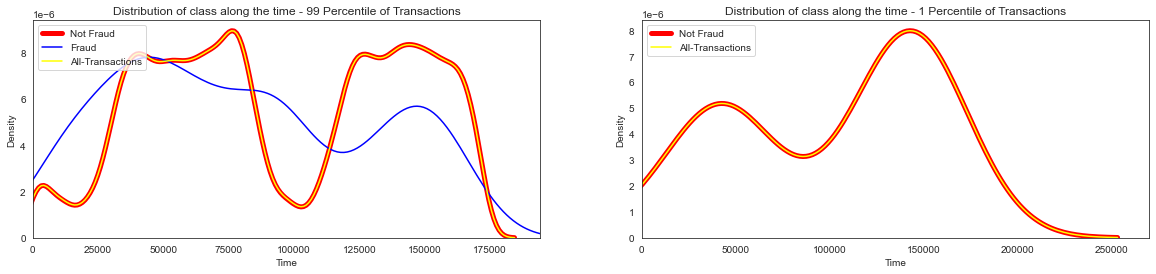

<Figure size 720x360 with 0 Axes>

Duration  3.235214399999677


In [32]:
#Distribution of class along the time
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(20,4))
start=timer()

plt.figure(figsize=(10,5))
#plt.title ("Distribution of class along the time")

class_0 = df99.loc[df['Class'] == 0]["Time"]
class_1 = df99.loc[df['Class'] == 1]["Time"]
sns.distplot(class_0,hist=False,rug=False,label='Not Fraud', color="red", ax=ax1, kde_kws=dict(linewidth=5)).set(xlim=0)
sns.distplot(class_1,hist=False,rug=False,label='Fraud', ax=ax1, color="blue")
sns.distplot(df99.Time,hist=False,rug=False,label='All-Transactions', ax=ax1, color="yellow")
ax1.set_title   ("Distribution of class along the time - 99 Percentile of Transactions")
#ax1.legend(bbox_to_anchor=(.25, 1))
ax1.legend(loc='upper left')

class_0 = df01.loc[df['Class'] == 0]["Time"]
class_1 = df01.loc[df['Class'] == 1]["Time"]
sns.distplot(class_0,hist=False,rug=False,label='Not Fraud', color="red", kde_kws=dict(linewidth=5), ax=ax2).set(xlim=0)
sns.distplot(class_1,hist=False,rug=False,label='Fraud', color="blue", ax=ax2)
sns.distplot(df01.Time,hist=False,rug=False,label='All-Transactions', color="yellow", ax=ax2)
ax2.set_title ("Distribution of class along the time - 1 Percentile of Transactions")
# ax2.legend(bbox_to_anchor=(-.25, 1))
ax2.legend(loc='upper left')

plt.show()

end = timer()
print("Duration ",end - start)

#Distribution of data for fraud and non-faud transactions are different. 
#Normal transaction and sum total of all transaction following same distribution. Because fraud trans are very few.
#We have two days data with us so it shows two peack in normal transaction.
#I am not able to identify any signfificant pattern in fraud transaction from two days data.

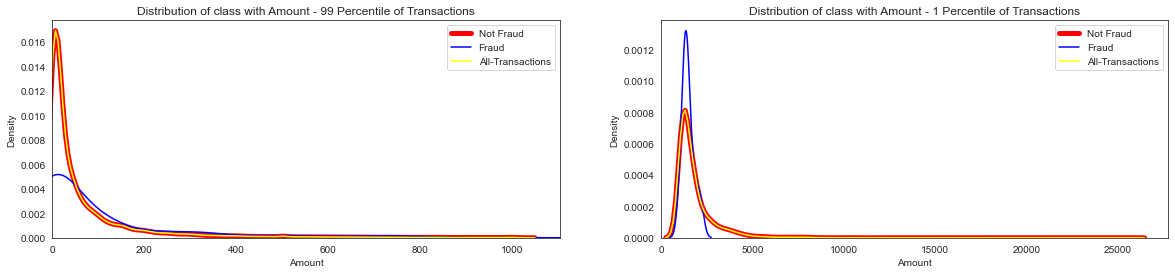

<Figure size 720x360 with 0 Axes>

Duration  5.839751000000003


In [16]:
#Distribution of class along the time
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(20,4))
start=timer()

plt.figure(figsize=(10,5))
#plt.title ("Distribution of class along the time")

class_0 = df99.loc[df['Class'] == 0]["Amount"]
class_1 = df99.loc[df['Class'] == 1]["Amount"]
sns.distplot(class_0,hist=False,rug=False,label='Not Fraud', color="red", ax=ax1, kde_kws=dict(linewidth=5)).set(xlim=0)
sns.distplot(class_1,hist=False,rug=False,label='Fraud', ax=ax1, color="blue")
sns.distplot(df99.Amount,hist=False,rug=False,label='All-Transactions', ax=ax1, color="yellow")
ax1.set_title   ("Distribution of class with Amount - 99 Percentile of Transactions")
#ax1.legend(bbox_to_anchor=(.25, 1))
ax1.legend(loc='upper right')

class_0 = df01.loc[df['Class'] == 0]["Amount"]
class_1 = df01.loc[df['Class'] == 1]["Amount"]
sns.distplot(class_0,hist=False,rug=False,label='Not Fraud', color="red", kde_kws=dict(linewidth=5), ax=ax2).set(xlim=0)
sns.distplot(class_1,hist=False,rug=False,label='Fraud', color="blue", ax=ax2)
sns.distplot(df01.Amount,hist=False,rug=False,label='All-Transactions', color="yellow", ax=ax2)
ax2.set_title ("Distribution of class with Amount - 1 Percentile of Transactions")
# ax2.legend(bbox_to_anchor=(-.25, 1))
ax2.legend(loc='upper right')

plt.show()

end = timer()
print("Duration ",end - start)

#Distribution of data for fraud and non-fraud transactions are different. 
#Normal transaction and sum total of all transaction following same distribution. Because fraud trans are very few.
#In 99 percentile we see most of the transactions are less than $200
#in 1 percentile we see a right tailed bell curve with a mean around $3000. 
#for this 1 percentile data interesting around this mean we see spike of fraud transaction

#### Analysis of Fraud against the Transaction Value

In [17]:
max_amount=int(round(max(df.Amount) *1.04,-3))
bins=list(range(0,1601,100))
bins.append(max_amount)
df['Amt']=pd.cut(df.Amount,bins)

In [18]:
all_trans = df.pivot_table(index="Amt",columns="Class",values="V1",aggfunc=len) 
all_trans['All'] = all_trans[0] +all_trans[1]
all_trans = all_trans.drop( 0, axis=1)
all_trans.columns=['Fraud','All']
all_trans['Fraud %'] = all_trans['Fraud']  / len( df[df.Class==1])*100
all_trans['All %'] = all_trans['All']  / len( df.Class)*100
all_trans
#79.5% of the transactions are less than $100 but fraud in that category is 68%.
#There are 9.57% transactions between $200 and 1600 but fraud is 16.86%

Fraud       All    Fraud %      All %
Amt                                                 
(0, 100]       335.0  226474.0  68.089431  79.518411
(100, 200]      45.0   27671.0   9.146341   9.715702
(200, 300]      22.0   10776.0   4.471545   3.783615
(300, 400]      21.0    5537.0   4.268293   1.944124
(400, 500]       7.0    3382.0   1.422764   1.187471
(500, 600]       7.0    2155.0   1.422764   0.756653
(600, 700]       5.0    1435.0   1.016260   0.503850
(700, 800]       9.0    1081.0   1.829268   0.379555
(800, 900]       3.0     823.0   0.609756   0.288968
(900, 1000]      2.0     708.0   0.406504   0.248589
(1000, 1100]     1.0     447.0   0.203252   0.156948
(1100, 1200]     NaN       NaN        NaN        NaN
(1200, 1300]     1.0     314.0   0.203252   0.110250
(1300, 1400]     3.0     246.0   0.609756   0.086374
(1400, 1500]     1.0     207.0   0.203252   0.072681
(1500, 1600]     1.0     165.0   0.203252   0.057934
(1600, 27000]    2.0    1169.0   0.406504   0.410453

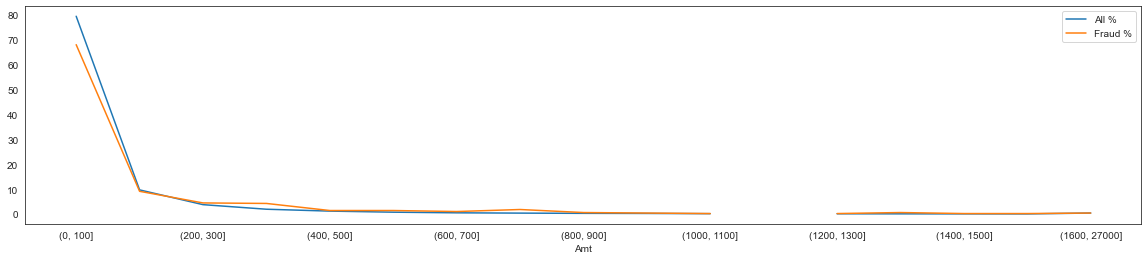

In [19]:
all_trans[['All %','Fraud %']].plot(figsize=(20, 4))
plt.show()

#### Let us see distribution of various columns

Duration  89.3322117


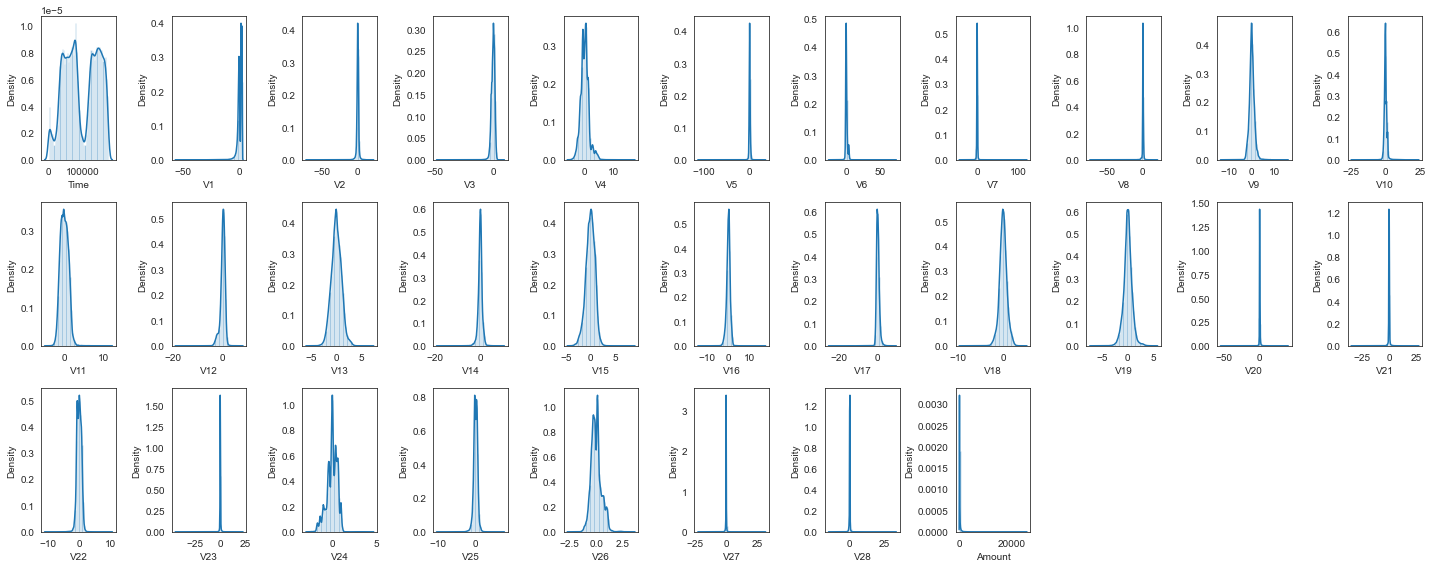

In [20]:
start = timer()
#Distribution of the data
plt.figure(figsize=(20,8))
i=1
for col in df.columns[0:30]:
    plt.subplot(3,11,i)
    sns.distplot(df[col])
    i+=1
plt.tight_layout()

end = timer()
print("Duration ",end - start)

#Except time and amount all fields looks having single peak bell curve. Although some of the fields are skwed right
#side and some looks skewed left side. So we can use power-transformer -yeo-johnson to handle this issue.

#### Here we will observe the distribution of our classes

In [21]:
# classes=df['Class'].value_counts()
# normal_share=classes[0]/df['Class'].count()*100
# fraud_share=classes[1]/df['Class'].count()*100

# amt=100*df.groupby("Class").sum()["Amount"] / sum(df.Amount)

# print ("Normal Transaction {:.2f}  Fraud Transaction {:.2f}  ".format (classes[0],classes[1]))
# print ("Normal Transaction {:.2f}%  Fraud Transaction {:.2f}%  ".format (normal_share,fraud_share))
# print ("Value of Normal Transaction {:.2f}%  Fraud Transaction {:.2f}%  ".format (amt[0],amt[1]))

# fraud_amt=df.loc[df['Class'] == 1]["Amount"]
# print ("\nAverage Value {:.2f} Min Value {:.2f}  Max Value {:.2f} Fraud Transactions".format( np.average(fraud_amt), np.min(fraud_amt), np.max(fraud_amt)))

# fraud_0amt_trans=len ( df.loc[  (df['Class'] == 1) & (df['Amount']==0)  ] )
# print ("\n# Fraud Transactions of 0 Value = ",fraud_0amt_trans)

#### Let us Check Coorelation Between Different Variables

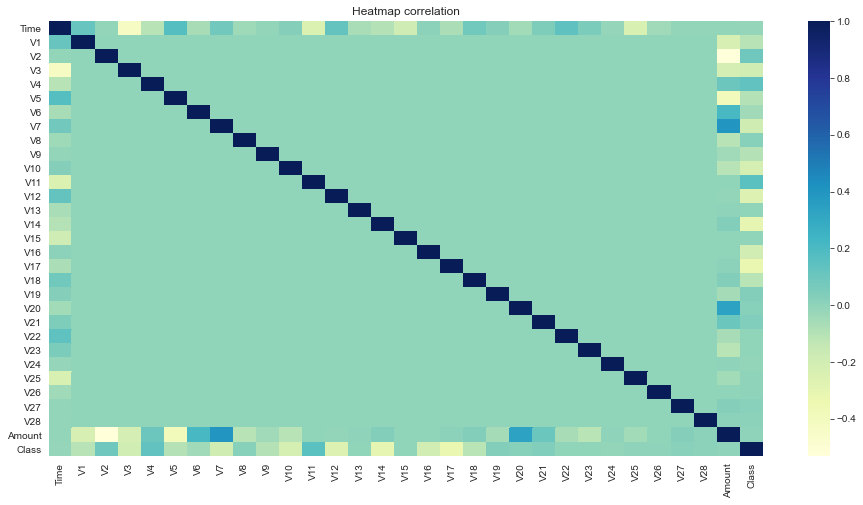

In [22]:
df_corr = df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
#sns.set(font_scale=.5,style='white')

plt.title('Heatmap correlation')
plt.show()

#Since this is is PCA data it looks there is no relationship between the given variables. Except time and amount has
#some sort of relationship with other fields.

#### Is there an relationship between variables and Class?

In [23]:

rank = pd.DataFrame(df_corr['Class']) #.sort_values(ascending=False)
rank['Relationship'] = rank.Class.apply(lambda x: "+" if x>0 else "-")
rank.Class=abs(rank.Class)
rank.rename(columns={"Class":"Degree of Relation with Class"}, inplace=True)
rank.sort_values("Degree of Relation with Class", ascending=False)

#Some variables show positive relationship with fraud and some negative. For example V17 & Fraud share share -ve
#relation. More the value of V17 lesser are the chances of this being fraud.
#V11 has +ve relationship. More the value of V11 more are the chances that transation is fraud.
#Value of transaction (amount) has very weak relation with class (fraud / non-fraud transaction) only .005 or .5 %
#Time of transaction has also has a very weak relation with class (fraud / non-fraud transaction) only .012 or 1.2 %

Degree of Relation with Class Relationship
Class                        1.000000            +
V17                          0.326481            -
V14                          0.302544            -
V12                          0.260593            -
V10                          0.216883            -
V16                          0.196539            -
V3                           0.192961            -
V7                           0.187257            -
V11                          0.154876            +
V4                           0.133447            +
V18                          0.111485            -
V1                           0.101347            -
V9                           0.097733            -
V5                           0.094974            -
V2                           0.091289            +
V6                           0.043643            -
V21                          0.040413            +
V19                          0.034783            +
V20                          0.020090            +
V8                           0.019875            +
V27                          0.017580            +
Time                         0.012323            -
V28                          0.009536            +
V24                          0.007221            -
Amount                       0.005632            +
V13                          0.004570            -
V26                          0.004455            +
V15                          0.004223            -
V25                          0.003308            +
V23                          0.002685            -
V22                          0.000805            +

#### <font color=red>Note 1: Because I don't have enough computing resources available (I tried nimblebox, google colab, kaggle but that also too slow), therfore I am NOT using full given dataset for the model building.</font> </br>

#### <font color=red>Note 2: We need to have modular code to run same models with different parameters and differnt data imbalance treatment otherwise it will be extremely difficult to maintain the code. Therefore I have taken different approach. Which you can observer while scanning and running the code.
</font>

In [24]:
df.drop(columns="Amt", inplace=True) #This field was created for binning purpose so not required for modeling

In [25]:
#Training model on huge dataset taking too much time so taking 5% of data initially. 
#Fraud class dataset is very small so adding it fully to the new dataset.
#When code start working fine and start doing reasonable prediction disable below line
#If you have enough resources you can disable this cell

df = pd.concat([ df.sample(frac=.05, random_state=1),df.loc[df.Class==1] ])
print (df.shape)

(14732, 31)


#### Let us see Distribution of data for the given 2 Classes

Duration  2.7451327999999933


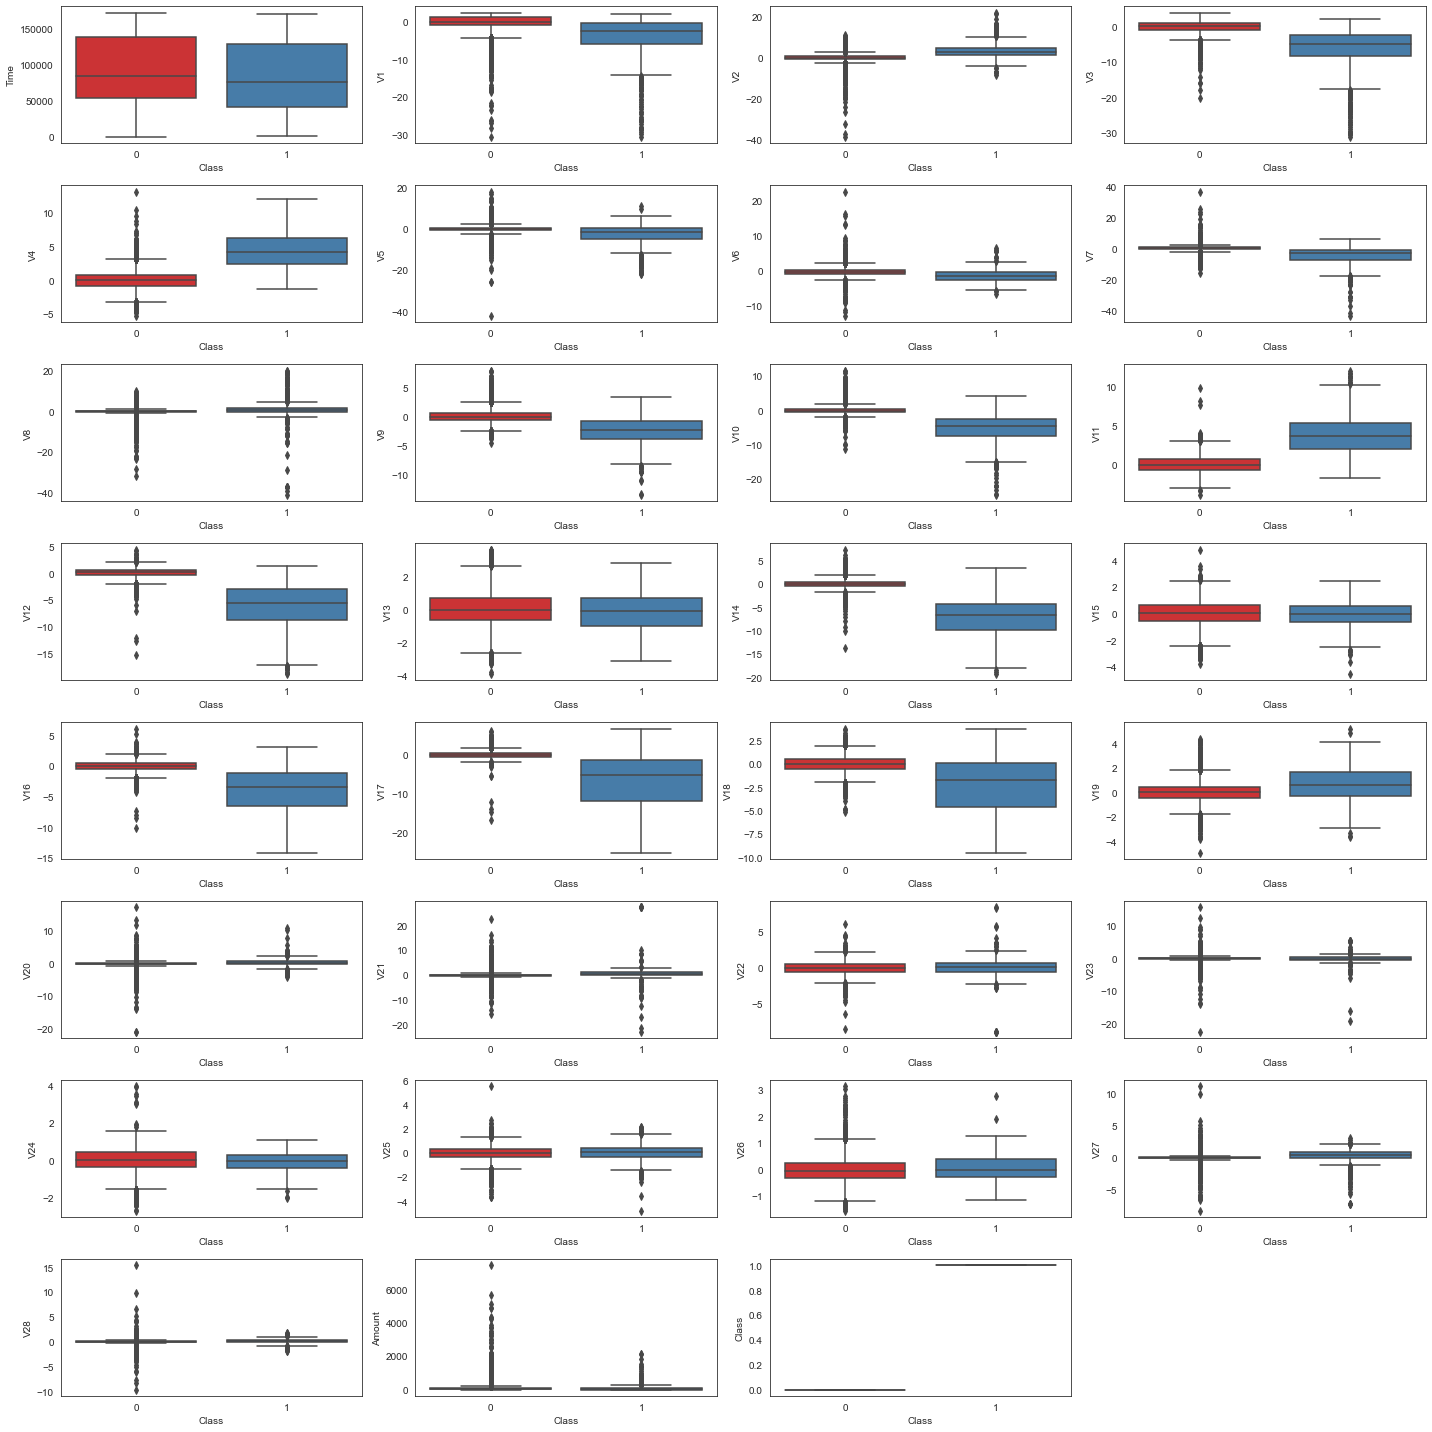

In [26]:

start=timer()

color = sns.color_palette("Set1", 6)
plt.figure(figsize=(20,20))
i=1

for col in df.columns:
    plt.subplot(8,4,i)
    ax=sns.boxplot(x=df['Class'],y=df[col],  palette=color)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2.,
                 p.get_height()), ha = 'center', va = 'center', 
                fontsize=8,
                xytext = (0, 10), textcoords = 'offset points')
    i+=1
plt.tight_layout()

end = timer()
print("Duration ",end - start)

#Almost all fields has outlier values.
#Median of data for both the classes is almost same for all variables.
#IQR range is significantly different for some of the variables like v1, v4, v5, v12, v14,v16, v17, v18

#### Creating a scatter plot 
#### To observe the relation between amount and other variable for both the classes.

Duration  31.810971299999977


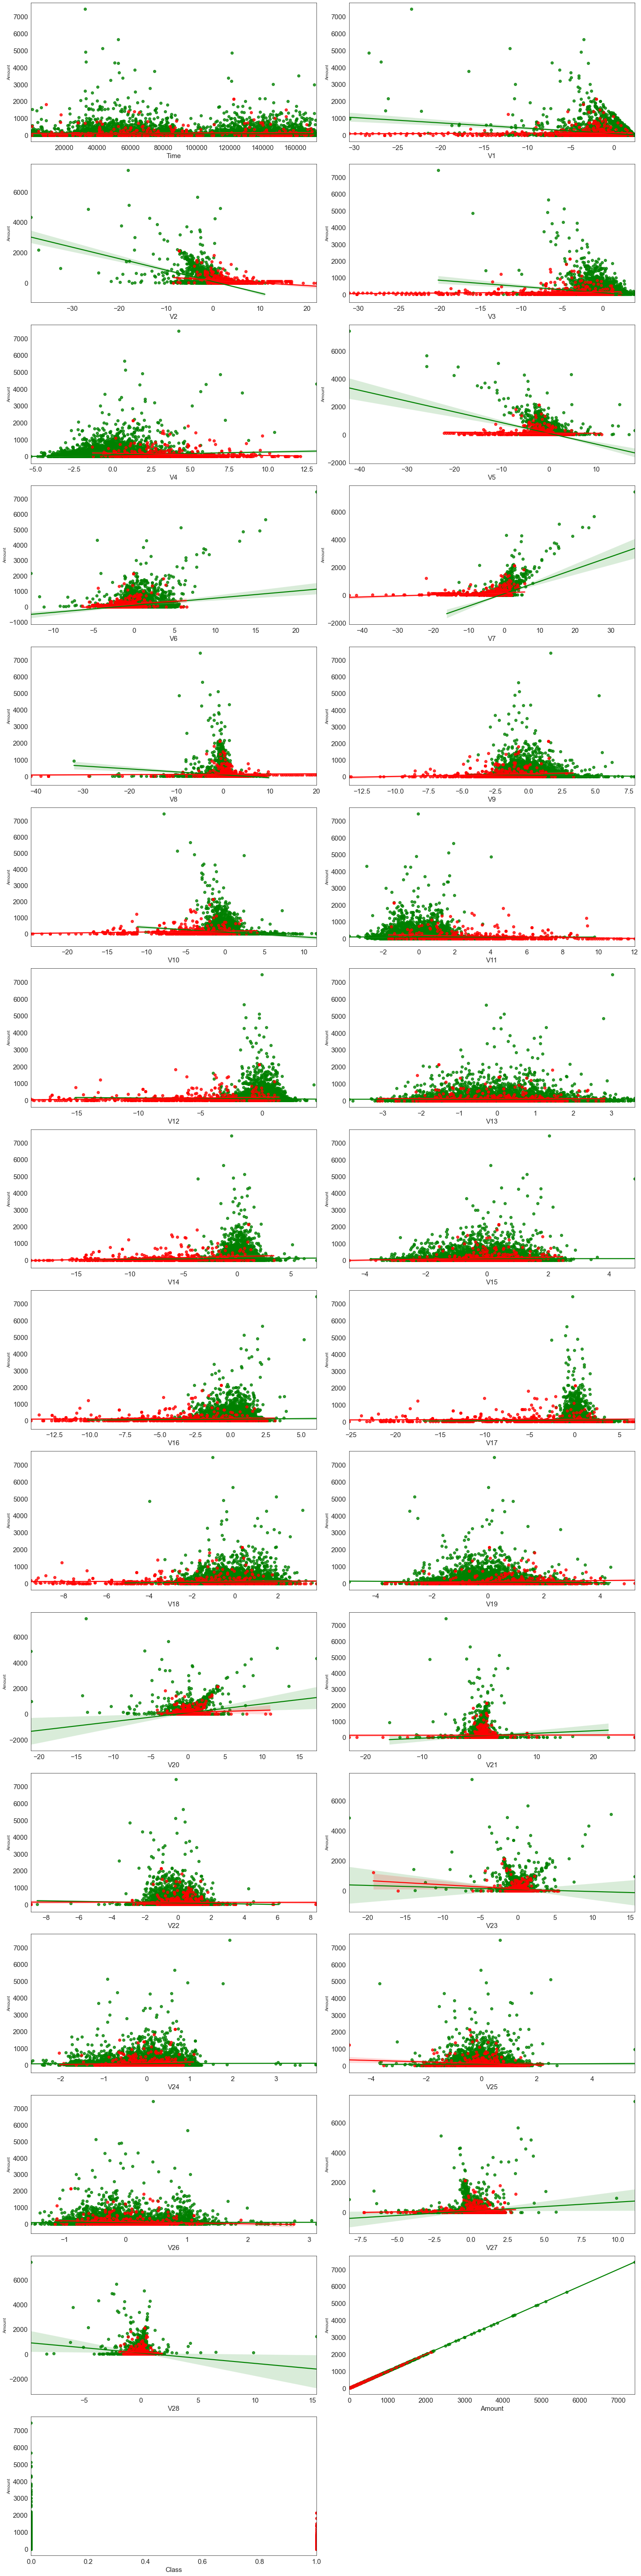

In [27]:

start=timer()

plt.figure(figsize=(20,80))
i=1
for col in df.columns:
    plt.subplot(16,2,i)
    
    sns.regplot(y=df[df.Class==0].Amount,x=df[df.Class==0][col], color="g")
    ax= sns.regplot(y=df[df.Class==1].Amount,x=df[df.Class==1][col], color="r")
    ax.tick_params(labelsize=15)
    ax.set_xlabel(col,fontsize=15)

    i+=1
plt.tight_layout()

end = timer()
print("Duration ",end - start)

#For most of the variables slope of amount field for non-fraud transaction has some slope. 
#But there is almost no slope for fraud transaction.

### Standard Scale All the Fields Including Time and Amount

In [28]:
cols2Scale = list(df.columns)
cols2Scale.remove("Class")

In [29]:
sc=StandardScaler()
t=sc.fit_transform(df[ cols2Scale ])
df[cols2Scale] = t
df.head(5)

Time        V1        V2        V3        V4        V5        V6  \
169876  0.542165 -0.177345 -0.446889  0.030154 -0.228183  1.201262 -1.422117   
127467 -0.331670 -0.259693  0.624082  0.666552 -0.079212 -0.088448 -0.441464   
137900 -0.246697 -0.058260  0.521235  0.511859 -0.170388  0.387885 -0.354232   
21513  -1.311793 -0.468064  0.469844  0.858443 -1.025369  0.004749 -0.300565   
134700 -0.277369  0.588818  0.264123 -0.154097  0.424096  0.104763 -1.028762   

              V7        V8        V9       V10       V11       V12       V13  \
169876  0.234010 -0.295085  0.343262  0.150528 -0.750772  0.442264  0.619634   
127467  0.248051  0.245784 -0.502037 -0.242045 -0.021675  0.537761  0.781292   
137900  0.433936 -0.036744 -0.310330 -0.199713 -0.719470  0.187087  1.134460   
21513   0.422154 -0.017949  0.363467  0.305515  0.598643 -0.041322 -1.323179   
134700  0.273245 -0.162085 -0.009051 -0.298171 -0.017832 -0.132346 -0.625392   

             V14       V15       V16       V17       V18       V19       V20  \
169876  0.068656 -0.674005 -0.107599 -0.199274 -0.783185 -0.269573 -0.255168   
127467  0.330012  1.039792  0.031051  0.182048 -0.842735 -0.591388 -0.023590   
137900 -0.245658  0.938807  0.546127 -0.063311  0.090487  0.221716  0.242750   
21513   0.120019  0.227397  0.685182 -0.409017  0.399852 -0.181219  0.378720   
134700 -0.554585  1.122121  0.540382  0.669377  0.376720 -0.458005 -0.142779   

             V21       V22       V23       V24       V25       V26       V27  \
169876 -0.100090  0.054402  0.560594  0.045778 -4.178695 -0.439237  0.128913   
127467 -0.150447 -0.484577  0.126908  0.671032 -0.483813  0.140878  0.323596   
137900 -0.317123 -1.013192 -0.193848 -0.813582 -0.025858  0.225411  0.499397   
21513  -0.237372 -0.550239 -0.366248  0.023474  0.447355  1.651165  0.194458   
134700 -0.180186 -0.565064 -0.123361  0.435239  1.049465  0.738112 -0.075573   

             V28    Amount  Class  
169876  0.621116 -0.366883      0  
127467  0.174706 -0.366102      0  
137900  0.265961 -0.370581      0  
21513  -0.001208 -0.308567      0  
134700  0.125718 -0.371115      0

In [30]:
df.describe().T

count          mean       std        min       25%       50%  \
Time    14732.0 -4.646779e-17  1.000034  -1.978474 -0.849607 -0.210434   
V1      14732.0 -7.628827e-17  1.000034 -12.324738 -0.327370  0.051949   
V2      14732.0 -6.295779e-17  1.000034 -19.890465 -0.350989 -0.008073   
V3      14732.0  4.993441e-16  1.000034 -13.287414 -0.341948  0.156732   
V4      14732.0 -1.940724e-16  1.000034  -3.206814 -0.572477 -0.069034   
V5      14732.0 -1.501122e-16  1.000034 -23.426401 -0.348161  0.024155   
V6      14732.0  8.975063e-18  1.000034  -9.096731 -0.539360 -0.178573   
V7      14732.0  2.007814e-16  1.000034 -20.953869 -0.198978  0.099392   
V8      14732.0  8.659016e-18  1.000034 -23.148860 -0.117662  0.018177   
V9      14732.0 -2.735842e-16  1.000034 -10.626995 -0.500331  0.009385   
V10     14732.0  7.481119e-17  1.000034 -14.281729 -0.235717  0.042328   
V11     14732.0 -2.294564e-16  1.000034  -3.072779 -0.661176 -0.086313   
V12     14732.0  4.422504e-16  1.000034 -10.827329 -0.156918  0.186578   
V13     14732.0 -6.059050e-18  1.000034  -3.855314 -0.652611 -0.013839   
V14     14732.0 -2.314572e-16  1.000034 -10.894029 -0.145142  0.142099   
V15     14732.0  1.208042e-17  1.000034  -4.943794 -0.635281  0.060359   
V16     14732.0  9.162430e-17  1.000034 -10.480091 -0.288727  0.143757   
V17     14732.0  8.108577e-16  1.000034 -12.937674 -0.151990  0.071982   
V18     14732.0 -7.097529e-17  1.000034  -8.868623 -0.434086  0.054514   
V19     14732.0 -6.521015e-17  1.000034  -5.790006 -0.555274 -0.008407   
V20     14732.0 -7.632689e-18  1.000034 -26.053695 -0.274975 -0.087277   
V21     14732.0  4.503028e-17  1.000034 -21.523321 -0.240620 -0.050502   
V22     14732.0  1.168101e-18  1.000034 -11.571876 -0.706825  0.006365   
V23     14732.0 -1.916062e-17  1.000034 -33.586411 -0.253294 -0.026825   
V24     14732.0 -4.895472e-17  1.000034  -4.432339 -0.593593  0.070100   
V25     14732.0 -3.047612e-17  1.000034  -9.007254 -0.598146  0.031966   
V26     14732.0  1.851628e-17  1.000034  -3.204155 -0.688823 -0.101640   
V27     14732.0 -7.738803e-17  1.000034 -16.771678 -0.153609 -0.002320   
V28     14732.0  3.253725e-18  1.000034 -26.538064 -0.138539  0.043823   
Amount  14732.0 -7.817984e-17  1.000034  -0.374239 -0.352304 -0.281772   
Class   14732.0  3.475428e-02  0.183163   0.000000  0.000000  0.000000   

             75%        max  
Time    0.946203   1.653384  
V1      0.597035   1.049218  
V2      0.386491  11.256507  
V3      0.534379   1.783252  
V4      0.395687   7.670043  
V5      0.403421  10.168539  
V6      0.307275  16.203026  
V7      0.358163  17.814875  
V8      0.197899  11.283861  
V9      0.534383   6.371375  
V10     0.360790   6.890872  
V11     0.531174   9.123385  
V12     0.467311   2.702241  
V13     0.670131   3.602262  
V14     0.397576   4.384161  
V15     0.710106   5.288812  
V16     0.487095   4.678806  
V17     0.321200   3.611147  
V18     0.525662   3.639083  
V19     0.527937   6.065527  
V20     0.171631  21.389370  
V21     0.164374  25.618320  
V22     0.692161  10.878782  
V23     0.222477  23.353254  
V24     0.723247   6.536716  
V25     0.667027  10.456923  
V26     0.522689   6.395612  
V27     0.201199  22.594081  
V28     0.239938  42.445658  
Amount -0.047194  30.156835  
Class   0.000000   1.000000

### Plotting the distribution of a variable- After Scaling

Duration  8.457775999999996


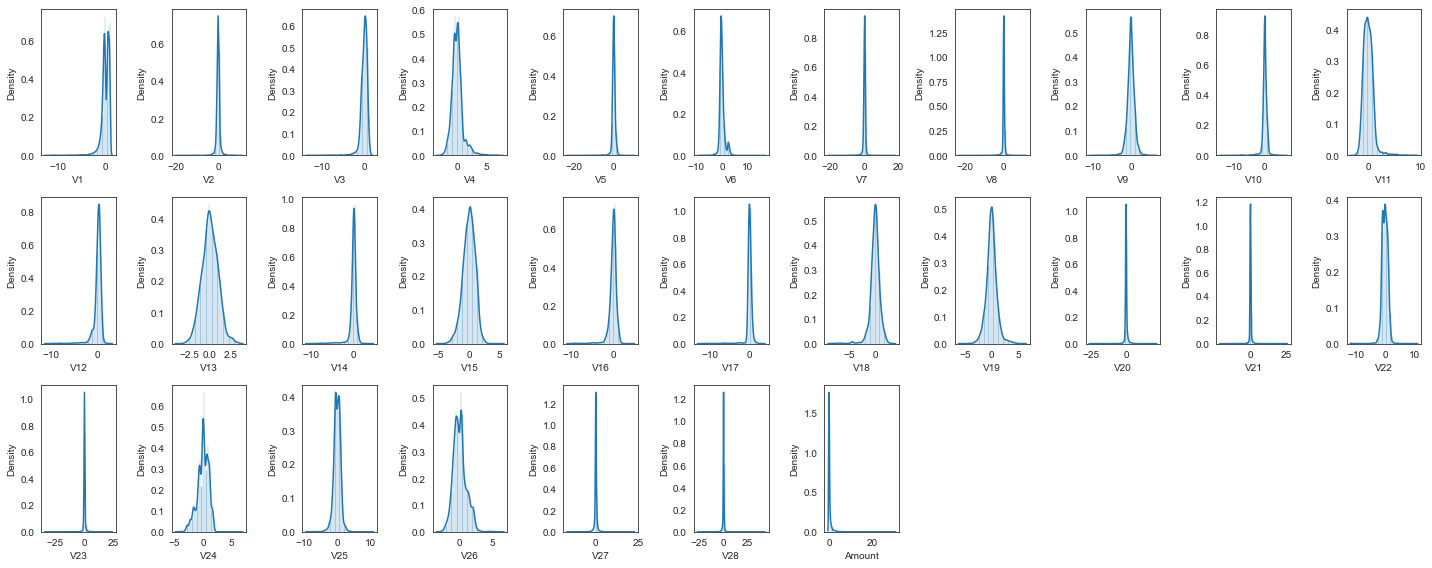

In [31]:
# plot the histogram of a variable from the dataset to see the skewness
#Distribution of the data
start=timer()

plt.figure(figsize=(20,8))
i=1
for col in df.columns[1:30]:
    plt.subplot(3,11,i)
    sns.distplot(df[col])
    i+=1
plt.tight_layout()

end = timer()
print("Duration ",end - start)

### Some fields are still skewed. So using PowerTransformer to fix that issue.
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [32]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
#'yeo-johnson’ [1], works with positive and negative values
#‘box-cox’ [2], only works with strictly positive values

df[cols2Scale] = power_transform(df[cols2Scale], method='yeo-johnson')

### Plotting the distribution of a variable- After Correcting Skweness Issue

Duration  10.397172099999977


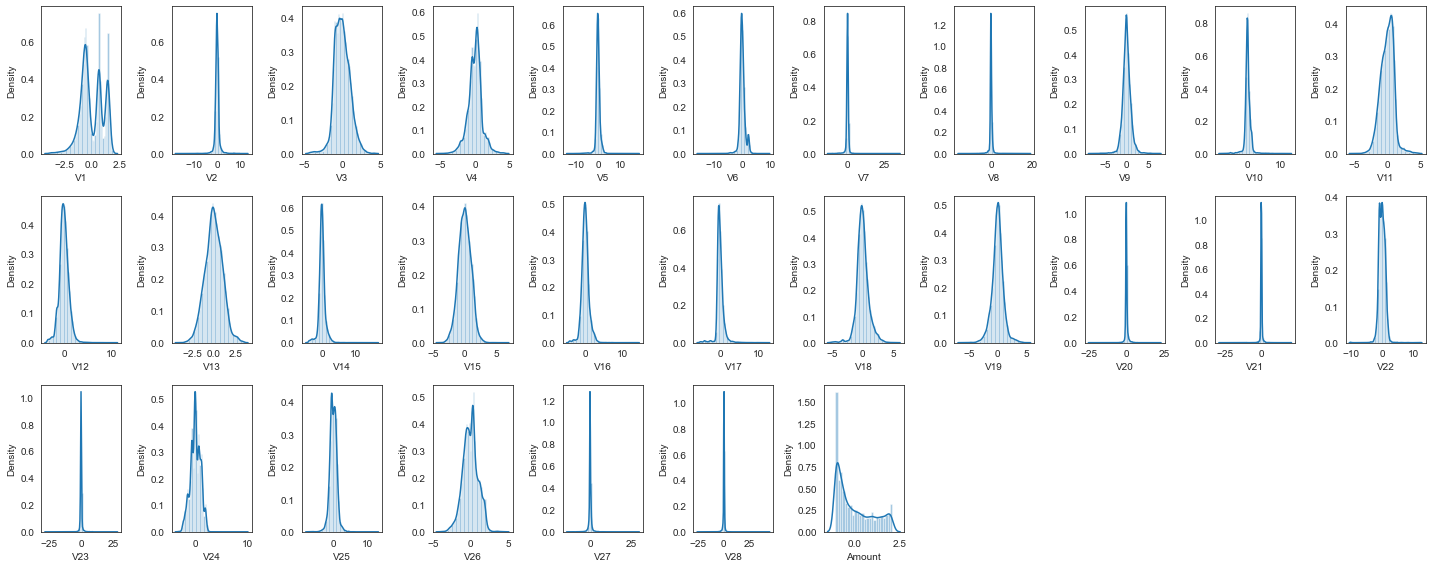

In [33]:
# Re-plot the histogram of a variable from the dataset to see the skewness
#Distribution of the data
start=timer()

plt.figure(figsize=(20,8))
i=1
for col in df.columns[1:30]:
    plt.subplot(3,11,i)
    sns.distplot(df[col])
    i+=1
plt.tight_layout()

end = timer()
print("Duration ",end - start) 

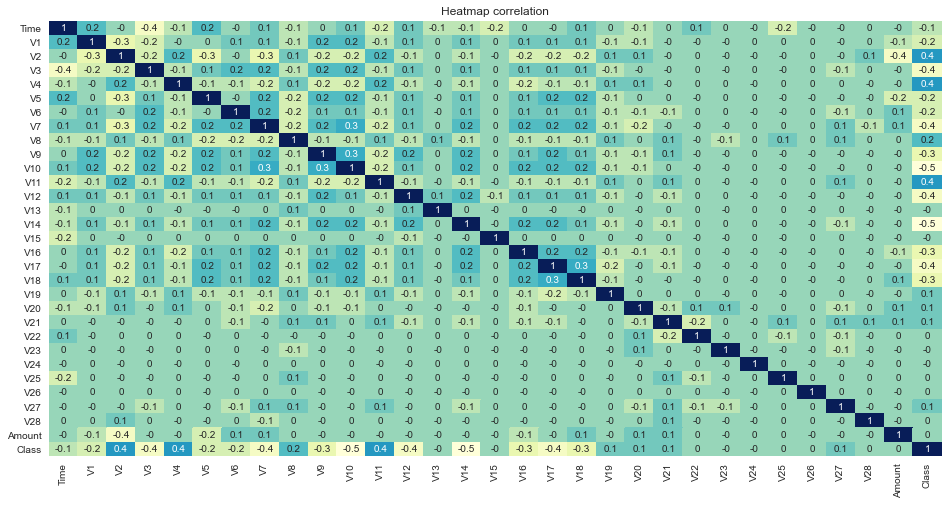

In [34]:
#Re-Check Coorelation Between Different Variables
df_corr = df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(round(df_corr,1), annot=True, cbar=False, cmap="YlGnBu", ) # Displaying the Heatmap
#sns.set(font_scale=.5,style='white')

plt.title('Heatmap correlation')
plt.show()

#After scaling and normalising variable looks there is some kind of relationship between different fields.

### Check the outliers after fixing skewness & scale issue

Duration  2.590262999999993


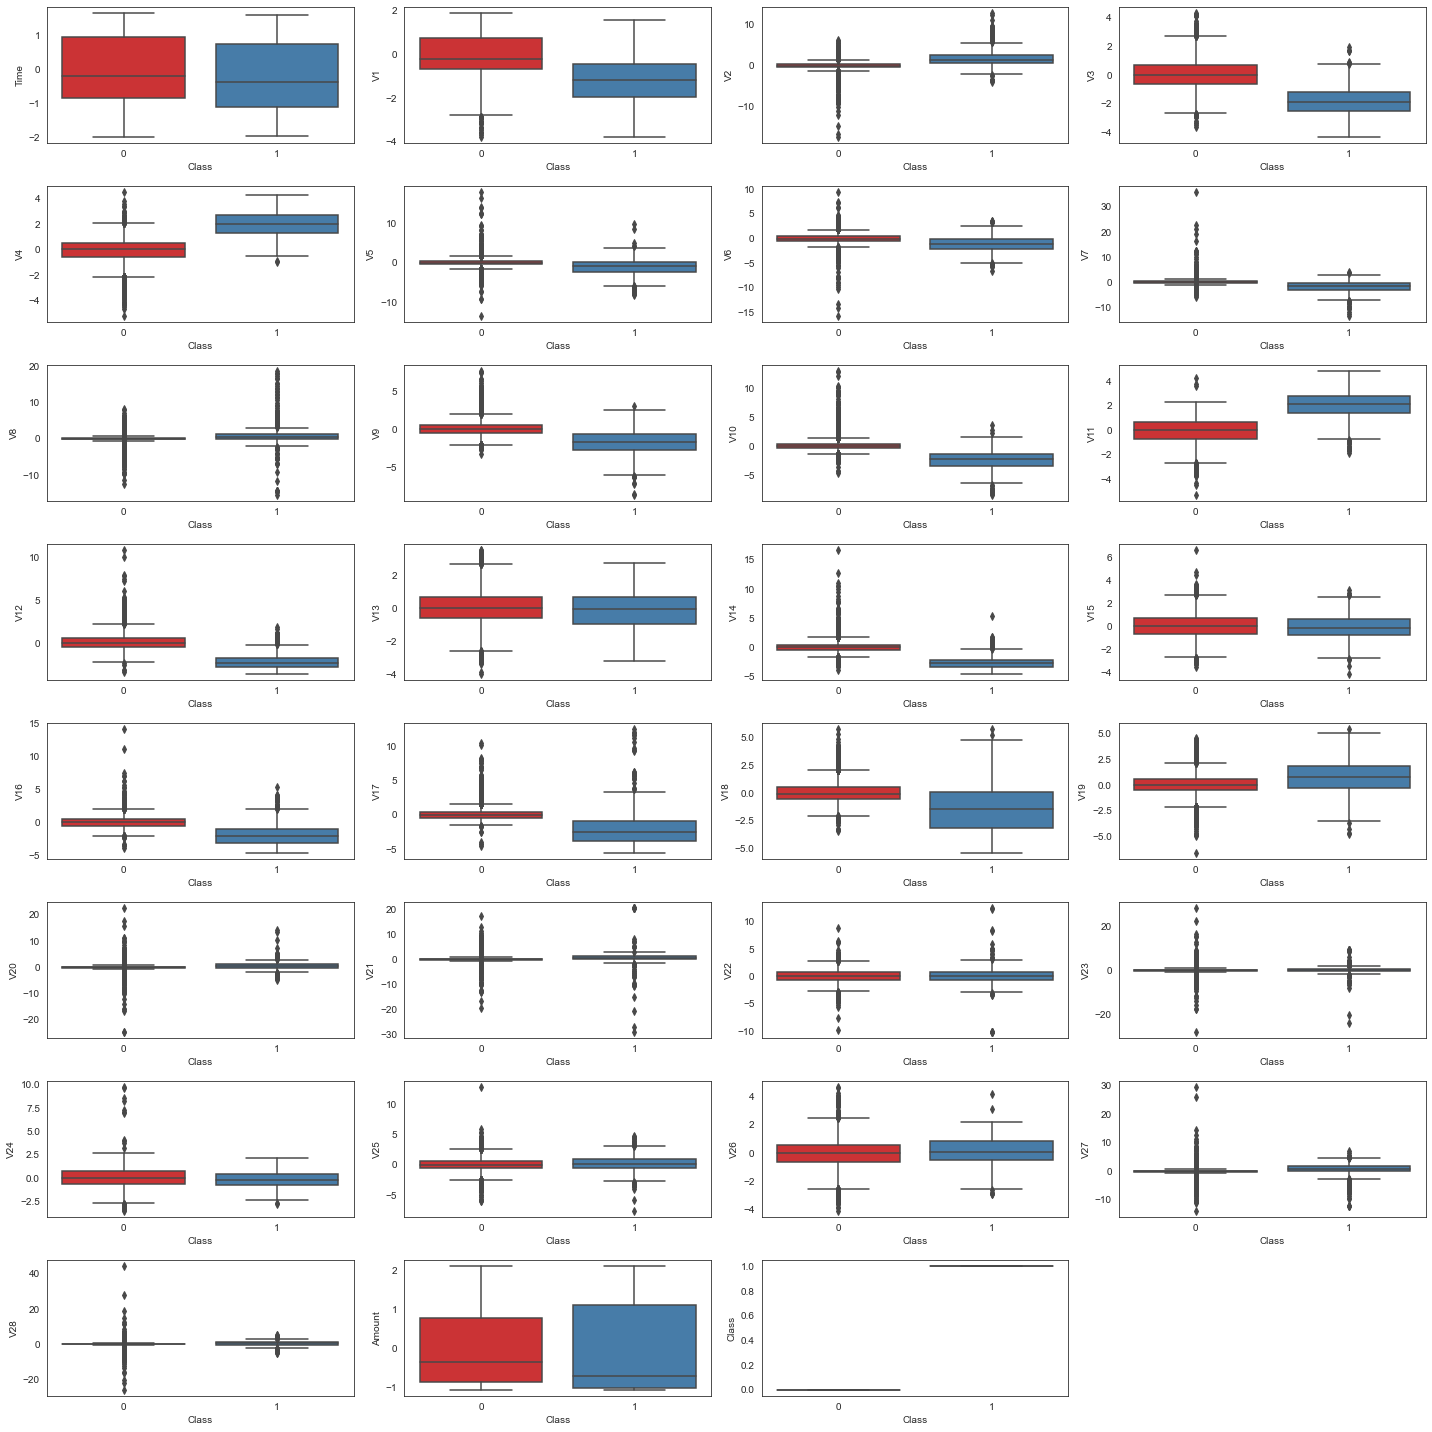

In [35]:
#Distribution of data acrros 2 Classes
start=timer()

color = sns.color_palette("Set1", 6)
plt.figure(figsize=(20,20))
i=1

for col in df.columns:
    plt.subplot(8,4,i)
    ax=sns.boxplot(x=df['Class'],y=df[col],  palette=color)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2.,
                 p.get_height()), ha = 'center', va = 'center', 
                fontsize=8,
                xytext = (0, 10), textcoords = 'offset points')
    i+=1
plt.tight_layout()

end = timer()
print("Duration ",end - start)

#Now dataset looks quite balance for fraud and non-fraud transaction. 
#Almost same ratio of IQR width, and almost same median value for fraud/non-fraud for each varaible.

# <font color=blue> Section 2: Splitting the data into Train & Test

In [36]:
def split_data_normal(df):
    X= df.drop(columns=["Class"], axis=0)
    y= df.Class #class variable

    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,stratify=y, test_size=0.25, random_state=100)
    return (X_train1, X_test1, y_train1, y_test1)

def split_data_ros(X_train1, X_test1, y_train1, y_test1):
    #Oversample the fraud transaction data using RandomOverSampler Method
    ros = over_sampling.RandomOverSampler(random_state=100)
    X_train_ros, y_train_ros       = ros.fit_resample(X_train1, y_train1)
    X_test_ros,  y_test_ros        = (X_test1, y_test1)
    return (X_train_ros, X_test_ros, y_train_ros, y_test_ros)

def split_data_smote(X_train1, X_test1, y_train1, y_test1):
    #OverSample the fraud transaction data using Smoth method
    smt = over_sampling.SMOTE(random_state=100)
    X_train_smote, y_train_smote   = smt.fit_resample(X_train1, y_train1)
    X_test_smote,  y_test_smote    = (X_test1, y_test1)
    return (X_train_smote, X_test_smote, y_train_smote, y_test_smote)

def split_data_adasyn(X_train1, X_test1, y_train1, y_test1):
    #OverSample the fraud transaction data using AdaSyn
    ada = over_sampling.ADASYN(random_state=100)
    X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train1, y_train1)
    X_test_adasyn,  y_test_adasyn  = (X_test1, y_test1)
    return (X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn)

In [37]:
X_train1, X_test1, y_train1, y_test1  = split_data_normal(df)
X_train_ros, X_test_ros, y_train_ros, y_test_ros              = split_data_ros(X_train1, X_test1, y_train1, y_test1)
X_train_smote, X_test_smote, y_train_smote, y_test_smote      = split_data_smote(X_train1, X_test1, y_train1, y_test1)
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn  = split_data_adasyn(X_train1, X_test1, y_train1, y_test1)

In [97]:
y_train1.value_counts(), y_test1.value_counts()

(0    10665
 1      384
 Name: Class, dtype: int64,
 0    3555
 1     128
 Name: Class, dtype: int64)

# <font color=blue>Section 3: Visuzalise Results of Various Oversampling Methods</font>

### Random Oversampling

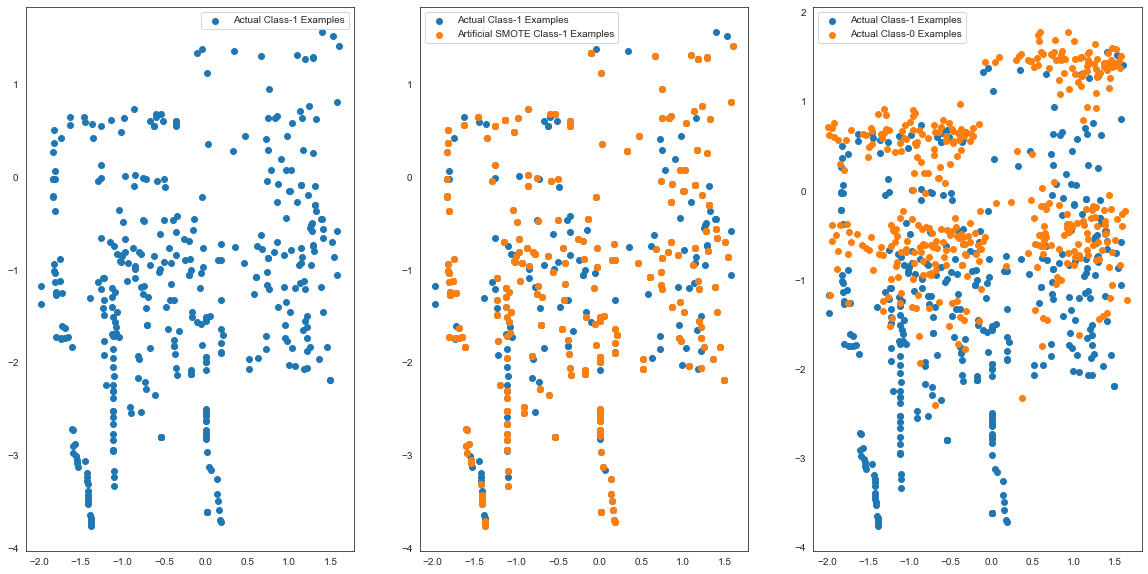

In [38]:
X_train_ros_1 = X_train_ros[X_train1.shape[0]:]

X_train_1 = X_train1.to_numpy()[np.where(y_train1==1.0)]
X_train_0 = X_train1.to_numpy()[np.where(y_train1==0.0)]

plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_ros_1.iloc[:X_train_1.shape[0], 0], 
            X_train_ros_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial ROS Class-1 Examples')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], 
            X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### SMOTE : Synthetic Minority Over-sampling Technique

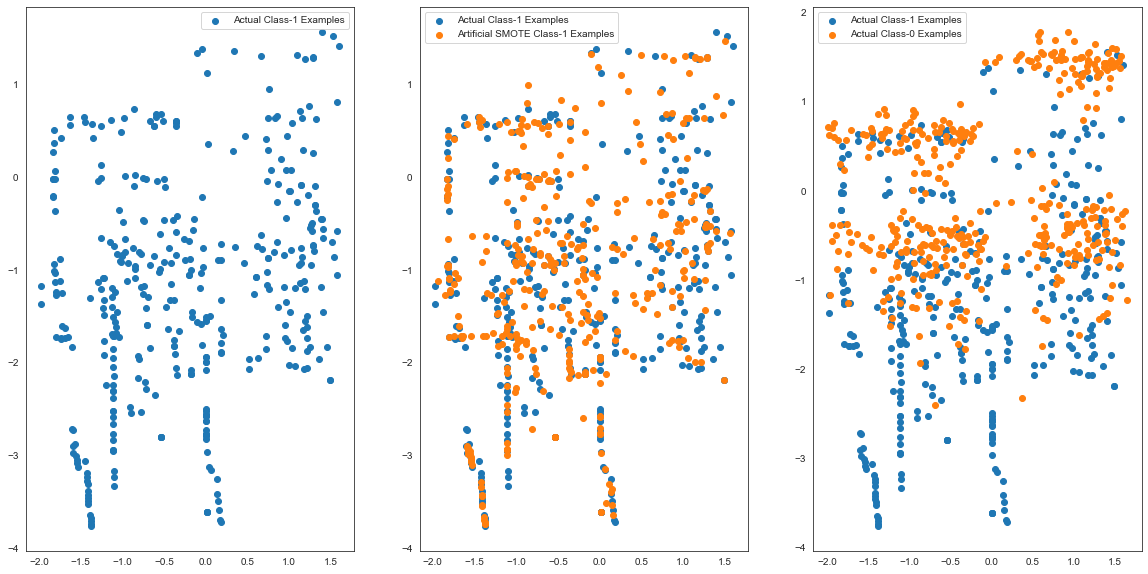

In [39]:
X_train_smote_1 = X_train_smote[X_train1.shape[0]:]

X_train_1 = X_train1.to_numpy()[np.where(y_train1==1.0)]
X_train_0 = X_train1.to_numpy()[np.where(y_train1==0.0)]


plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], 
            X_train_smote_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### ADASYN : Adaptive Synthetic Sampling Method

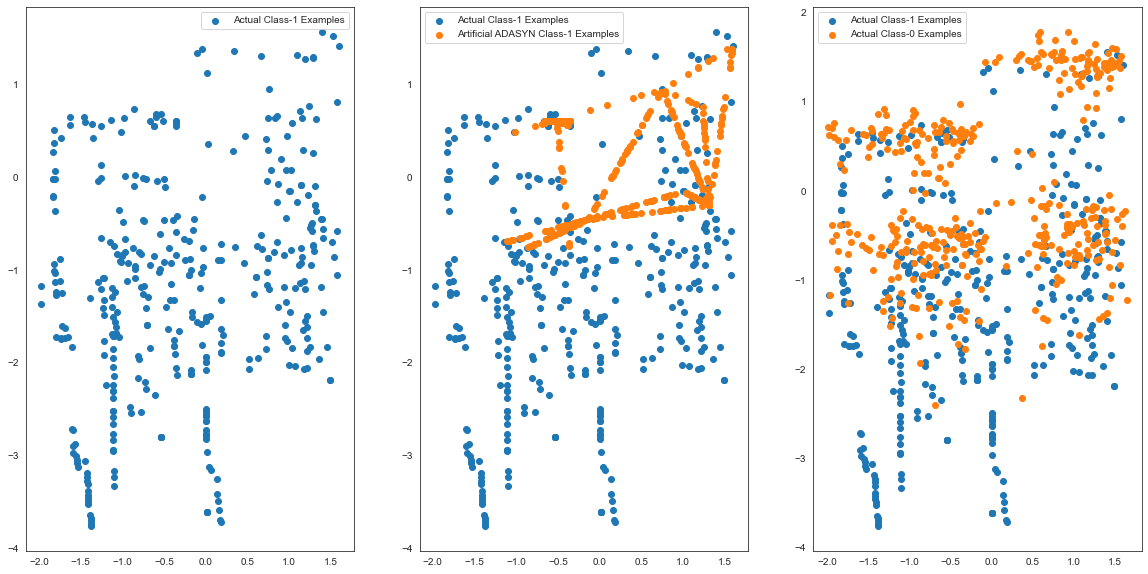

In [40]:
X_train_adasyn_1 = X_train_adasyn[X_train1.shape[0]:]

X_train_1 = X_train1.to_numpy()[np.where(y_train1==1.0)]
X_train_0 = X_train1.to_numpy()[np.where(y_train1==0.0)]

plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1.iloc[:X_train_1.shape[0], 0], 
            X_train_adasyn_1.iloc[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

# <font color=blue> Section 4: Select the Dataset Imbalancing Method</font>

In [41]:
model_with_data_list=['Normal','RandomOverSampler','Smote','AdaSyn']
def select_dataset(option=-1):
    if option==0:
        X_train, X_test, y_train, y_test = X_train1, X_test1, y_train1, y_test1
    elif option==1:
        X_train, X_test, y_train, y_test = X_train_ros, X_test_ros, y_train_ros , y_test_ros
    elif option==2:
        X_train, X_test, y_train, y_test = X_train_smote, X_test_smote, y_train_smote , y_test_smote
    elif option==3:
        X_train, X_test, y_train, y_test = X_train_adasyn, X_test_adasyn, y_train_adasyn , y_test_adasyn


    print ("\n\nRunning Model with **",model_with_data_list[option],"Data")
    
    print('Transaction Records in Train',len(y_train))
    print('Transaction Records in Test',len(y_test))
    print('Total Fraud Transaction Records',np.sum(y_train) + np.sum(y_test))
    print('Fraud Transaction Records in Train',np.sum(y_train))
    print('Fraud Transaction Records in Test',np.sum(y_test))
    
    return (X_train, X_test, y_train, y_test)


# <font color=blue> Section 5: Helper Functions for Model Building </font>

In [42]:
# Plotting cv results
def draw_cv_results(cv_df, param_name, metric_name, title_name, log_true):
    plt.figure(figsize=(10,4))
    
    if log_true:
        x_axis= np.log10( list(cv_df[param_name]))
        x_axis_title = "Log Value "+param_name
    else:
        x_axis = list(cv_df[param_name])
        x_axis_title = param_name
        
    plt.plot( x_axis, cv_df['mean_train_score'] )
    plt.plot( x_axis, cv_df['mean_test_score'] )
    plt.xlabel(x_axis_title)
    plt.ylabel(metric_name)
    plt.title(title_name)
    plt.legend(['Train ' + metric_name +' score', 'Test ' +metric_name+' score'], loc='upper left')


In [43]:
# Function to plot the confusion Matrix
def draw_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.tab10):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
   
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = 'd' 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.fill(j,i,facecolor="red" if cm[i, j] < thresh else "blue", edgecolor='b', linewidth=2)
        #plt.Rectangle((0, 0), 1, 0, linewidth=1, edgecolor='b', facecolor='none')
        
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20, weight="bold", 
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white", 
                 
                bbox=dict(facecolor='red', alpha=0.8))

    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [44]:
class_names=[0,1]
def draw_roc( actual, probs, prob_values=True, Threshold_limit=0.5 ):
  
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                          drop_intermediate = False )
    
    threshold = thresholds[np.argmax(tpr-fpr)]

    if prob_values:
        pred= probs.map(lambda x: 1 if x > threshold else 0)
    else:
        pred= probs
        
    auc_score = round( metrics.roc_auc_score( actual, probs) ,2)
    
    recall    = round( metrics.recall_score(actual,pred),2)
    precision = round(metrics.precision_score(actual, pred),2)
    f1= round(metrics.f1_score(actual,pred),2)
    print ("This Model Result is for ", model_with_data_list[option], " Data")
    print ("ROC AUC Score on Test:",auc_score," Threshold:{:.5f}".format(threshold))

    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]',fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic example',fontsize=20)
    plt.legend(loc="lower right")
    
    plt.subplot(1,2,2)
    cm = confusion_matrix(actual, pred)
    draw_confusion_matrix(cm,class_names)
    plt.show()

    return auc_score,recall,precision,f1

# <font color=blue> Section 6: Model Building </font>

### Model 1: Logistic Regression

In [45]:
# Cross validation using different values of C. Let's check which value of C gives best result
def logistic_cv():
    start=timer()
    if run_GSCV:
        hyper_params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]

        lr = LogisticRegression(max_iter=1000, random_state=100)
        lr.fit(X_train, y_train)      

        model_cv_logistic = GridSearchCV(estimator=lr, param_grid=hyper_params, \
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_logistic.fit(X_train,  y_train)

        cv_results_lr = pd.DataFrame(model_cv_logistic.cv_results_)
        print(cv_results_lr)

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        draw_cv_results(cv_results_lr, 'param_C', 'ROC AUC', 'Optimal C', True)
        
    if run_GSCV:
        model_cv_logistic.best_estimator_

In [46]:
#There are 29 variables in X_train. Let's see can we manage good result with lessor variables.
def logistic_with_rfe():
    if option==0 or option==1:
        lr = LogisticRegression(C=.1,max_iter=1000, random_state=100) 
        #Value of C & max_iter from earlier steps #for normal
    elif option==2:
        lr = LogisticRegression(C=10,max_iter=1000, random_state=100) 
        #Value of C & max_iter from earlier steps #for smote
    else:
        lr = LogisticRegression(C=100,max_iter=1000, random_state=100) 
        #Value of C & max_iter from earlier steps #for adasyn
    rfe = RFE(lr,15) #Identify top 15 important variables
    rfe.fit(X_train,y_train)
    useful_cols = X_train.columns[rfe.support_]
    #print ("Useful Columns: " ,useful_cols)
    
    #check the ranking of these variables
    print('Important Variables Identified in RFE')
    print(list(zip(X_train.columns, rfe.support_, rfe.ranking_)))
    return useful_cols

In [47]:
def logistic():
    #Hyperparameter Turning of LogisticRegression
    #Train the model with only 15 variables (identified in earlier step)

    useful_cols = logistic_with_rfe()
    X_train_= X_train[useful_cols]
    X_test_ = X_test[useful_cols]
    lr = LogisticRegression(C=.1,max_iter=1000, random_state=100)
    lr.fit(X_train_,y_train)

    y_test_pred_logistic = lr.predict_proba(X_test_)
    y_test_pred_logistic = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_logistic[:,1:2].reshape(-1) })

    #check ROC_AUC Score on Test
    logistic_auc_test, logistic_recall_test, logistic_precision_test, logistic_f1_test = \
                            draw_roc(y_test_pred_logistic.Class, y_test_pred_logistic.Class_Prob, True)
    return (logistic_auc_test, logistic_recall_test, logistic_precision_test, logistic_f1_test)

### Model 2: GLM

In [48]:
def glm():
    useful_cols = logistic_with_rfe()
    X_train_sm = sm.add_constant(X_train[useful_cols])
    X_test_ = X_test[useful_cols]
    
    glm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
    glm = glm.fit()

    X_test_sm = sm.add_constant(X_test_)
    y_test_pred_glm = glm.predict( X_test_sm  )
    y_test_pred_glm = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_glm })

    #check ROC_AUC Score on Test
    glm_auc_test, glm_recall_test, glm_precision_test, glm_f1_test = \
                        draw_roc(y_test_pred_glm.Class, y_test_pred_glm.Class_Prob)
    
    print (glm.summary())
    return (glm_auc_test, glm_recall_test, glm_precision_test, glm_f1_test)

### Model 3: KNeighborsClassifier

In [49]:
# Cross validation using different values of n_neighbors.
def knn_cv():
    start=timer()

    if run_GSCV:
        hyper_params = [{'n_neighbors': range(2,15,2) }]
        knn = KNeighborsClassifier()
        model_cv_knn = GridSearchCV(estimator=knn, param_grid=hyper_params, \
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_knn.fit(X_train,  y_train)

        cv_results_knn = pd.DataFrame(model_cv_knn.cv_results_)
        print(cv_results_knn.sort_values('rank_test_score'))

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        draw_cv_results(cv_results_knn, 'param_n_neighbors', 'ROC AUC', 'Optimal n_neighbours', False)
    
    if run_GSCV:
        print(model_cv_knn.best_estimator_)

In [50]:
#Hyperparameter Turning of KNeighborsClassifier
def knn():
    knn = KNeighborsClassifier(n_neighbors = 4, leaf_size=30, p=2)
    knn.fit(X_train, y_train)
    y_test_pred_knn = knn.predict_proba(X_test)

    y_test_pred_knn = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_knn[:,1:2].reshape(-1) })


    knn_auc_test, knn_recall_test, knn_precision_test,knn_f1_test = \
                            draw_roc(y_test_pred_knn.Class, y_test_pred_knn.Class_Prob)
    
    return (knn_auc_test, knn_recall_test, knn_precision_test,knn_f1_test)


### Model 4: RandomForestClassifier

In [51]:
# Cross validation using different values of C. Let's check which value of C gives best result
def rfc_cv():
    start=timer()
    if run_GSCV:
        hyper_params=[{'n_estimators':range(4,20,2),'max_depth':range(8,25,2)}]

        rfc = RandomForestClassifier()
        model_cv_rfc = GridSearchCV(estimator=rfc, param_grid=hyper_params, \
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_rfc.fit(X_train,  y_train)

        cv_results_rfc = pd.DataFrame(model_cv_rfc.cv_results_)
        print(cv_results_rfc.sort_values('rank_test_score'))

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        cv_results_rfc.param_max_depth = cv_results_rfc.param_max_depth.astype("float")
        plt.figure(figsize=(20,4))
        plt.subplot(1,2,1)
        ax1=sns.lineplot(x='param_n_estimators',  y='mean_test_score', hue='param_max_depth', data=cv_results_rfc)
        ax1.set_title("Test AUC Score")
        plt.subplot(1,2,2)
        ax2= sns.lineplot(x='param_n_estimators', y='mean_train_score', hue='param_max_depth',data=cv_results_rfc, ci=0)
        ax2.set_title("Train AUC Score")
        plt.show()
        
    if run_GSCV:
        print(model_cv_rfc.best_estimator_)

In [52]:
#Optimised Hyper Parameters
def rfc():
    rfc= RandomForestClassifier(n_estimators=16, criterion="gini", max_depth=6, random_state=100)
    rfc.fit(X_train,y_train)
    y_test_pred_rfc = rfc.predict_proba(X_test)[:,1:2]

    y_test_pred_rfc = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_rfc.reshape(-1) })

    rfc_auc_test, rfc_recall_test, rfc_precision_test, rfc_f1_test = \
                            draw_roc(y_test_pred_rfc.Class, y_test_pred_rfc.Class_Prob)
    return (rfc_auc_test, rfc_recall_test, rfc_precision_test, rfc_f1_test)

### Model 5: DecisionTreeClassifier

In [53]:
# Cross validation using different values of C. Let's check which value of C gives best result
def dtc_cv():
    start=timer()

    if run_GSCV:
        hyper_params=[{'max_depth': range(10,20,2),
                   'min_samples_leaf': range(1, 5, 1),
                   'min_samples_split': range(1, 5, 1) }]

        dtc = DecisionTreeClassifier(random_state=100)
        model_cv_dtc = GridSearchCV(estimator=dtc, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_dtc.fit(X_train,  y_train)

        cv_results_dtc = pd.DataFrame(model_cv_dtc.cv_results_)
        print(cv_results_dtc.sort_values('rank_test_score'))

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        cv_results_dtc.param_max_depth = cv_results_dtc.param_max_depth.astype("float")

        plt.figure(figsize=(20,4))
        plt.subplot(1,4,1)
        ax1=sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', hue='param_max_depth',data=cv_results_dtc, ci=0)
        ax1.set_title("Test AUC Score")
        plt.subplot(1,4,2)
        ax2= sns.lineplot(x='param_min_samples_leaf', y='mean_train_score', hue='param_max_depth',data=cv_results_dtc, ci=0)
        ax2.set_title("Train AUC Score")

        plt.subplot(1,4,3)
        ax1=sns.lineplot(x='param_min_samples_split', y='mean_test_score', hue='param_max_depth',data=cv_results_dtc, ci=0)
        ax1.set_title("Test AUC Score")
        plt.subplot(1,4,4)
        ax2= sns.lineplot(x='param_min_samples_split', y='mean_train_score', hue='param_max_depth',data=cv_results_dtc, ci=0)
        ax2.set_title("Train AUC Score")
        plt.show()
    
    if run_GSCV:
        print(model_cv_dtc.best_estimator_)

In [54]:
#Optimised Hyper Parameters
def dtc():
    dtc= DecisionTreeClassifier(max_depth=16, min_samples_leaf=1, min_samples_split=2, random_state=100)

    dtc.fit(X_train,y_train)
    y_test_pred_dtc = dtc.predict_proba(X_test)[:,1:2]

    y_test_pred_dtc = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_dtc.reshape(-1) })

    dtc_auc_test, dtc_recall_test, dtc_precision_test, dtc_f1_test = \
                        draw_roc(y_test_pred_dtc.Class, y_test_pred_dtc.Class_Prob, True)
    return (dtc_auc_test, dtc_recall_test, dtc_precision_test, dtc_f1_test)


### Model 6: LGBM

In [55]:
# Cross validation using different values of n_estimators.
def lgbm_cv():
    start=timer()
    if run_GSCV:
        hyper_params=[{  'n_estimators': range(10,110,10)  }]

        lgbm_clf = lgbmc.LGBMClassifier(random_state=100)
        model_cv_lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_lgbm.fit(X_train,  y_train)

        cv_results_lbgm = pd.DataFrame(model_cv_lgbm.cv_results_)
        cv_results_lbgm.sort_values('rank_test_score')

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        draw_cv_results(cv_results_lbgm, 'param_n_estimators', 'ROC AUC', 'Optimal n_estimator', False)
    if run_GSCV:
        print(model_cv_lgbm.best_estimator_)

In [56]:
# Optimized Hyper Paramters.
def lgbm():
    lgbm_clf = lgbmc.LGBMClassifier(n_estimators=100, random_state = 42)

    lgbm_clf.fit(X_train,y_train)
    y_test_pred_lgbm = lgbm_clf.predict_proba(X_test)[:,1:2]

    y_test_pred_lgbm = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_lgbm.reshape(-1) })

    lgbm_auc_test, lgbm_recall_test, lgbm_precision_test, lgbm_f1_test = \
                        draw_roc(y_test_pred_lgbm.Class, y_test_pred_lgbm.Class_Prob,True,.5)
    return (lgbm_auc_test, lgbm_recall_test, lgbm_precision_test, lgbm_f1_test)

### Model 7: Perceptron

In [57]:
# Cross validation using different values of n_iter_no_change
def perceptron_cv():
    start=timer()
    if run_GSCV:
        hyper_params=[{'n_iter_no_change': [ 5,6,7,8,9] }]

        percept = Perceptron(random_state = 42)
        model_cv_percept = GridSearchCV(estimator=percept, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_percept.fit(X_train,  y_train)

        cv_results_percept = pd.DataFrame(model_cv_percept.cv_results_)
        cv_results_percept.sort_values('rank_test_score')

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        draw_cv_results(cv_results_percept, 'param_n_iter_no_change', 'ROC AUC', 'Optimal n_estimator', False)
    if run_GSCV:
        print(model_cv_percept.best_estimator_)

In [58]:
# Optmized Hyper Parameter
def perceptron():
    percept = Perceptron(alpha=.00001,n_iter_no_change=7,random_state = 42, penalty="l2")

    percept.fit(X_train,y_train)
    y_test_pred_percept = percept.predict(X_test)#[:,1:2]

    y_test_pred_percept = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_percept.reshape(-1) })

    percept_auc_test, percept_recall_test, percept_precision_test, percept_f1_test = \
                            draw_roc(y_test_pred_percept.Class, y_test_pred_percept.Class_Prob, False)
    
    return (percept_auc_test, percept_recall_test, percept_precision_test, percept_f1_test)

### Model 8: SVC

In [59]:
#hyper_params=[{'C': range(1,30,1) }]
def svc_cv():
    start=timer()
    if run_GSCV:
        hyper_params=[{'C': range(10,30,2) }]

        svmc = SVC(random_state = 100)
        model_cv_svm = GridSearchCV(estimator=svmc, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_svm.fit(X_train,  y_train)

        cv_results_svm = pd.DataFrame(model_cv_svm.cv_results_)
        cv_results_svm.sort_values('rank_test_score')

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        draw_cv_results(cv_results_svm, 'param_C', 'ROC AUC', 'Optimal n_estimator', False)
        
    if run_GSCV:
        print(model_cv_svm.best_estimator_)

In [60]:
#Optimized Hyper Parameters
def svc():
    svmc = SVC(C=20.0,random_state=100, probability=True).fit(X_train,y_train)
    y_test_pred_svm = svmc.predict(X_test)
    y_test_pred_svm = svmc.predict_proba(X_test)[:,1:2]
    y_test_pred_svm = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_svm.reshape(-1) })

    svm_auc_test, svm_recall_test, svm_precision_test, svm_f1_test = \
                        draw_roc(y_test_pred_svm.Class, y_test_pred_svm.Class_Prob, True)
    
    return (svm_auc_test, svm_recall_test, svm_precision_test, svm_f1_test)

### Model 9: XGBoost

In [61]:
#Cross Validation
def xgb_cv():
    start=timer()
    if run_GSCV:
        hyper_params=[{'max_depth': range(10,15,1), 'n_estimators': range(95,120,2) }]

        xgb_clf = xgb(random_state = 100)
        model_cv_xgb = GridSearchCV(estimator=xgb_clf, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_xgb.fit(X_train,  y_train)

        cv_results_xgb = pd.DataFrame(model_cv_xgb.cv_results_)
        cv_results_xgb.sort_values('rank_test_score')

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        cv_results_xgb.param_max_depth = cv_results_xgb.param_max_depth.astype("float")
        cv_results_xgb.param_n_estimators = cv_results_xgb.param_n_estimators.astype("float")
        plt.figure(figsize=(20,4))
        plt.subplot(1,2,1)
        ax1=sns.lineplot(x='param_n_estimators',  y='mean_test_score', hue='param_max_depth', data=cv_results_xgb)
        ax1.set_title("Test AUC Score")
        plt.subplot(1,2,2)
        ax2= sns.lineplot(x='param_n_estimators',  y='mean_train_score', hue='param_max_depth',data=cv_results_xgb)
        ax2.set_title("Train AUC Score")
        plt.show()

    if run_GSCV:
        print(model_cv_xgb.best_estimator_)

In [62]:
#Optimized Hyper Parameters
def xgb():
    xgb_clf = xgbc(max_depth=10, n_estimators=95, learning_rate=.01,random_state=100).fit(X_train,y_train)
    y_test_pred_xgb = xgb_clf.predict_proba(X_test)[:,1:2]
    y_test_pred_xgb = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_xgb.reshape(-1) })

    xgb_auc_test, xgb_recall_test, xgb_precision_test, xgb_f1_test = \
                        draw_roc(y_test_pred_xgb.Class, y_test_pred_xgb.Class_Prob, True)
    
    return (xgb_auc_test, xgb_recall_test, xgb_precision_test, xgb_f1_test)

### Model 10: Adaboost

In [63]:
#Cross Validation
def adaboost_cv():
    sart=timer()
    if run_GSCV:
        hyper_params=[{'learning_rate': range(1,5,1), 'n_estimators': range(40,71,10) }]

        adbc = AdaBoostClassifier(random_state = 100)
        model_cv_adbc = GridSearchCV(estimator=adbc, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_adbc.fit(X_train,  y_train)

        cv_results_adbc = pd.DataFrame(model_cv_adbc.cv_results_)
        print(cv_results_adbc.sort_values('rank_test_score'))

    end = timer()
    print("Duration ",end - start)
    
    if run_GSCV:
        plt.figure(figsize=(20,4))
        plt.subplot(1,2,1)
        cv_results_adbc.param_n_estimators = cv_results_adbc.param_n_estimators.astype("float")
        cv_results_adbc.param_learning_rate = cv_results_adbc.param_learning_rate.astype("float")

        ax1=sns.lineplot(x='param_n_estimators',  y='mean_test_score', hue='param_learning_rate', data=cv_results_adbc)
        ax1.set_title("Test AUC Score")
        plt.subplot(1,2,2)
        ax2= sns.lineplot(x='param_n_estimators',  y='mean_train_score', hue='param_learning_rate',data=cv_results_adbc)
        ax2.set_title("Train AUC Score")
        plt.show()

    if run_GSCV:
        print(model_cv_adbc.best_estimator_)

In [64]:
def adaboost():
    # Optimized Hyper Parameters
    adbc = AdaBoostClassifier(learning_rate=1,random_state=100)
    adbc.fit(X_train,y_train)

    y_test_pred_adbc = adbc.predict_proba(X_test)[:,1:2]
    y_test_pred_adbc = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_adbc.reshape(-1) })

    adbc_auc_test, adbc_recall_test, adbc_precision_test, adbc_f1_test = \
                        draw_roc(y_test_pred_adbc.Class, y_test_pred_adbc.Class_Prob,True,.5)
    
    return (adbc_auc_test, adbc_recall_test, adbc_precision_test, adbc_f1_test)

### Model 11: CatboostClassifier

In [65]:
# Optimized Hyper Parameters
def catboost():
    catb_clf = CatBoostClassifier(learning_rate=1,random_state=100)
    catb_clf.fit(X_train,y_train, verbose=False)

    y_test_pred_catbc = catb_clf.predict_proba(X_test)[:,1:2]
    y_test_pred_catbc = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_catbc.reshape(-1) })

    catbc_auc_test, catbc_recall_test, catbc_precision_test, catbc_f1_test = \
                        draw_roc(y_test_pred_catbc.Class, y_test_pred_catbc.Class_Prob,True,.5)
    
    return (catbc_auc_test, catbc_recall_test, catbc_precision_test, catbc_f1_test)

### Model 12: Naive Bayes

In [66]:
### Naive Bayes
def naiveb():
    gnb = GaussianNB() 
    gnb.fit(X_train, y_train) 

    y_test_pred_gnb = gnb.predict_proba(X_test)[:,1:2]
    y_test_pred_gnb = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_gnb.reshape(-1) })

    gnb_auc_test, gnb_recall_test, gnb_precision_test, gnb_f1_test = \
                        draw_roc(y_test_pred_gnb.Class, y_test_pred_gnb.Class_Prob,True)
    
    return ( gnb_auc_test, gnb_recall_test, gnb_precision_test, gnb_f1_test)

### Model 13: Stochastic Gradient Descent Classifier

In [67]:
#Cross Validation
def sgdc_cv():
    start=timer()
    if run_GSCV:
        hyper_params = [{ 'alpha': [10 ** x for x in range(-3, 1)],
                        'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.9, 0.95, 1] }]
        sgd = SGDClassifier(random_state=100, class_weight='balanced',\
                            loss='hinge', penalty='elasticnet')

        model_cv_sgd = GridSearchCV(estimator=sgd, param_grid=hyper_params,
                                cv=folds, scoring="roc_auc", return_train_score=True, verbose=True)
        model_cv_sgd.fit(X_train,  y_train)

        cv_results_sgd = pd.DataFrame(model_cv_sgd.cv_results_)
        cv_results_sgd.sort_values('rank_test_score')

    end = timer()
    print("Duration ",end - start)

    if run_GSCV:
        print(model_cv_sgd.best_estimator_)

    #draw_cv_results(cv_results_sgd, 'param_alpha', 'Recall', 'Optimal Alpha', False)
    if run_GSCV:
        cv_results_sgd.param_l1_ratio = cv_results_sgd.param_l1_ratio.astype("float")
        cv_results_sgd.param_alpha = cv_results_sgd.param_alpha.astype("float")

        plt.figure(figsize=(20,4))
        plt.subplot(1,2,1)
        ax1=sns.lineplot(x= np.log(cv_results_sgd['param_alpha']), y='mean_test_score', hue='param_l1_ratio',data=cv_results_sgd)
        ax1.set_xlabel="Log Param_Alpha"
        ax1.set_title("Test AUC Score")
        plt.subplot(1,2,2)
        ax2= sns.lineplot(x=np.log(cv_results_sgd['param_alpha']), y='mean_train_score', hue='param_l1_ratio',data=cv_results_sgd)
        ax2.set_xlabel="Log Param_Alpha"
        ax2.set_title("Train AUC Score")
        plt.show()

In [68]:
#Hyperparamter Tuning
def sgdc():
    sgd = SGDClassifier(max_iter=1000, alpha=0.0001, l1_ratio=0.2, random_state=100, penalty="elasticnet", \
                        class_weight='balanced',loss='hinge', )

    sgd.fit(X_train, y_train) 

    y_test_pred_sgd = sgd.predict(X_test) #[:,1:2]
    y_test_pred_sgd = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_sgd  }) #.reshape(-1)

    sgd_auc_test, sgd_recall_test, sgd_precision_test, sgd_f1_test = \
                        draw_roc(y_test_pred_sgd.Class, y_test_pred_sgd.Class_Prob,False)
    
    return (sgd_auc_test, sgd_recall_test, sgd_precision_test, sgd_f1_test)

### Model 14:  Dense Neural Network

In [69]:
def create_dnn(indput_dim, dropout=0.2):
    model = Sequential([
    Dense(units=16, input_dim=indput_dim, activation='relu'),
    Dropout(dropout),
    Dense(units=16, activation='relu'),
    Dropout(dropout),
    Dense(1, activation='sigmoid')])
    return model

def dnn():
    dnn = create_dnn(indput_dim=X_train.shape[1], dropout=0.2)
    dnn.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    dnn.fit(X_train, y_train,batch_size=100, epochs=50)

    y_test_pred_dnn = dnn.predict(X_test).ravel()
    y_test_pred_dnn = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_dnn  }) #.reshape(-1)

    dnn_auc_test, dnn_recall_test, dnn_precision_test, dnn_f1_test = \
                        draw_roc(y_test_pred_dnn.Class, y_test_pred_dnn.Class_Prob,True)
    
    return (dnn_auc_test, dnn_recall_test, dnn_precision_test, dnn_f1_test)


### Model 15:  Convolution Neural Network

In [70]:
def create_cnn(indput_dim, dropout=0.2):
    cnn = Sequential()
    cnn.add(Conv1D(128, kernel_size = ( 5), activation='relu', padding="same",input_shape=(30, 1) ))
    cnn.add(layers.GlobalMaxPool1D())
    cnn.add(BatchNormalization())
    
    cnn.add(Dense(30,  activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    return cnn

def cnn():
    xtrain = X_train.values.reshape(X_train.shape[0],X_train.shape[1],-1)
    xtest  = X_test.values.reshape(X_test.shape[0],X_test.shape[1],-1)

    cnn = create_cnn(indput_dim=xtrain.shape[1], dropout=0.2)
    cnn.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    cnn.fit(xtrain, y_train,batch_size=5000, epochs=50)

    y_test_pred_cnn = cnn.predict(xtest).ravel()
    y_test_pred_cnn = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_cnn  }) #.reshape(-1)

    cnn_auc_test, cnn_recall_test, cnn_precision_test, cnn_f1_test = \
                        draw_roc(y_test_pred_cnn.Class, y_test_pred_cnn.Class_Prob,True)
    
    return (cnn_auc_test, cnn_recall_test, cnn_precision_test, cnn_f1_test)

# <font color=blue> Section 7: Run All Models and Save Results </font>

In [71]:
models_cv =['logistic','knn','rfc','dtc','lgbm','perceptron','svc','xgb','adaboost','sgdc']
models =['cnn]

models_name = ['Logistic Regression','GLM', 'KNN', 'Random Forest',  
                      'Decision Tree', 'LGBM', 'Perceptron','SVC',
                      'XGBoost','AdaBoost', 'CatBoost','Naive Bayes', 'SGD', "DNN","CNN"]

In [83]:
#Run Models
def run_all_models(option):
    for model_no in range(len(models)):
        model = models[model_no]
        print (f"Running Model {model}")
        auc_test, recall_test, precision_test, f1_test = globals()[model]()
        results.append([options[option],models_name[model_no],auc_test, recall_test, precision_test, f1_test])

In [84]:
global option, X_train, X_test, y_train, y_test
results=[]
options = ['Normal', 'RandomOverSampler', 'Smote', 'AdaSyn']



Running Model with ** Normal Data
Transaction Records in Train 11049
Transaction Records in Test 3683
Total Fraud Transaction Records 512
Fraud Transaction Records in Train 384
Fraud Transaction Records in Test 128
Running Model logistic
Important Variables Identified in RFE
[('Time', False, 2), ('V1', True, 1), ('V2', False, 13), ('V3', True, 1), ('V4', True, 1), ('V5', False, 4), ('V6', False, 8), ('V7', True, 1), ('V8', True, 1), ('V9', False, 5), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', True, 1), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', False, 15), ('V18', False, 7), ('V19', True, 1), ('V20', False, 16), ('V21', False, 6), ('V22', True, 1), ('V23', True, 1), ('V24', False, 12), ('V25', False, 14), ('V26', False, 11), ('V27', False, 10), ('V28', False, 9), ('Amount', False, 3)]
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.98  Threshold:0.05041


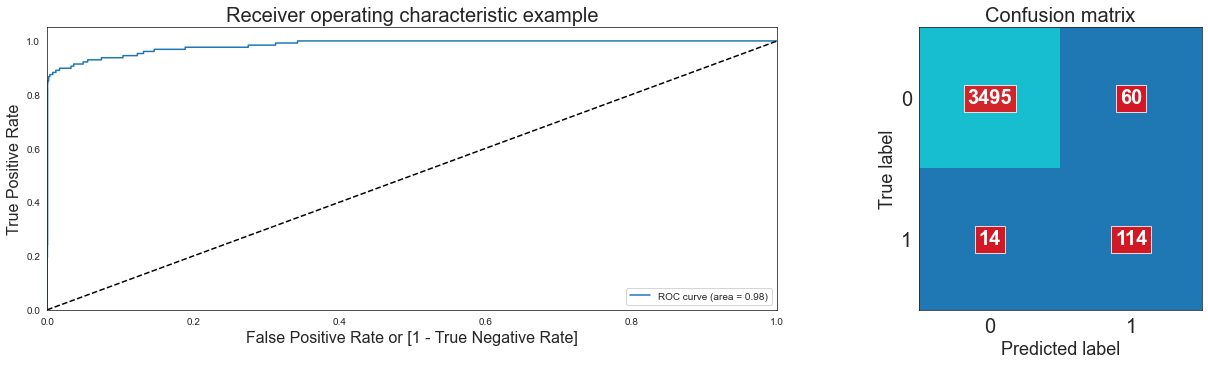

Running Model glm
Important Variables Identified in RFE
[('Time', False, 2), ('V1', True, 1), ('V2', False, 13), ('V3', True, 1), ('V4', True, 1), ('V5', False, 4), ('V6', False, 8), ('V7', True, 1), ('V8', True, 1), ('V9', False, 5), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', True, 1), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', False, 15), ('V18', False, 7), ('V19', True, 1), ('V20', False, 16), ('V21', False, 6), ('V22', True, 1), ('V23', True, 1), ('V24', False, 12), ('V25', False, 14), ('V26', False, 11), ('V27', False, 10), ('V28', False, 9), ('Amount', False, 3)]
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.98  Threshold:0.06089


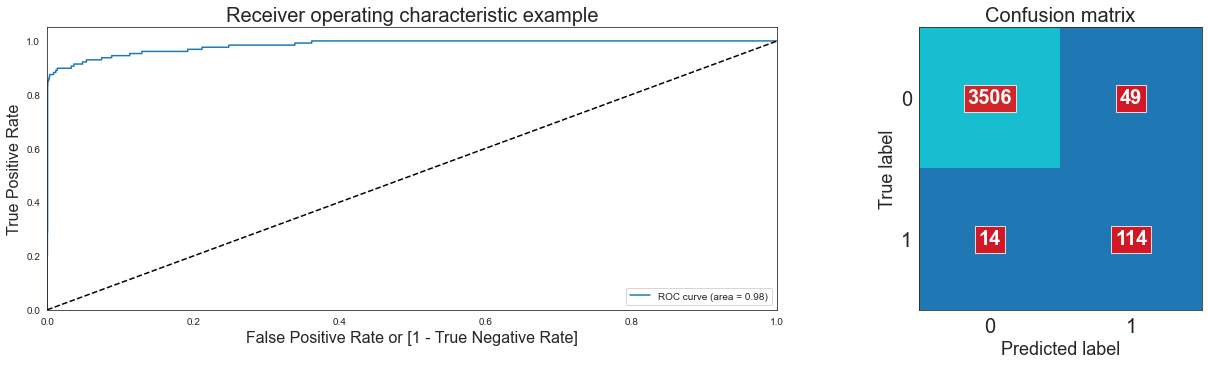

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Class   No. Observations:                11049
Model:                            GLM   Df Residuals:                    11033
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -318.40
Date:                Thu, 27 May 2021   Deviance:                       636.79
Time:                        19:55:07   Pearson chi2:                 2.64e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1825      0.228    -27.077      0.0

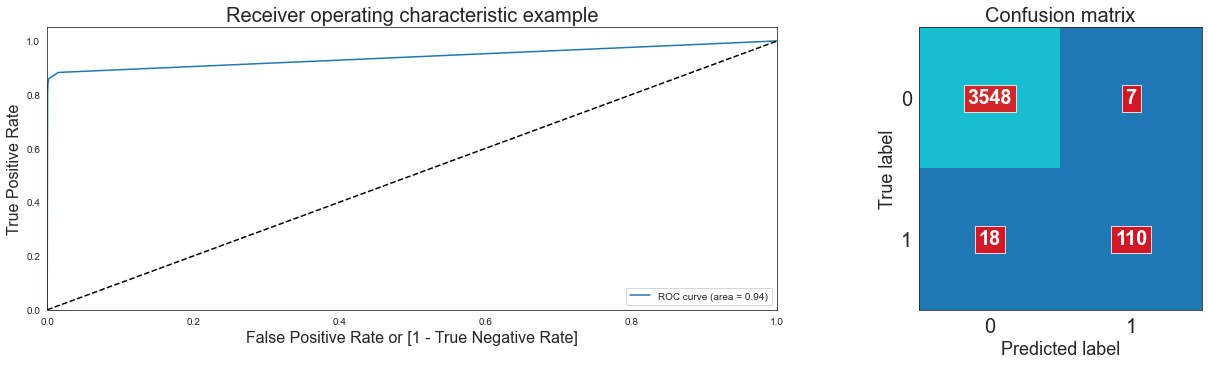

Running Model rfc
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.97  Threshold:0.02741


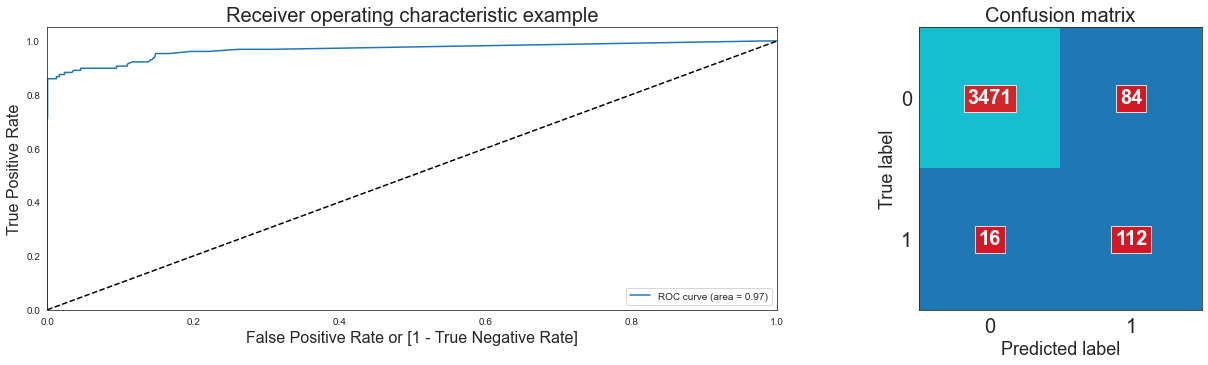

Running Model dtc
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.91  Threshold:1.00000


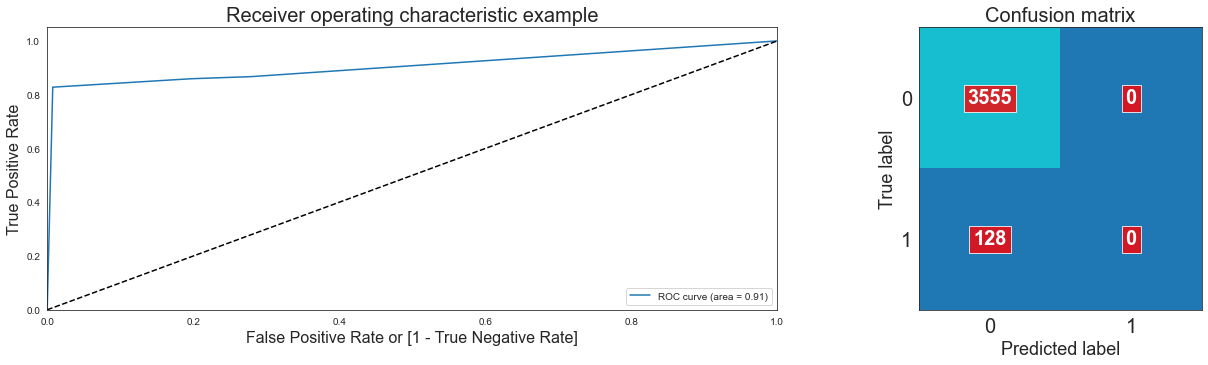

Running Model lgbm
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.98  Threshold:0.00190


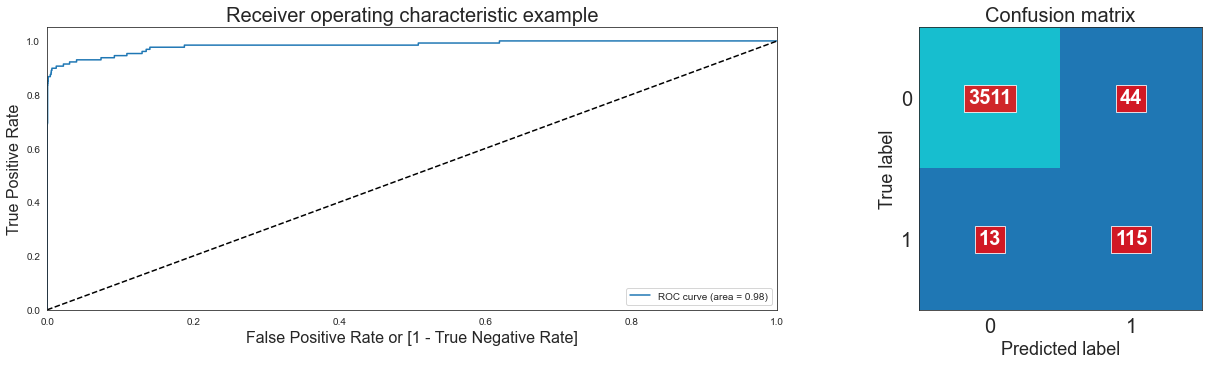

Running Model perceptron
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.9  Threshold:1.00000


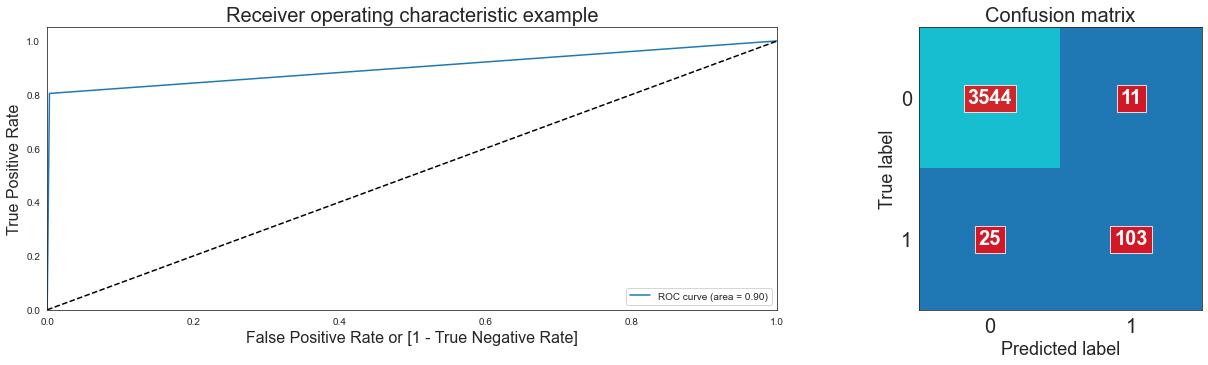

Running Model svc
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.99  Threshold:0.03384


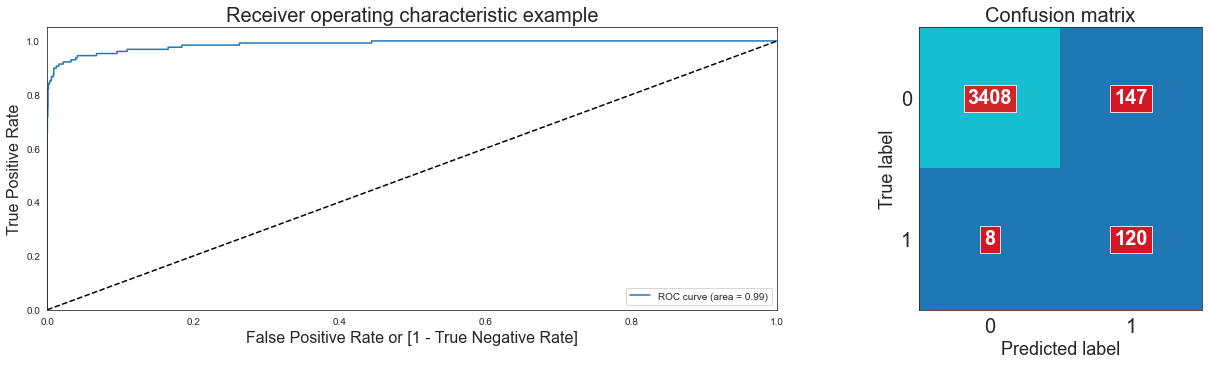

Running Model xgb
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.98  Threshold:0.49511


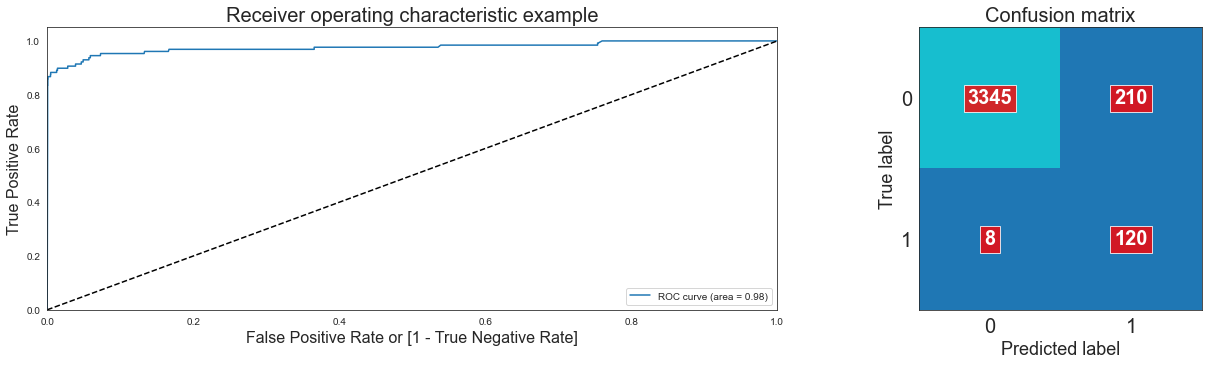

Running Model adaboost
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.98  Threshold:0.48240


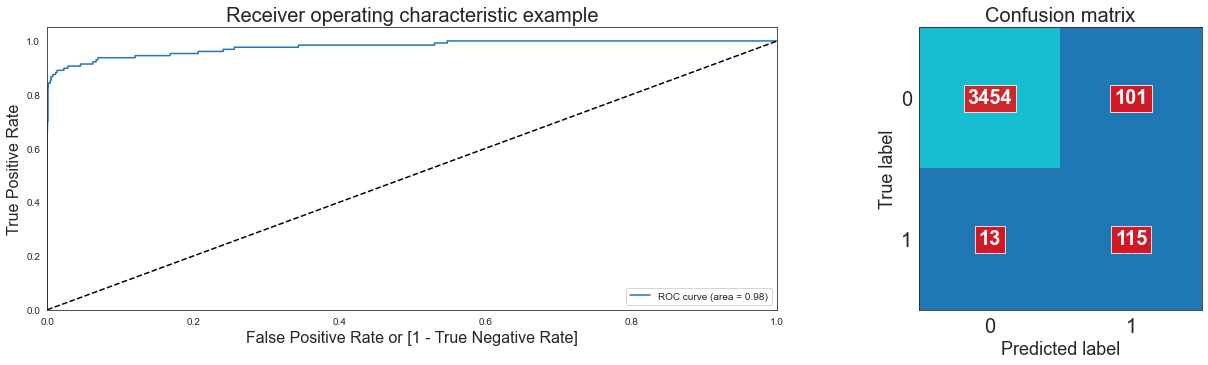

Running Model catboost
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.99  Threshold:0.00077


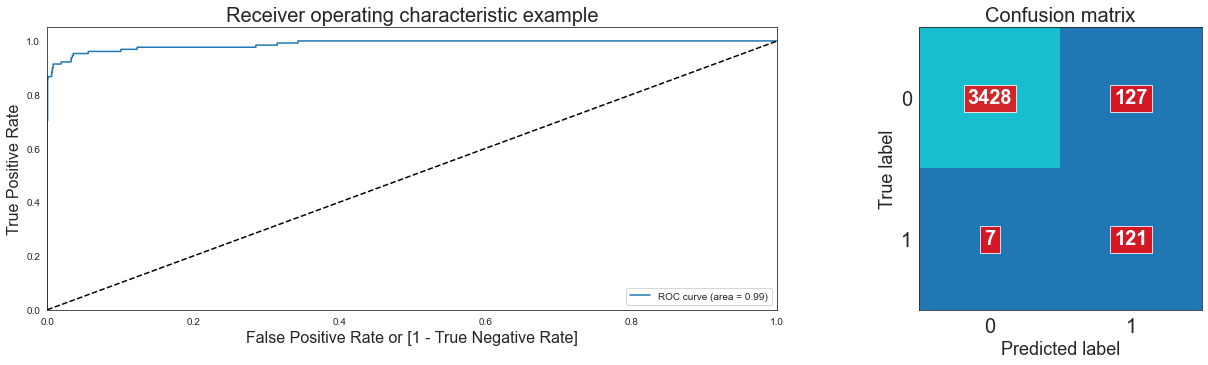

Running Model naiveb
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.97  Threshold:0.00339


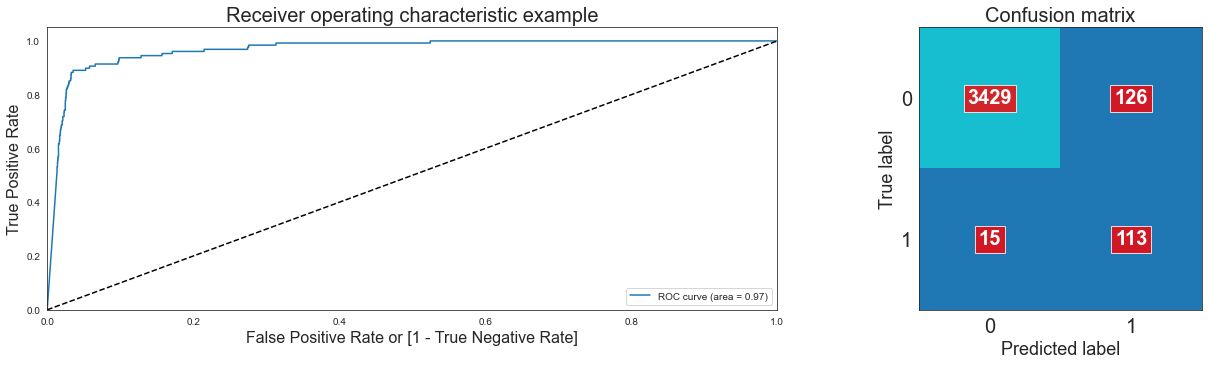

Running Model sgdc
This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.93  Threshold:1.00000


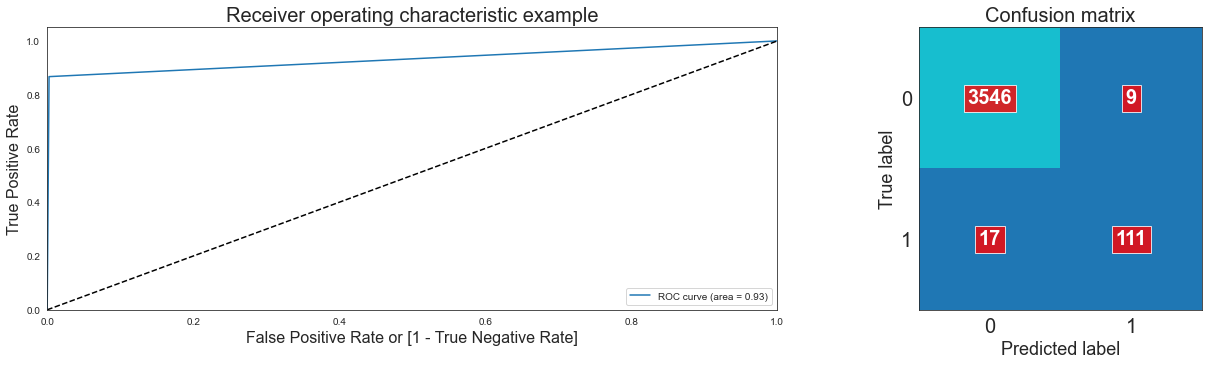

Running Model dnn
Epoch 1/50
111/111 [==============================] - 0s 1ms/step - loss: 0.4090 - accuracy: 0.8835
Epoch 2/50
111/111 [==============================] - 0s 2ms/step - loss: 0.1447 - accuracy: 0.9809
Epoch 3/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0849 - accuracy: 0.9852
Epoch 4/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0605 - accuracy: 0.9881
Epoch 5/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0538 - accuracy: 0.9892
Epoch 6/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0466 - accuracy: 0.9900
Epoch 7/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 0.9895
Epoch 8/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0421 - accuracy: 0.9909
Epoch 9/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0418 - accuracy: 0.9909
Epoch 10/50
111/111 [==============================] - 0s 1ms/step - loss: 0.0397 

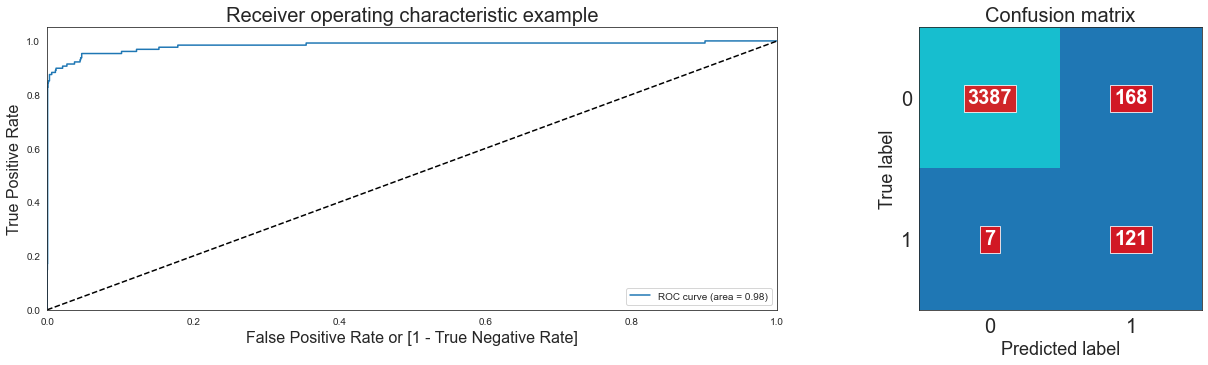

Running Model cnn
Epoch 1/50
3/3 [==============================] - 0s 86ms/step - loss: 0.7381 - accuracy: 0.5302
Epoch 2/50
3/3 [==============================] - 0s 75ms/step - loss: 0.5585 - accuracy: 0.7842
Epoch 3/50
3/3 [==============================] - 0s 83ms/step - loss: 0.4484 - accuracy: 0.8678
Epoch 4/50
3/3 [==============================] - 0s 79ms/step - loss: 0.3768 - accuracy: 0.9007
Epoch 5/50
3/3 [==============================] - 0s 79ms/step - loss: 0.3236 - accuracy: 0.9236
Epoch 6/50
3/3 [==============================] - 0s 80ms/step - loss: 0.2836 - accuracy: 0.9447
Epoch 7/50
3/3 [==============================] - 0s 76ms/step - loss: 0.2531 - accuracy: 0.9540
Epoch 8/50
3/3 [==============================] - 0s 77ms/step - loss: 0.2292 - accuracy: 0.9600
Epoch 9/50
3/3 [==============================] - 0s 85ms/step - loss: 0.2092 - accuracy: 0.9650
Epoch 10/50
3/3 [==============================] - 0s 80ms/step - loss: 0.1936 - accuracy: 0.9677
Epoch 11/50

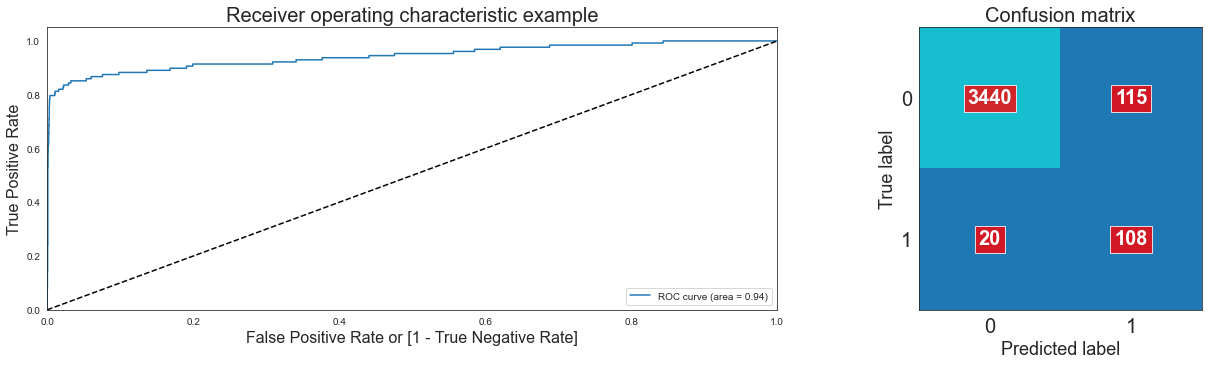

In [85]:
#options = ['0-Normal', '1-RandomOverSampler', '2-Smote', '3-AdaSyn']
option=0
X_train, X_test, y_train, y_test = select_dataset(option)
run_all_models(option)



Running Model with ** RandomOverSampler Data
Transaction Records in Train 21330
Transaction Records in Test 3683
Total Fraud Transaction Records 10793
Fraud Transaction Records in Train 10665
Fraud Transaction Records in Test 128
Running Model logistic
Important Variables Identified in RFE
[('Time', True, 1), ('V1', False, 13), ('V2', False, 8), ('V3', True, 1), ('V4', True, 1), ('V5', False, 4), ('V6', False, 6), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 7), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', False, 3), ('V18', False, 10), ('V19', False, 12), ('V20', False, 15), ('V21', True, 1), ('V22', True, 1), ('V23', True, 1), ('V24', False, 14), ('V25', False, 2), ('V26', True, 1), ('V27', False, 16), ('V28', False, 9), ('Amount', False, 5)]
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.98  Threshold:0.67212


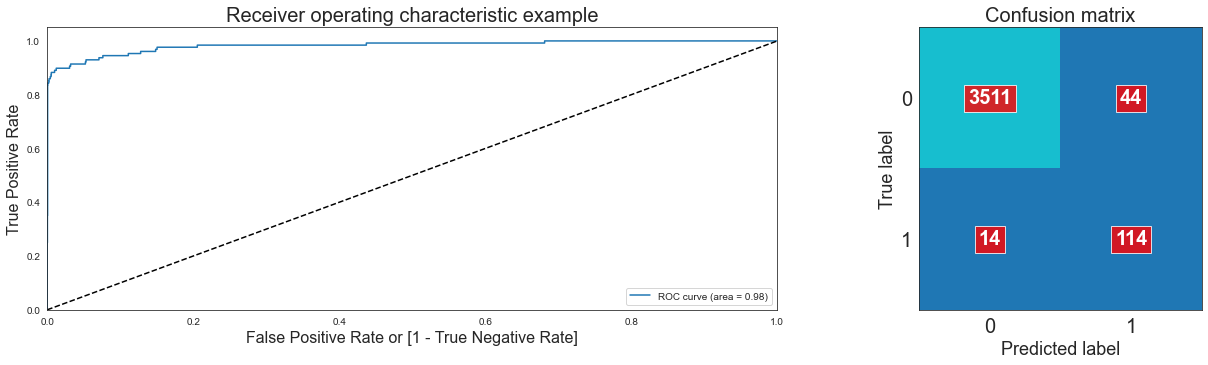

Running Model glm
Important Variables Identified in RFE
[('Time', True, 1), ('V1', False, 13), ('V2', False, 8), ('V3', True, 1), ('V4', True, 1), ('V5', False, 4), ('V6', False, 6), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 7), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', False, 3), ('V18', False, 10), ('V19', False, 12), ('V20', False, 15), ('V21', True, 1), ('V22', True, 1), ('V23', True, 1), ('V24', False, 14), ('V25', False, 2), ('V26', True, 1), ('V27', False, 16), ('V28', False, 9), ('Amount', False, 5)]
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.98  Threshold:0.67810


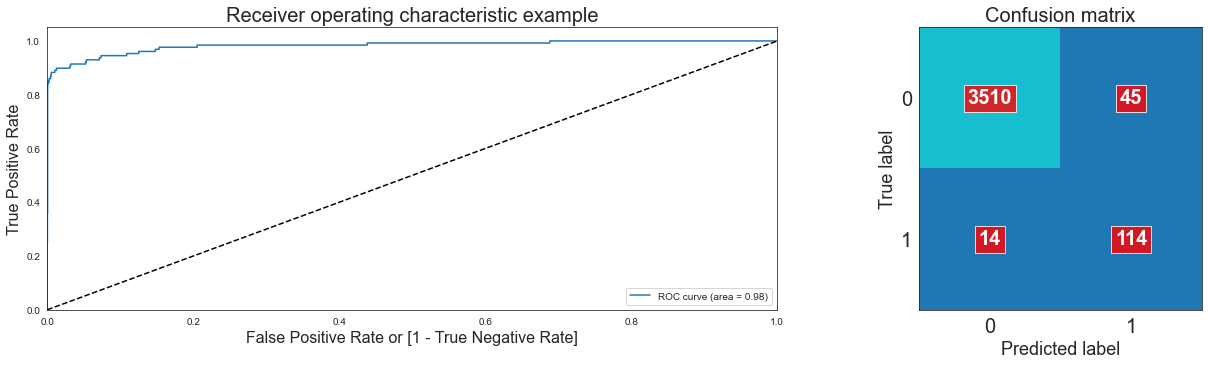

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Class   No. Observations:                21330
Model:                            GLM   Df Residuals:                    21314
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2999.7
Date:                Thu, 27 May 2021   Deviance:                       5999.4
Time:                        20:00:52   Pearson chi2:                 8.78e+07
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0169      0.054    -55.994      0.0

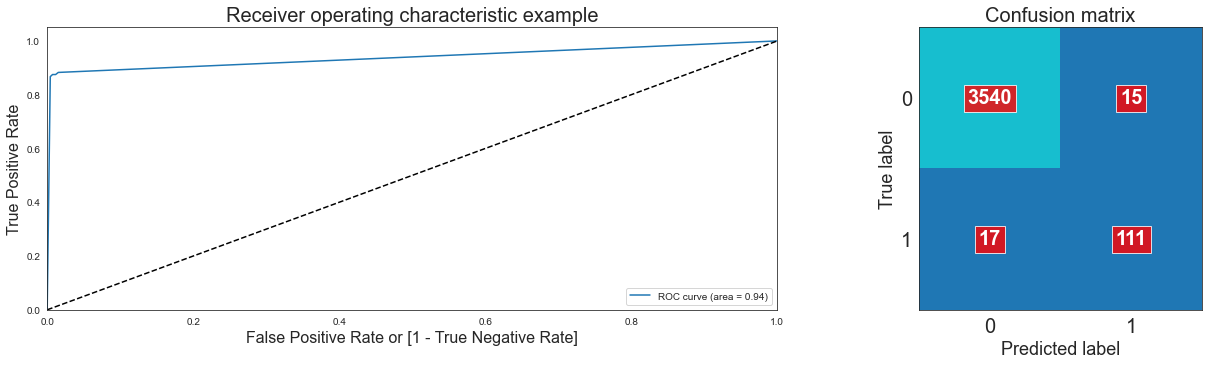

Running Model rfc
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.97  Threshold:0.32756


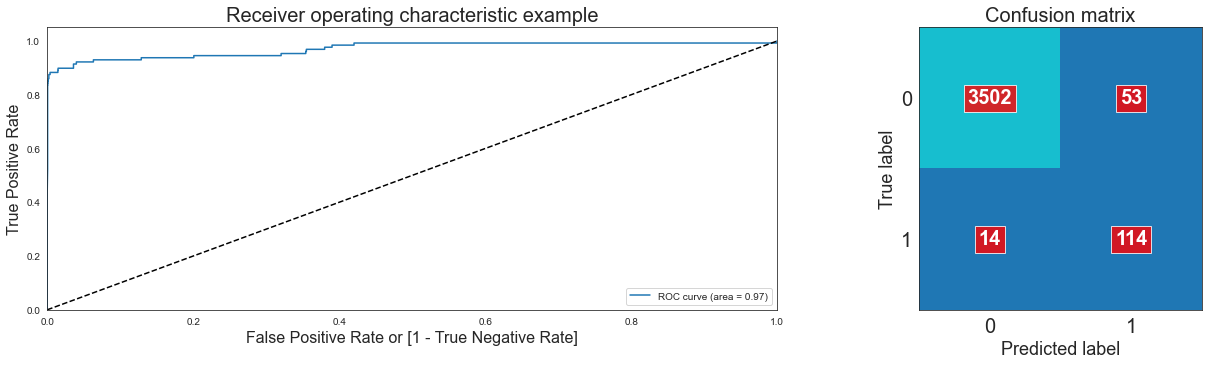

Running Model dtc
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.89  Threshold:0.97285


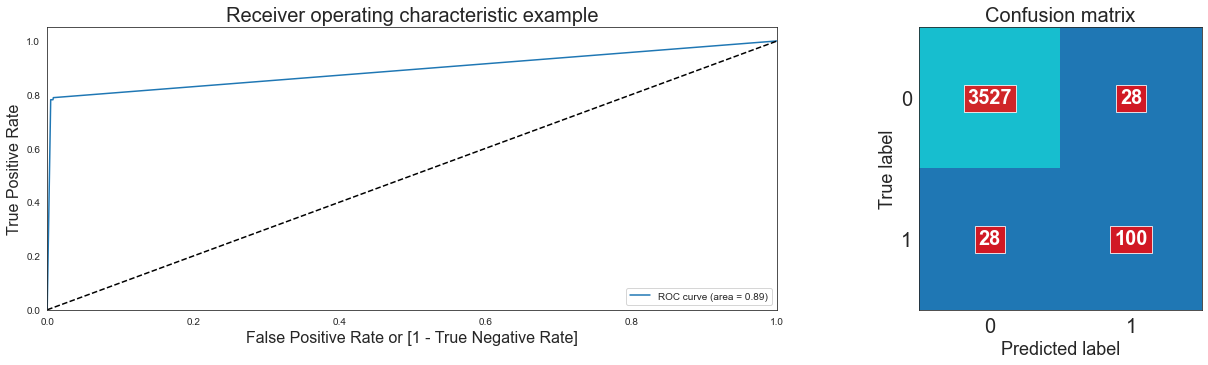

Running Model lgbm
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.99  Threshold:0.00574


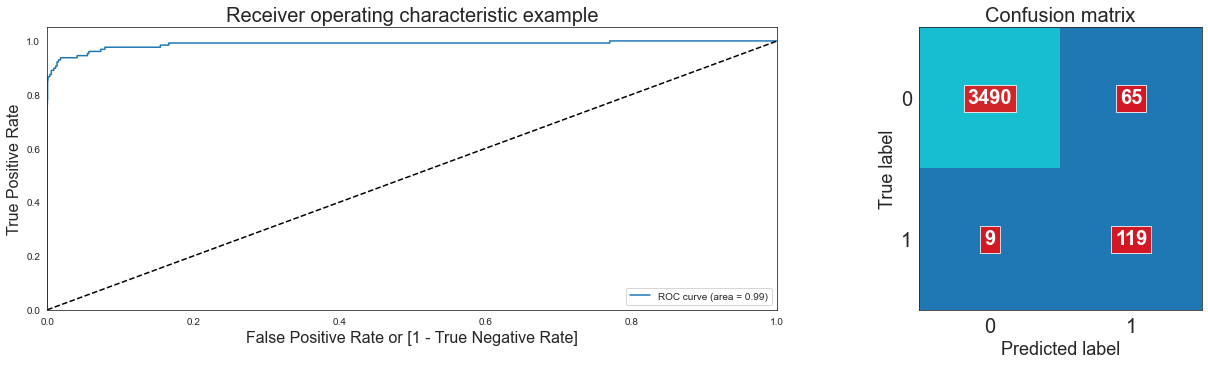

Running Model perceptron
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.89  Threshold:1.00000


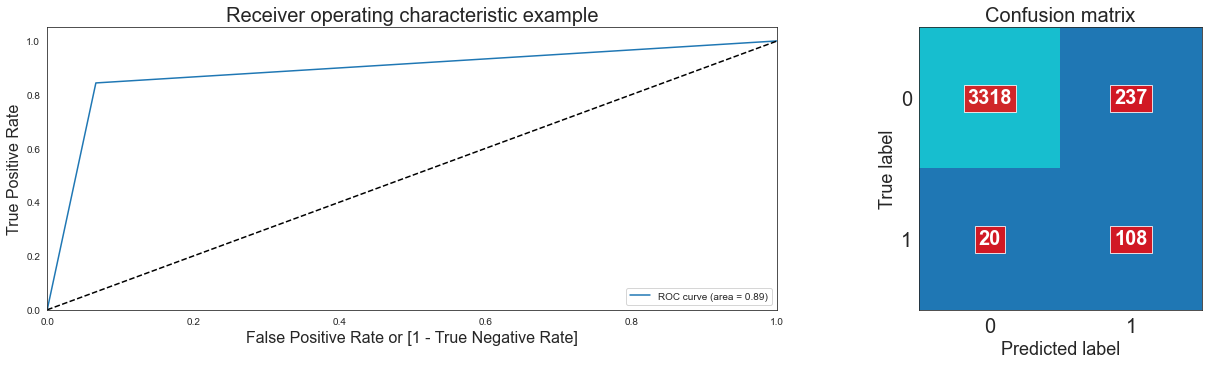

Running Model svc
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.97  Threshold:0.01009


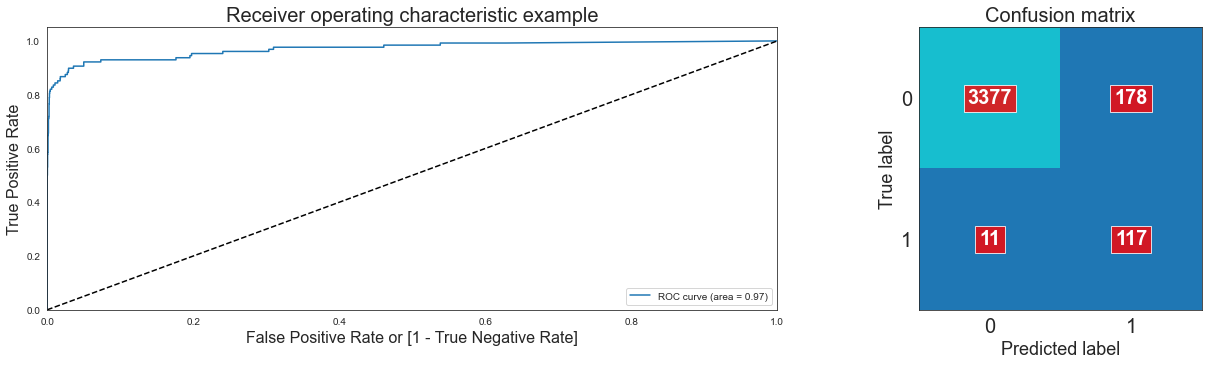

Running Model xgb
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.97  Threshold:0.49677


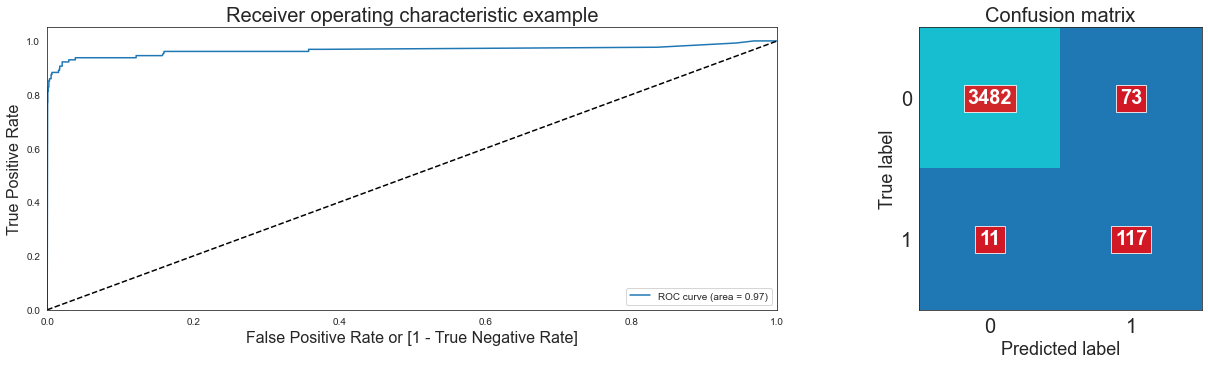

Running Model adaboost
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.98  Threshold:0.49931


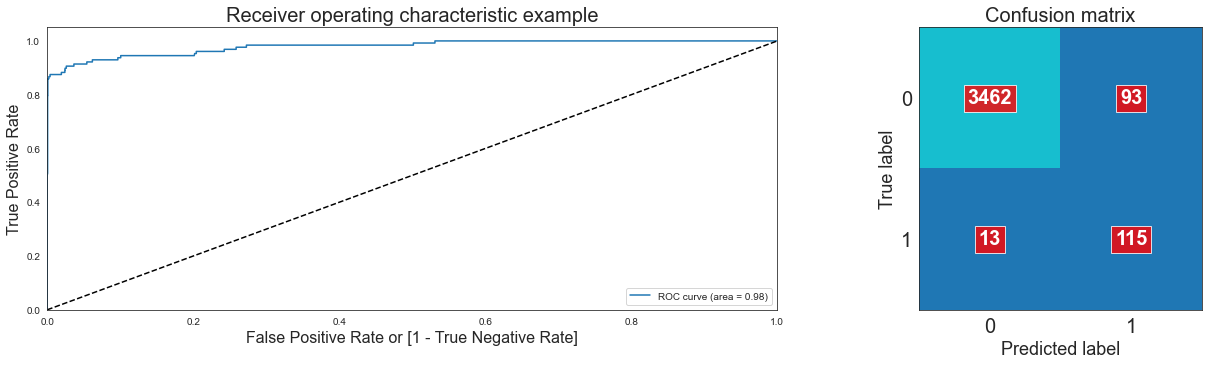

Running Model catboost
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.96  Threshold:0.03433


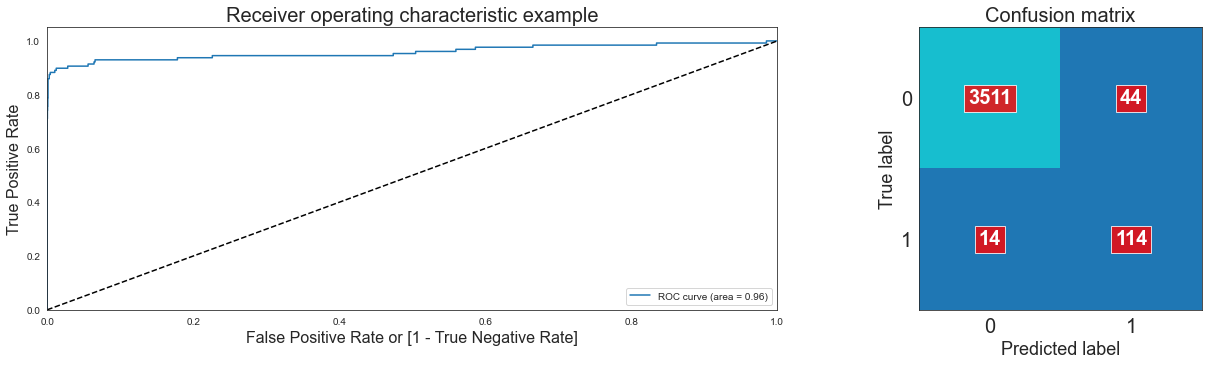

Running Model naiveb
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.97  Threshold:0.09239


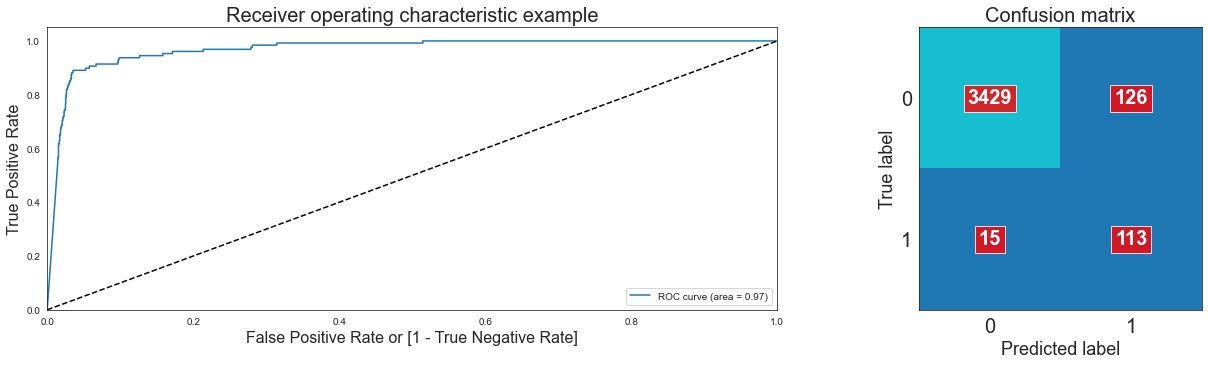

Running Model sgdc
This Model Result is for  RandomOverSampler  Data
ROC AUC Score on Test: 0.94  Threshold:1.00000


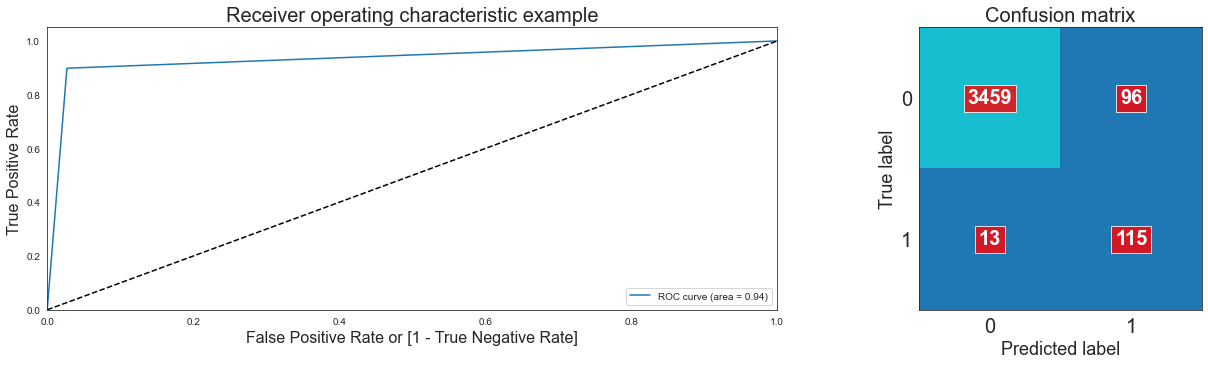

Running Model dnn
Epoch 1/50
214/214 [==============================] - 0s 1ms/step - loss: 0.3584 - accuracy: 0.8491
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9388
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1450 - accuracy: 0.9475
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.9501
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1207 - accuracy: 0.9527
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.9588
Epoch 7/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1018 - accuracy: 0.9605
Epoch 8/50
214/214 [==============================] - 0s 2ms/step - loss: 0.0925 - accuracy: 0.9652
Epoch 9/50
214/214 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.9669
Epoch 10/50
214/214 [==============================] - 0s 2ms/step - loss: 0.0845 

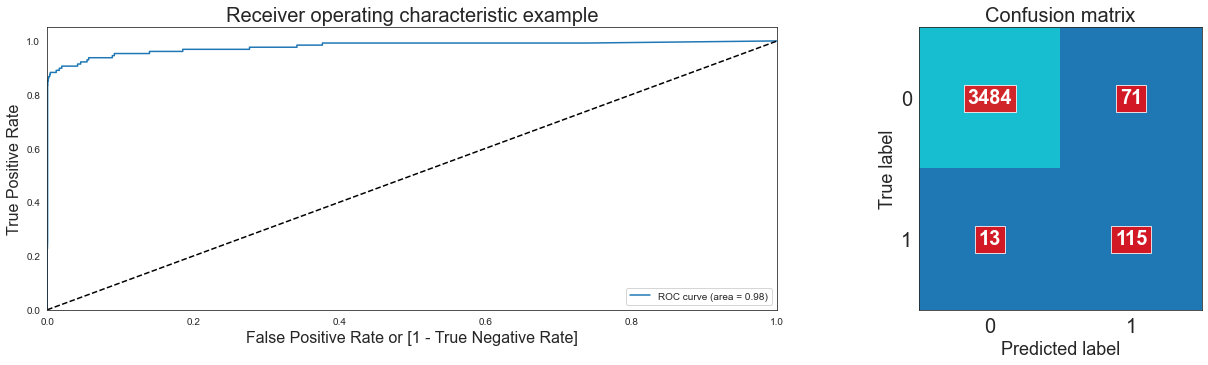

Running Model cnn
Epoch 1/50
5/5 [==============================] - 1s 134ms/step - loss: 0.6206 - accuracy: 0.6906
Epoch 2/50
5/5 [==============================] - 1s 149ms/step - loss: 0.4045 - accuracy: 0.8601
Epoch 3/50
5/5 [==============================] - 1s 149ms/step - loss: 0.3710 - accuracy: 0.8573
Epoch 4/50
5/5 [==============================] - 1s 152ms/step - loss: 0.3536 - accuracy: 0.8725
Epoch 5/50
5/5 [==============================] - 1s 146ms/step - loss: 0.3313 - accuracy: 0.8886
Epoch 6/50
5/5 [==============================] - 1s 145ms/step - loss: 0.3107 - accuracy: 0.8998
Epoch 7/50
5/5 [==============================] - 1s 151ms/step - loss: 0.2959 - accuracy: 0.9039
Epoch 8/50
5/5 [==============================] - 1s 145ms/step - loss: 0.2855 - accuracy: 0.9042
Epoch 9/50
5/5 [==============================] - 1s 148ms/step - loss: 0.2769 - accuracy: 0.9050
Epoch 10/50
5/5 [==============================] - 1s 154ms/step - loss: 0.2690 - accuracy: 0.9070
E

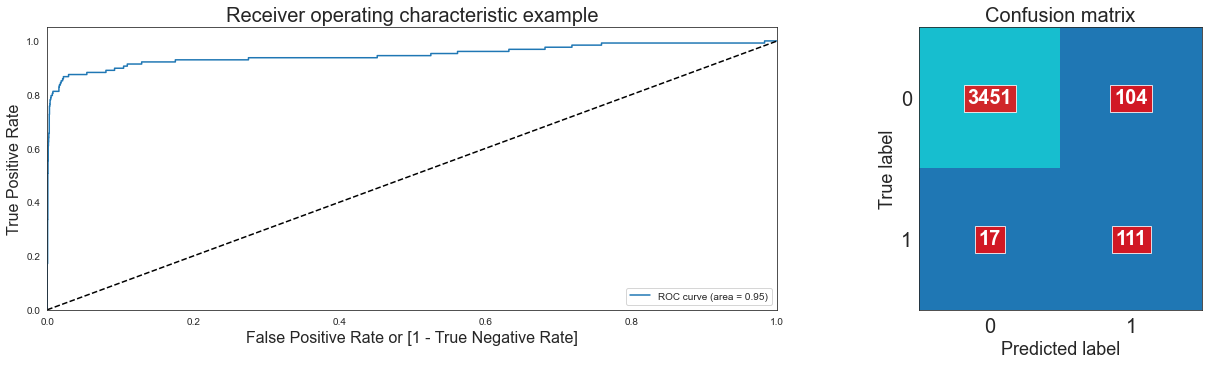

In [88]:
#options = ['0-Normal', '1-RandomOverSampler', '2-Smote', '3-AdaSyn']
option=1
X_train, X_test, y_train, y_test = select_dataset(option)
run_all_models(option)



Running Model with ** Smote Data
Transaction Records in Train 21330
Transaction Records in Test 3683
Total Fraud Transaction Records 10793
Fraud Transaction Records in Train 10665
Fraud Transaction Records in Test 128
Running Model logistic
Important Variables Identified in RFE
[('Time', True, 1), ('V1', False, 9), ('V2', False, 4), ('V3', True, 1), ('V4', True, 1), ('V5', False, 5), ('V6', True, 1), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 14), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', True, 1), ('V18', False, 8), ('V19', False, 15), ('V20', False, 12), ('V21', False, 7), ('V22', True, 1), ('V23', False, 2), ('V24', False, 16), ('V25', False, 3), ('V26', True, 1), ('V27', False, 13), ('V28', False, 6), ('Amount', False, 10)]
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.99  Threshold:0.35791


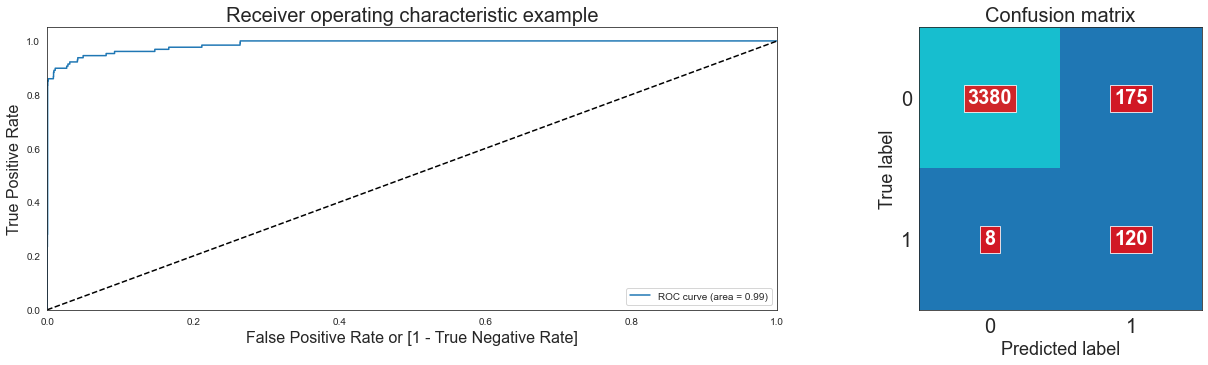

Running Model glm
Important Variables Identified in RFE
[('Time', True, 1), ('V1', False, 9), ('V2', False, 4), ('V3', True, 1), ('V4', True, 1), ('V5', False, 5), ('V6', True, 1), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 14), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', True, 1), ('V18', False, 8), ('V19', False, 15), ('V20', False, 12), ('V21', False, 7), ('V22', True, 1), ('V23', False, 2), ('V24', False, 16), ('V25', False, 3), ('V26', True, 1), ('V27', False, 13), ('V28', False, 6), ('Amount', False, 10)]
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.99  Threshold:0.36805


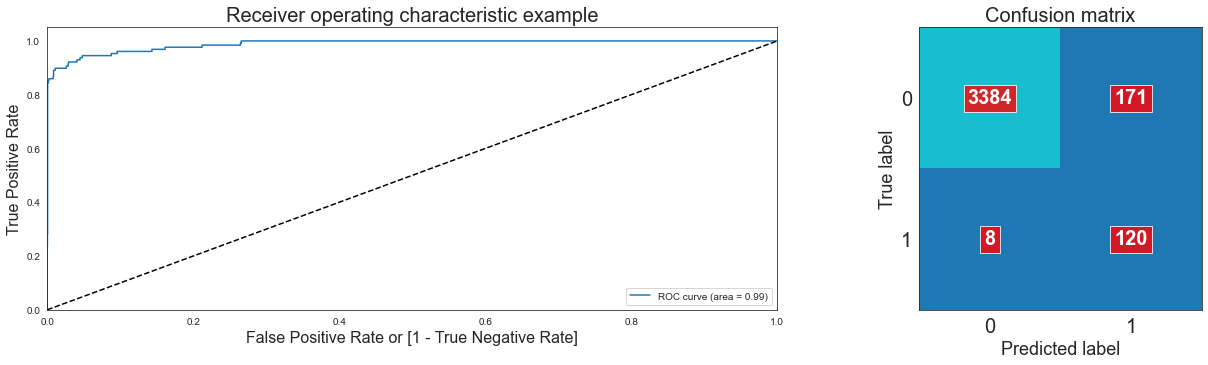

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Class   No. Observations:                21330
Model:                            GLM   Df Residuals:                    21314
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2899.4
Date:                Thu, 27 May 2021   Deviance:                       5798.9
Time:                        19:56:22   Pearson chi2:                 3.19e+10
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0281      0.055    -55.003      0.0

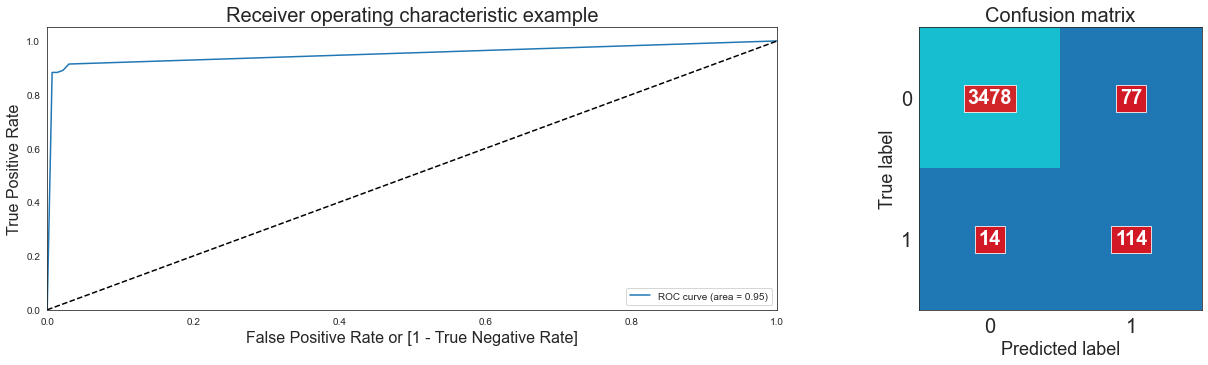

Running Model rfc
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.98  Threshold:0.29101


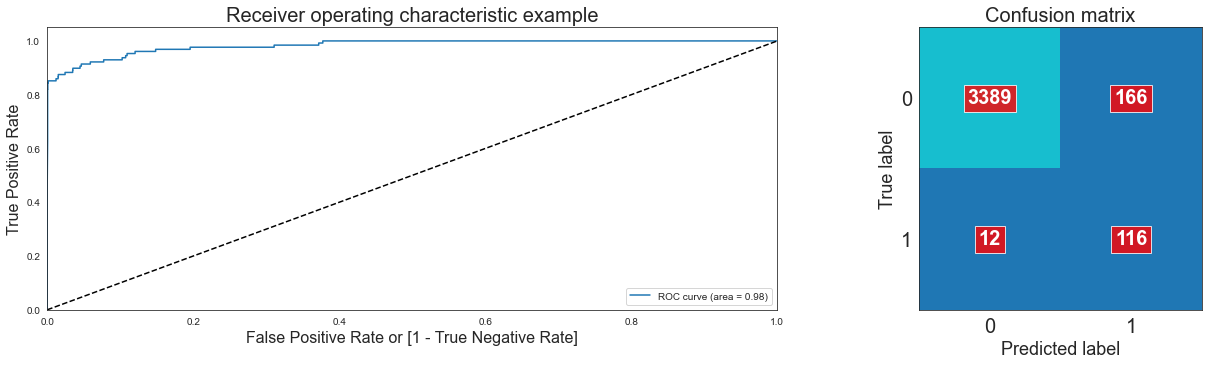

Running Model dtc
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.93  Threshold:1.00000


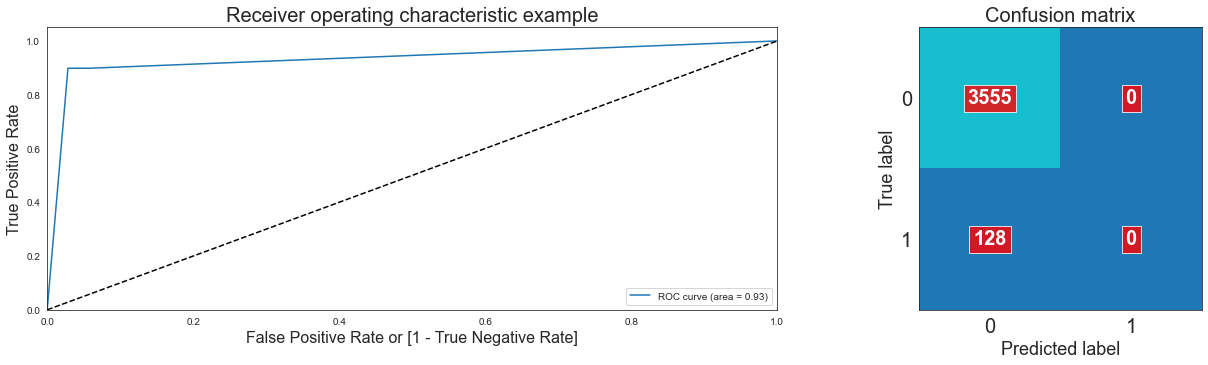

Running Model lgbm
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.99  Threshold:0.03273


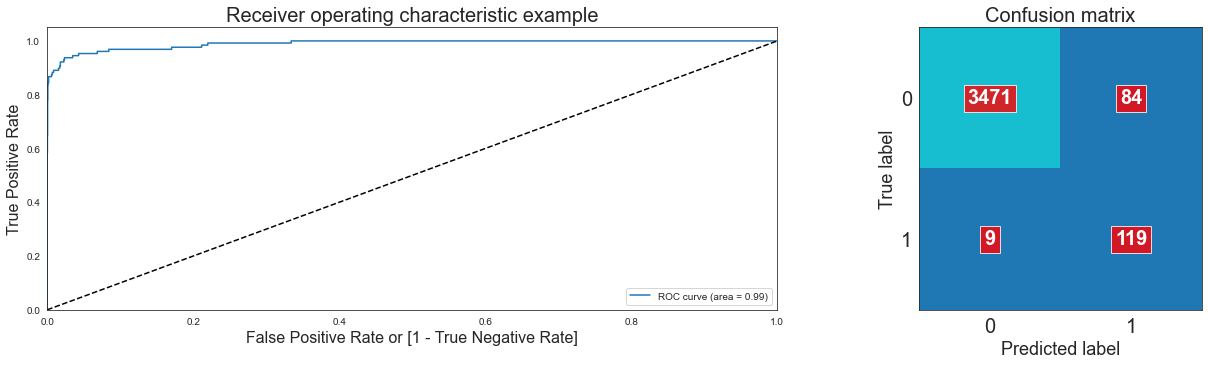

Running Model perceptron
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.9  Threshold:1.00000


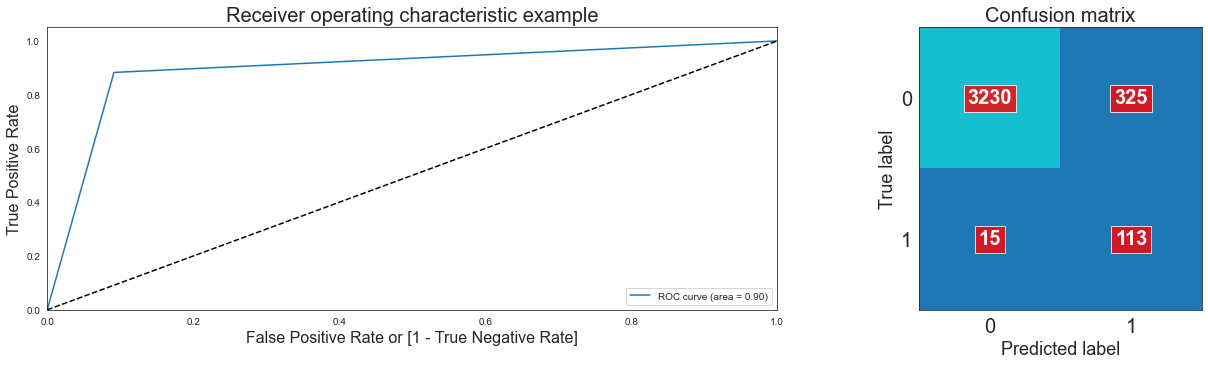

Running Model svc
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.96  Threshold:0.15103


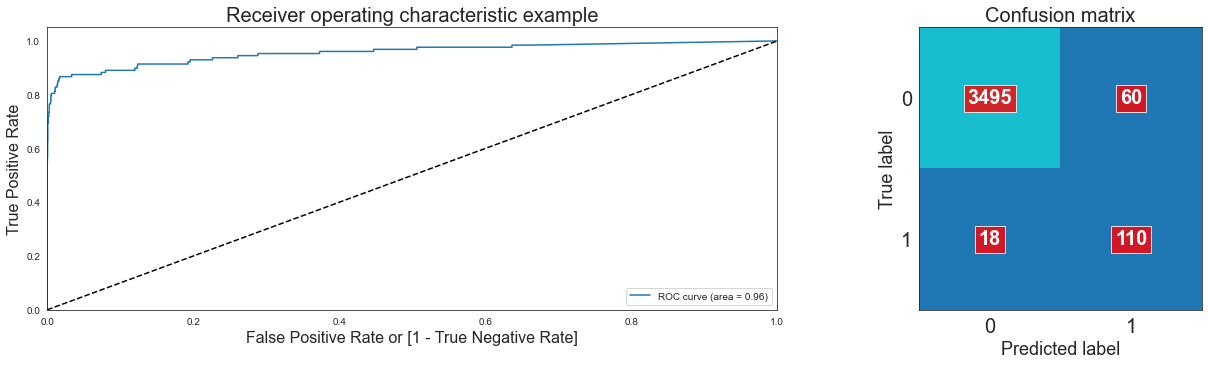

Running Model xgb
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.99  Threshold:0.49774


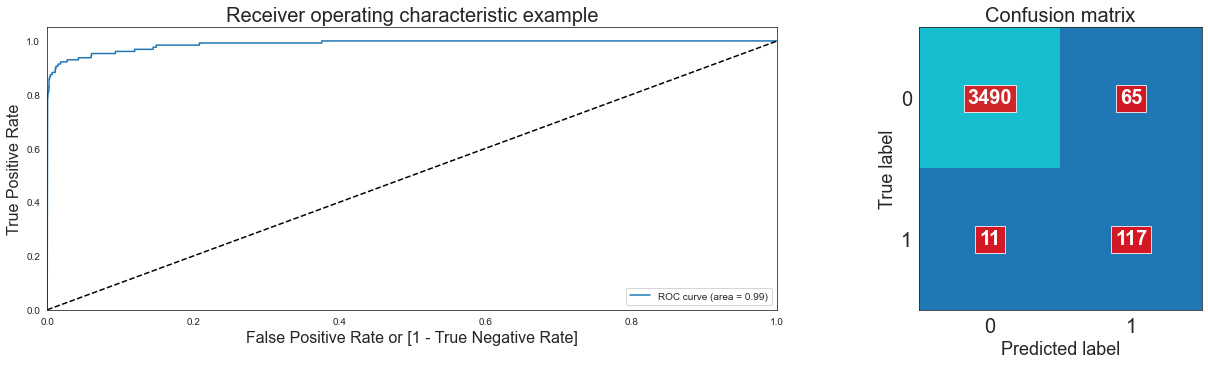

Running Model adaboost
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.98  Threshold:0.50451


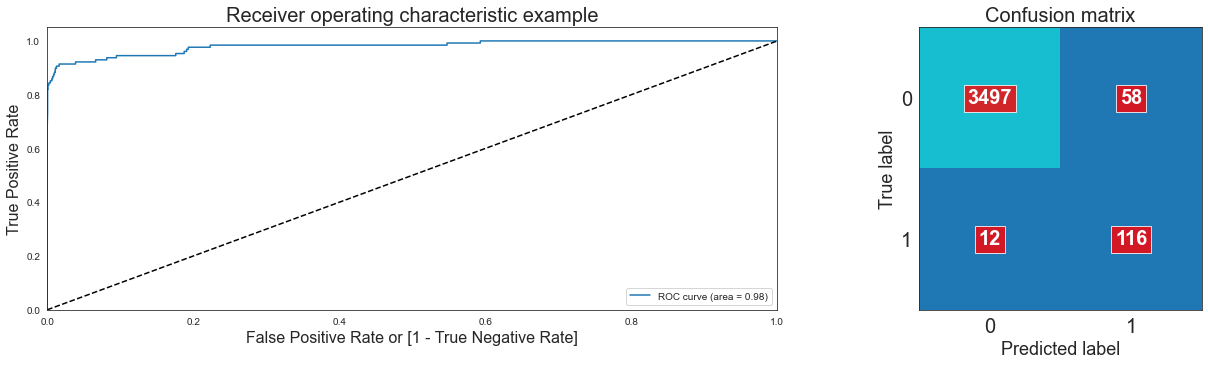

Running Model catboost
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.98  Threshold:0.01107


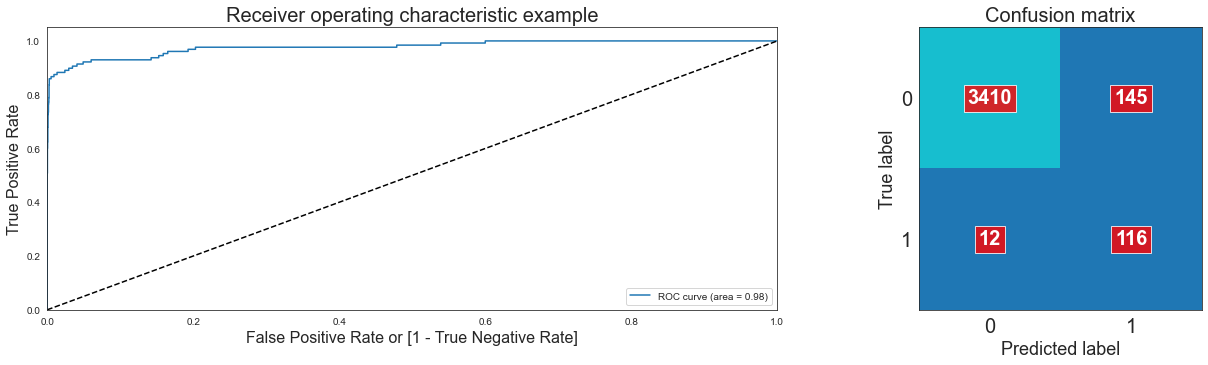

Running Model naiveb
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.97  Threshold:0.07338


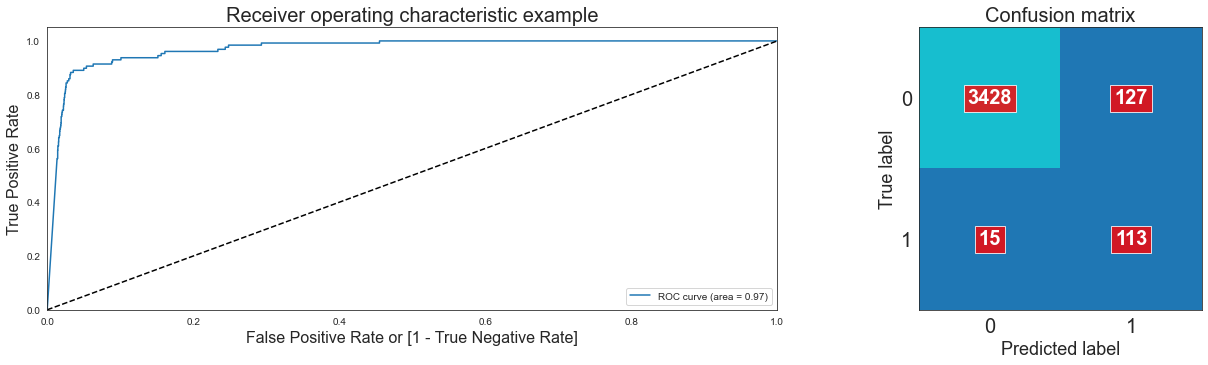

Running Model sgdc
This Model Result is for  Smote  Data
ROC AUC Score on Test: 0.94  Threshold:1.00000


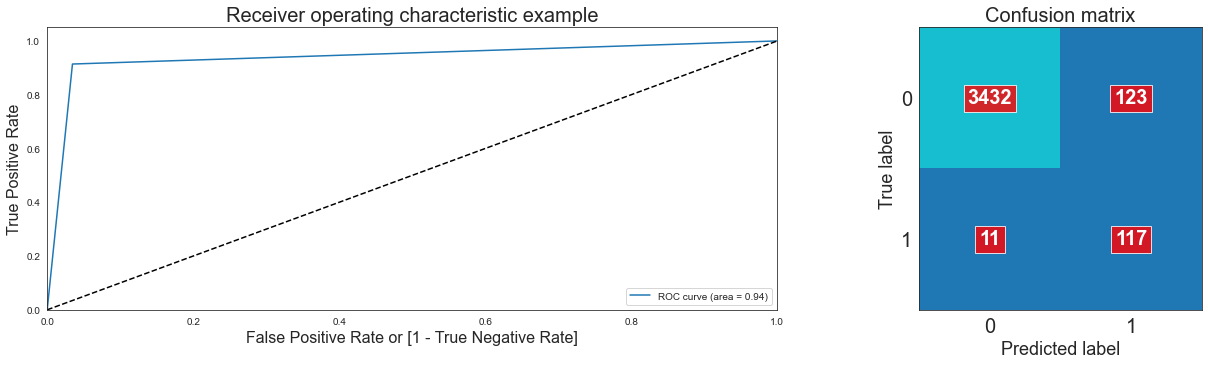

Running Model dnn
Epoch 1/50
214/214 [==============================] - 0s 1ms/step - loss: 0.5513 - accuracy: 0.7545
Epoch 2/50
214/214 [==============================] - 0s 1ms/step - loss: 0.2047 - accuracy: 0.9249
Epoch 3/50
214/214 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.9438: 0s - loss: 0.1574 - accuracy: 
Epoch 4/50
214/214 [==============================] - 0s 1ms/step - loss: 0.1338 - accuracy: 0.9483
Epoch 5/50
214/214 [==============================] - 0s 1ms/step - loss: 0.1218 - accuracy: 0.9508
Epoch 6/50
214/214 [==============================] - 0s 1ms/step - loss: 0.1123 - accuracy: 0.9543
Epoch 7/50
214/214 [==============================] - 0s 1ms/step - loss: 0.1038 - accuracy: 0.9595
Epoch 8/50
214/214 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9621
Epoch 9/50
214/214 [==============================] - 0s 1ms/step - loss: 0.0897 - accuracy: 0.9665
Epoch 10/50
214/214 [=============================

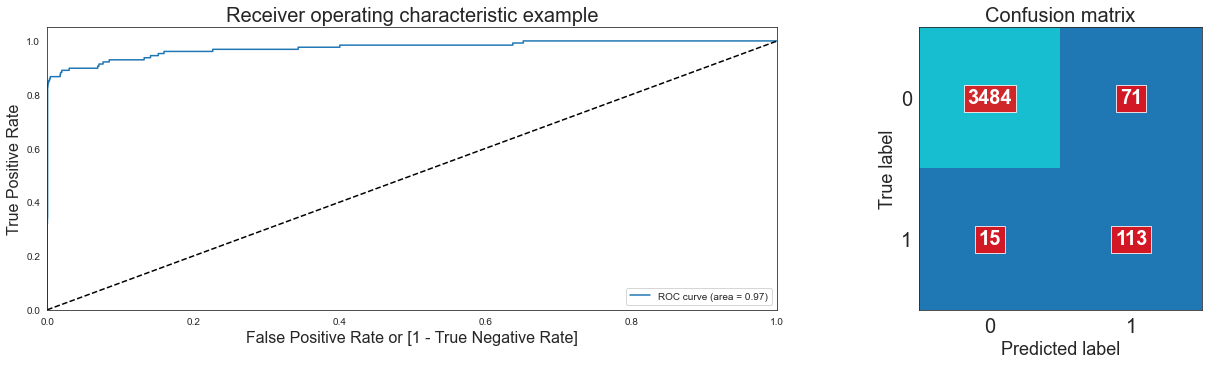

Running Model cnn
Epoch 1/50
5/5 [==============================] - 1s 122ms/step - loss: 0.5858 - accuracy: 0.7110
Epoch 2/50
5/5 [==============================] - 1s 130ms/step - loss: 0.4472 - accuracy: 0.8067
Epoch 3/50
5/5 [==============================] - 1s 130ms/step - loss: 0.4125 - accuracy: 0.8284
Epoch 4/50
5/5 [==============================] - 1s 132ms/step - loss: 0.3796 - accuracy: 0.8704
Epoch 5/50
5/5 [==============================] - 1s 134ms/step - loss: 0.3520 - accuracy: 0.8937
Epoch 6/50
5/5 [==============================] - 1s 129ms/step - loss: 0.3340 - accuracy: 0.9015
Epoch 7/50
5/5 [==============================] - 1s 132ms/step - loss: 0.3188 - accuracy: 0.9034
Epoch 8/50
5/5 [==============================] - 1s 135ms/step - loss: 0.3049 - accuracy: 0.9049
Epoch 9/50
5/5 [==============================] - 1s 133ms/step - loss: 0.2942 - accuracy: 0.9063
Epoch 10/50
5/5 [==============================] - 1s 132ms/step - loss: 0.2847 - accuracy: 0.9083
E

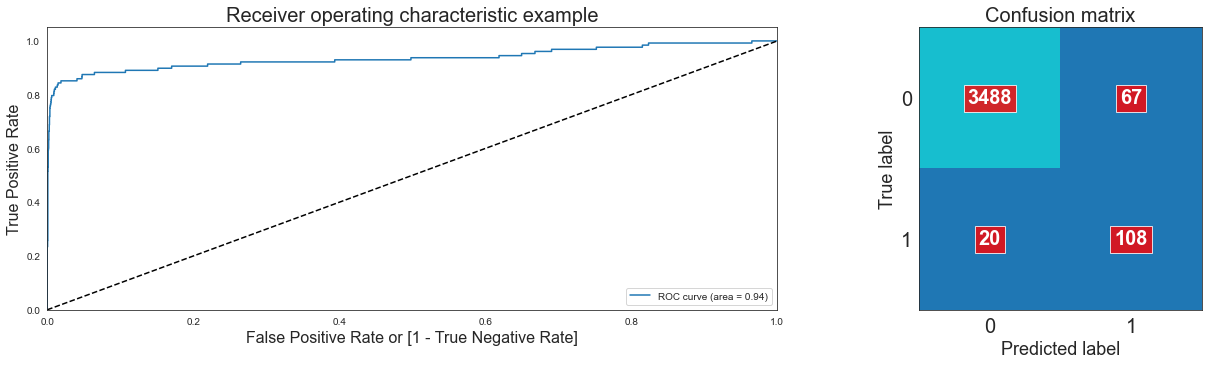

In [86]:
#options = ['0-Normal', '1-RandomOverSampler', '2-Smote', '3-AdaSyn']
option=2
X_train, X_test, y_train, y_test = select_dataset(option)
run_all_models(option)



Running Model with ** AdaSyn Data
Transaction Records in Train 21323
Transaction Records in Test 3683
Total Fraud Transaction Records 10786
Fraud Transaction Records in Train 10658
Fraud Transaction Records in Test 128
Running Model logistic
Important Variables Identified in RFE
[('Time', True, 1), ('V1', False, 6), ('V2', False, 4), ('V3', True, 1), ('V4', True, 1), ('V5', False, 5), ('V6', True, 1), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 15), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', True, 1), ('V18', False, 9), ('V19', False, 12), ('V20', False, 10), ('V21', False, 8), ('V22', True, 1), ('V23', True, 1), ('V24', False, 14), ('V25', False, 3), ('V26', False, 2), ('V27', False, 13), ('V28', False, 7), ('Amount', False, 16)]
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.98  Threshold:0.95108


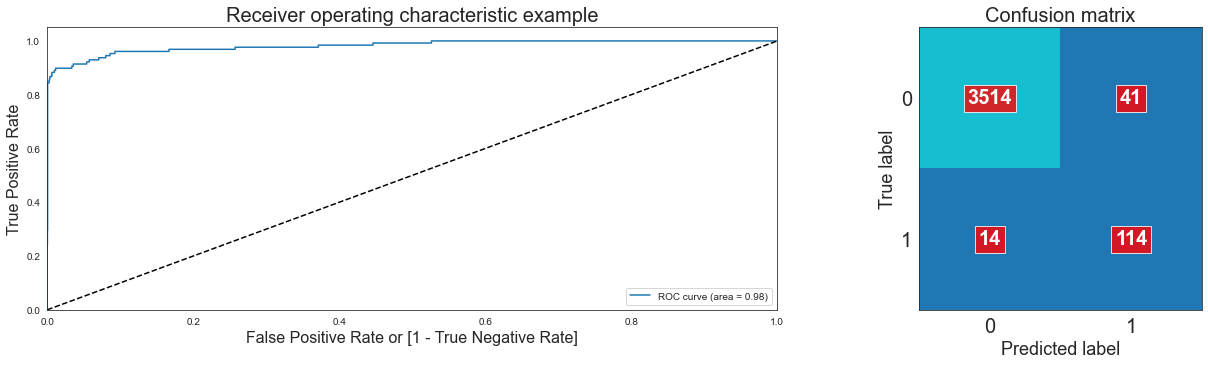

Running Model glm
Important Variables Identified in RFE
[('Time', True, 1), ('V1', False, 6), ('V2', False, 4), ('V3', True, 1), ('V4', True, 1), ('V5', False, 5), ('V6', True, 1), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 15), ('V14', True, 1), ('V15', True, 1), ('V16', True, 1), ('V17', True, 1), ('V18', False, 9), ('V19', False, 12), ('V20', False, 10), ('V21', False, 8), ('V22', True, 1), ('V23', True, 1), ('V24', False, 14), ('V25', False, 3), ('V26', False, 2), ('V27', False, 13), ('V28', False, 7), ('Amount', False, 16)]
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.98  Threshold:0.94700


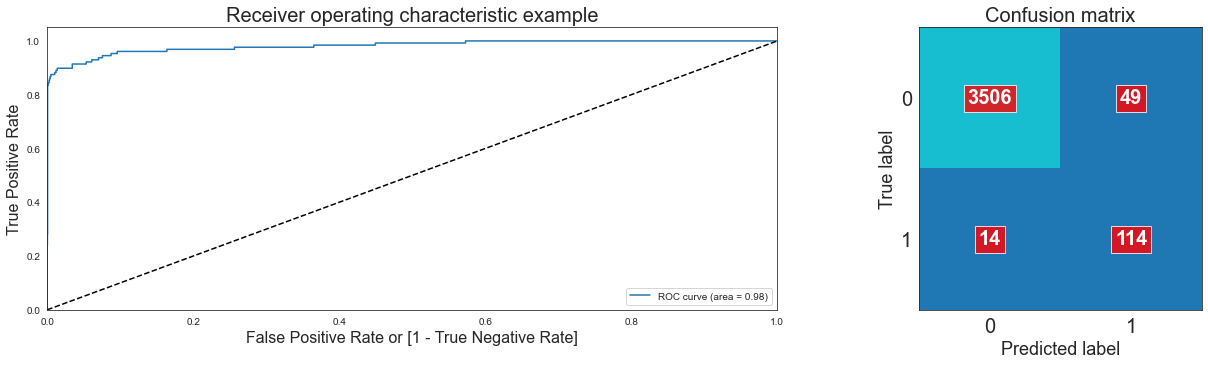

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Class   No. Observations:                21323
Model:                            GLM   Df Residuals:                    21307
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6612.3
Date:                Thu, 27 May 2021   Deviance:                       13225.
Time:                        19:58:24   Pearson chi2:                 4.50e+15
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6166      0.032    -50.209      0.0

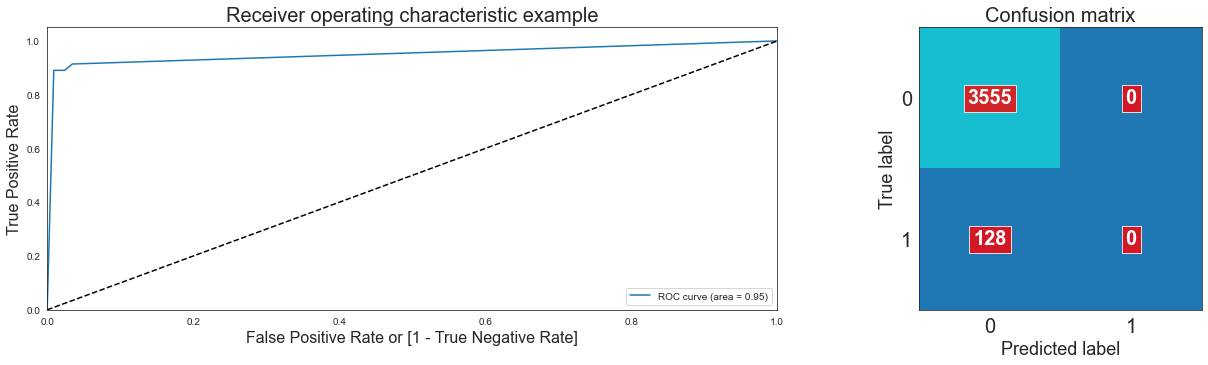

Running Model rfc
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.99  Threshold:0.39530


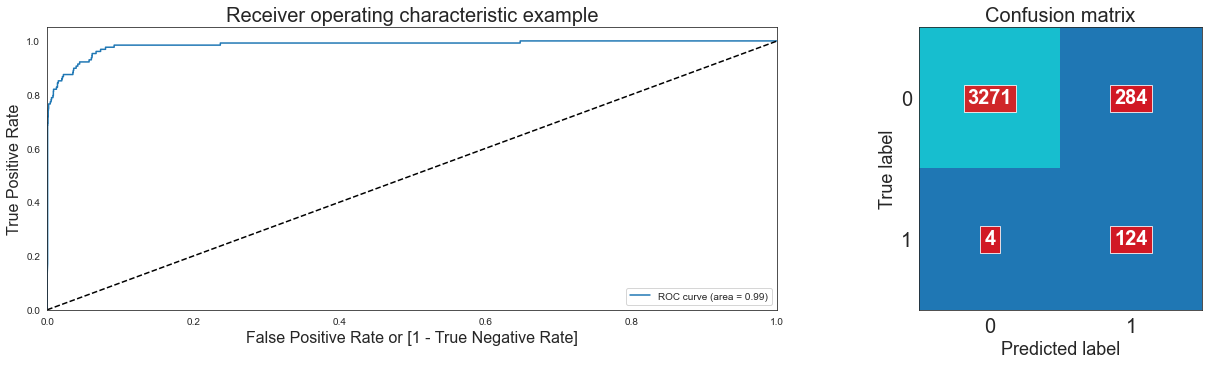

Running Model dtc
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.92  Threshold:0.97471


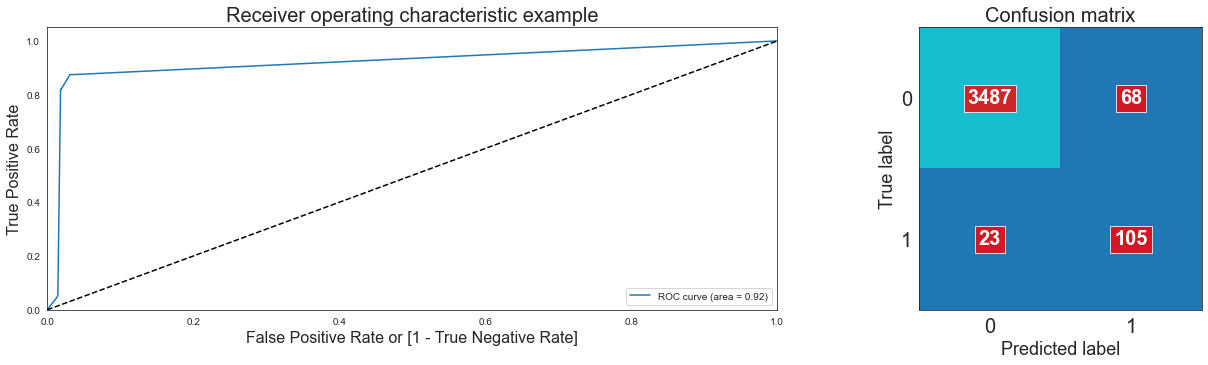

Running Model lgbm
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.99  Threshold:0.05706


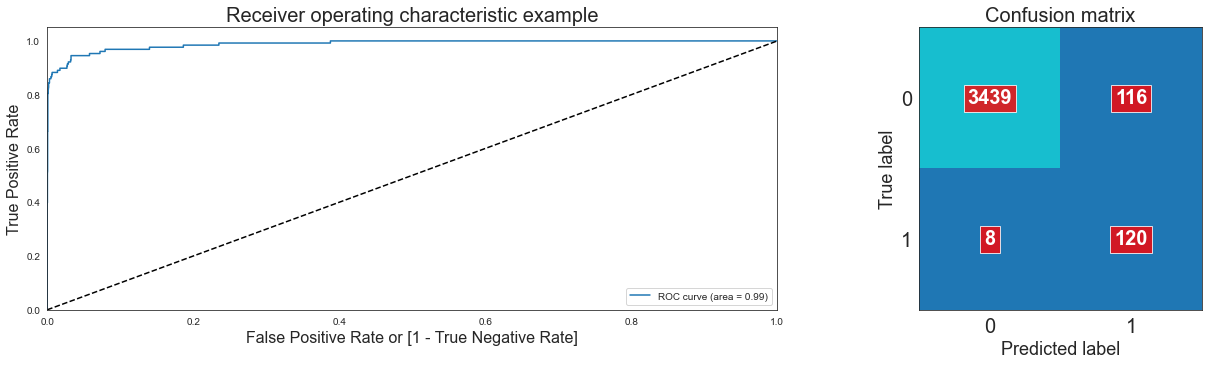

Running Model perceptron
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.91  Threshold:1.00000


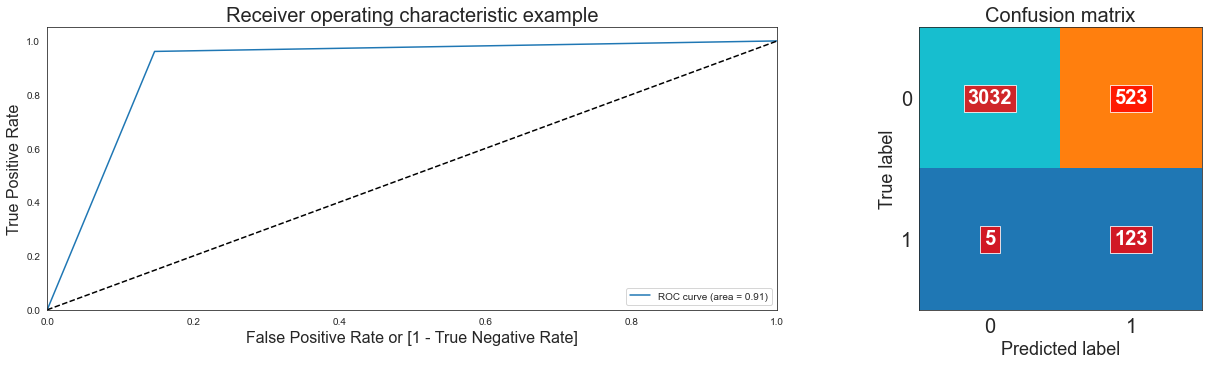

Running Model svc
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.96  Threshold:0.00009


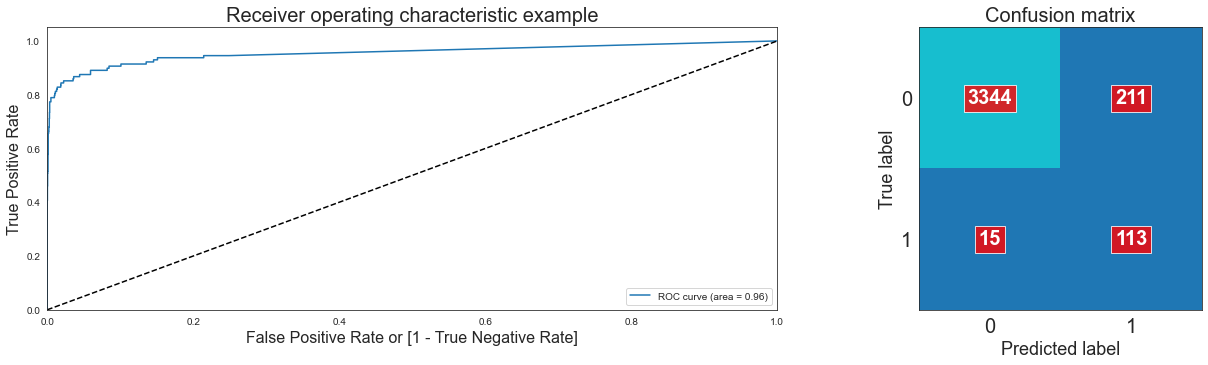

Running Model xgb
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.98  Threshold:0.50135


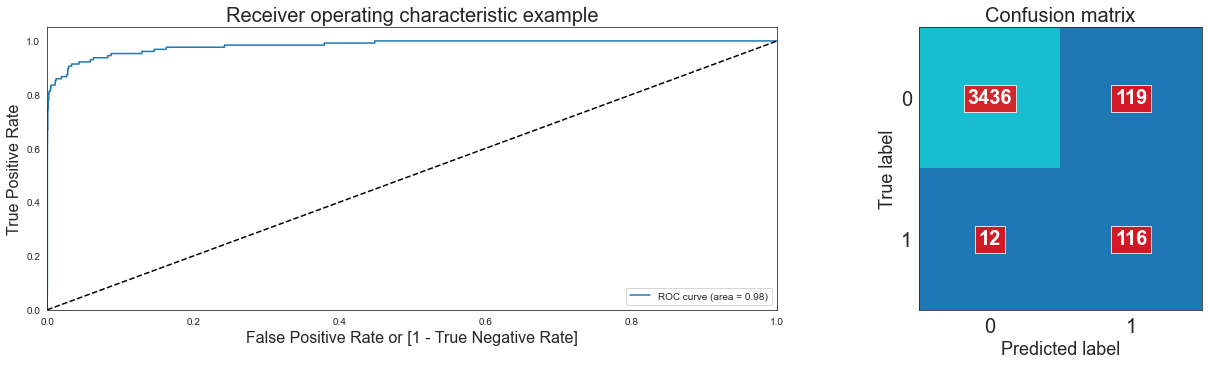

Running Model adaboost
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.98  Threshold:0.50045


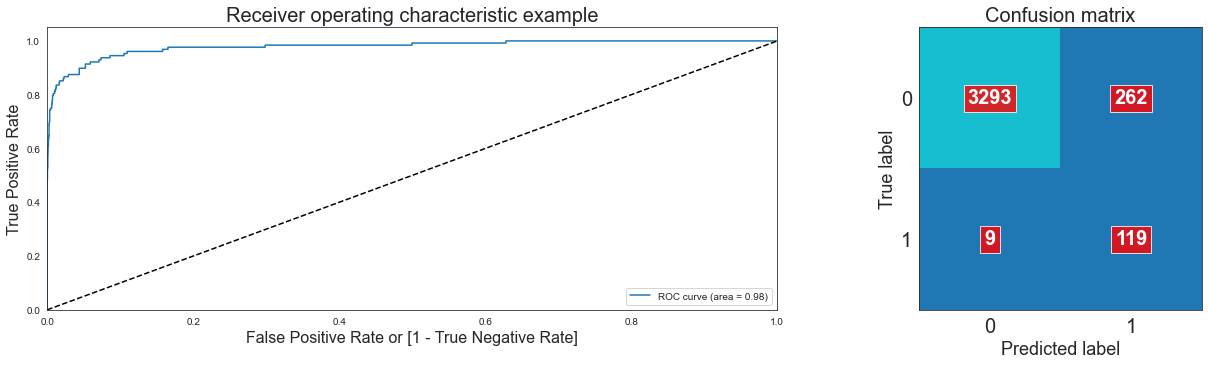

Running Model catboost
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.98  Threshold:0.02936


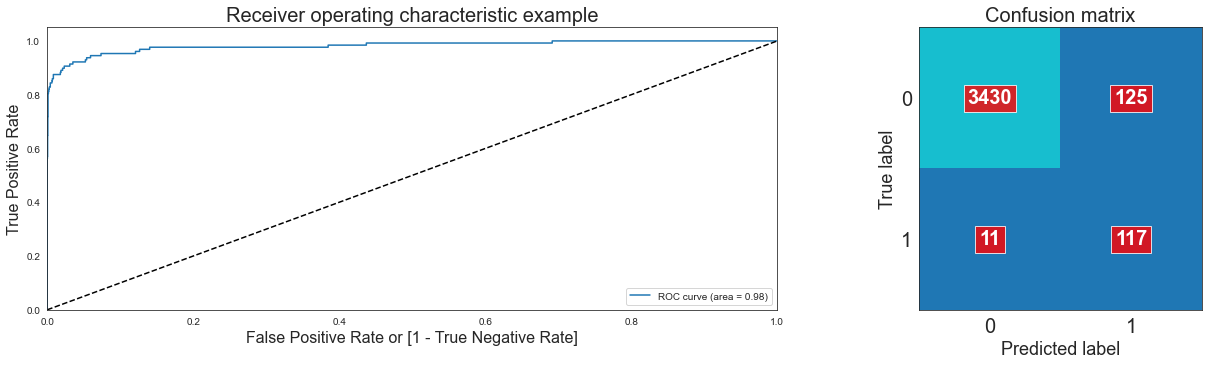

Running Model naiveb
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.97  Threshold:0.68549


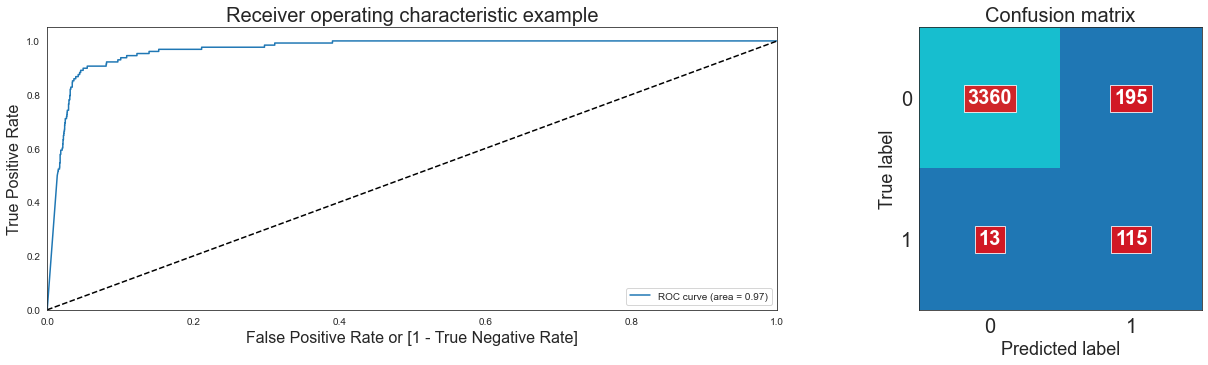

Running Model sgdc
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.92  Threshold:1.00000


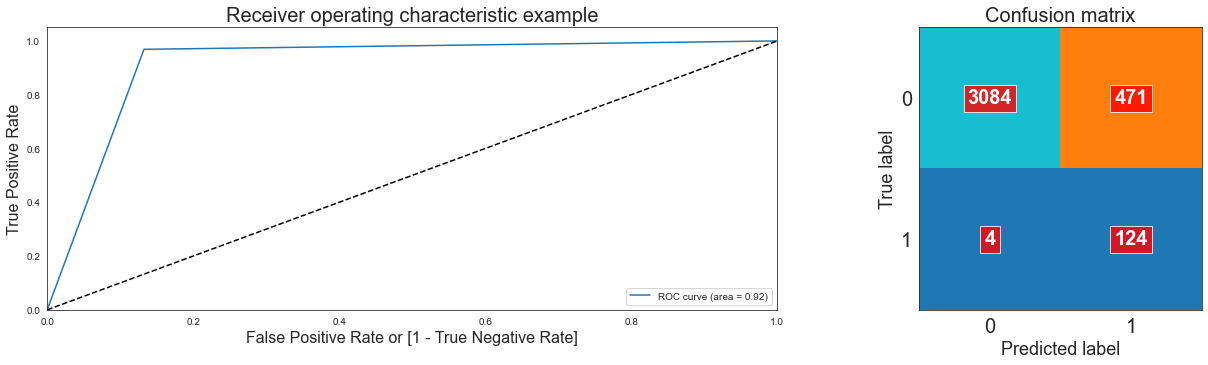

Running Model dnn
Epoch 1/50
214/214 [==============================] - 0s 1ms/step - loss: 0.5678 - accuracy: 0.7040
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 0.3300 - accuracy: 0.8680
Epoch 3/50
214/214 [==============================] - 0s 1ms/step - loss: 0.2461 - accuracy: 0.9025
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.9271
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.9399
Epoch 6/50
214/214 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.9509
Epoch 7/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9579
Epoch 8/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9648
Epoch 9/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9689
Epoch 10/50
214/214 [==============================] - 0s 1ms/step - loss: 0.0990 

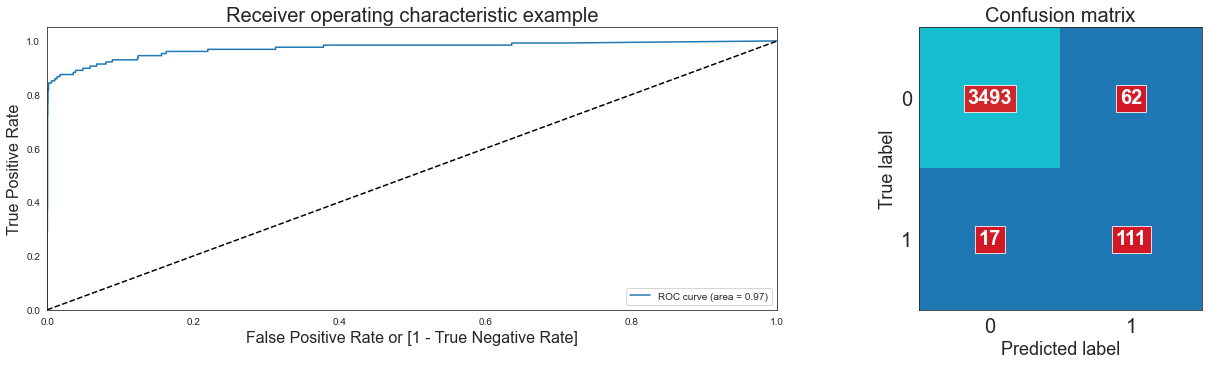

Running Model cnn
Epoch 1/50
5/5 [==============================] - 1s 126ms/step - loss: 0.6445 - accuracy: 0.6367
Epoch 2/50
5/5 [==============================] - 1s 142ms/step - loss: 0.6009 - accuracy: 0.6791
Epoch 3/50
5/5 [==============================] - 1s 145ms/step - loss: 0.5690 - accuracy: 0.7096
Epoch 4/50
5/5 [==============================] - 1s 153ms/step - loss: 0.5442 - accuracy: 0.7372
Epoch 5/50
5/5 [==============================] - 1s 146ms/step - loss: 0.5232 - accuracy: 0.7520
Epoch 6/50
5/5 [==============================] - 1s 159ms/step - loss: 0.5050 - accuracy: 0.7637
Epoch 7/50
5/5 [==============================] - 1s 170ms/step - loss: 0.4895 - accuracy: 0.7717
Epoch 8/50
5/5 [==============================] - 1s 169ms/step - loss: 0.4757 - accuracy: 0.7816
Epoch 9/50
5/5 [==============================] - 1s 153ms/step - loss: 0.4621 - accuracy: 0.7840
Epoch 10/50
5/5 [==============================] - 1s 164ms/step - loss: 0.4500 - accuracy: 0.7960
E

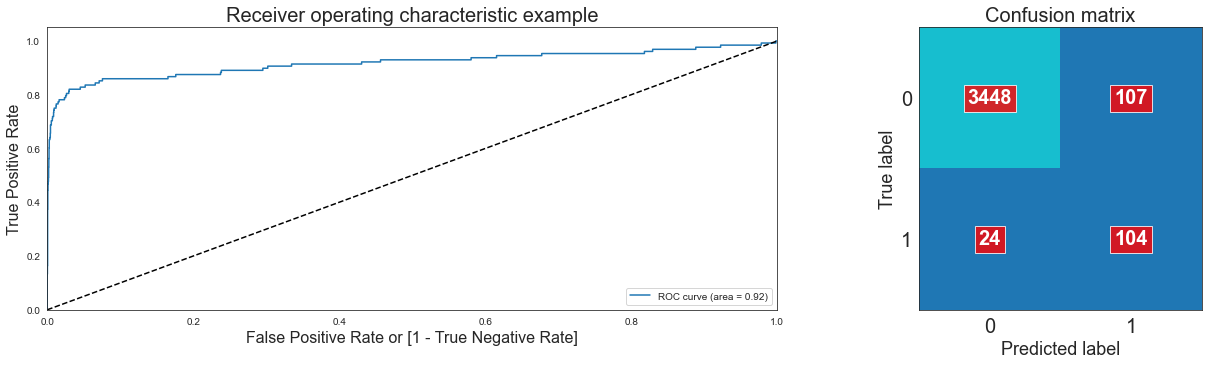

In [87]:
#options = ['0-Normal', '1-RandomOverSampler', '2-Smote', '3-AdaSyn']
option=3
X_train, X_test, y_train, y_test = select_dataset(option)
run_all_models(option)

In [89]:
final_results=pd.DataFrame(results, columns=['Data','Models','AUC','Recall','Precision','F1'])
final_results

Data               Models   AUC  Recall  Precision    F1
0              Normal  Logistic Regression  0.98    0.89       0.66  0.75
1              Normal                  GLM  0.98    0.89       0.70  0.78
2              Normal                  KNN  0.94    0.86       0.94  0.90
3              Normal        Random Forest  0.97    0.88       0.57  0.69
4              Normal        Decision Tree  0.91    0.00       0.00  0.00
5              Normal                 LGBM  0.98    0.90       0.72  0.80
6              Normal           Perceptron  0.90    0.80       0.90  0.85
7              Normal                  SVC  0.99    0.94       0.45  0.61
8              Normal              XGBoost  0.98    0.94       0.36  0.52
9              Normal             AdaBoost  0.98    0.90       0.53  0.67
10             Normal             CatBoost  0.99    0.95       0.49  0.64
11             Normal          Naive Bayes  0.97    0.88       0.47  0.62
12             Normal                  SGD  0.93    0.87       0.92  0.90
13             Normal                  DNN  0.98    0.95       0.42  0.58
14             Normal                  CNN  0.94    0.84       0.48  0.62
15              Smote  Logistic Regression  0.99    0.94       0.41  0.57
16              Smote                  GLM  0.99    0.94       0.41  0.57
17              Smote                  KNN  0.95    0.89       0.60  0.71
18              Smote        Random Forest  0.98    0.91       0.41  0.57
19              Smote        Decision Tree  0.93    0.00       0.00  0.00
20              Smote                 LGBM  0.99    0.93       0.59  0.72
21              Smote           Perceptron  0.90    0.88       0.26  0.40
22              Smote                  SVC  0.96    0.86       0.65  0.74
23              Smote              XGBoost  0.99    0.91       0.64  0.75
24              Smote             AdaBoost  0.98    0.91       0.67  0.77
25              Smote             CatBoost  0.98    0.91       0.44  0.60
26              Smote          Naive Bayes  0.97    0.88       0.47  0.61
27              Smote                  SGD  0.94    0.91       0.49  0.64
28              Smote                  DNN  0.97    0.88       0.61  0.72
29              Smote                  CNN  0.94    0.84       0.62  0.71
30             AdaSyn  Logistic Regression  0.98    0.89       0.74  0.81
31             AdaSyn                  GLM  0.98    0.89       0.70  0.78
32             AdaSyn                  KNN  0.95    0.00       0.00  0.00
33             AdaSyn        Random Forest  0.99    0.97       0.30  0.46
34             AdaSyn        Decision Tree  0.92    0.82       0.61  0.70
35             AdaSyn                 LGBM  0.99    0.94       0.51  0.66
36             AdaSyn           Perceptron  0.91    0.96       0.19  0.32
37             AdaSyn                  SVC  0.96    0.88       0.35  0.50
38             AdaSyn              XGBoost  0.98    0.91       0.49  0.64
39             AdaSyn             AdaBoost  0.98    0.93       0.31  0.47
40             AdaSyn             CatBoost  0.98    0.91       0.48  0.63
41             AdaSyn          Naive Bayes  0.97    0.90       0.37  0.53
42             AdaSyn                  SGD  0.92    0.97       0.21  0.34
43             AdaSyn                  DNN  0.97    0.87       0.64  0.74
44             AdaSyn                  CNN  0.92    0.81       0.49  0.61
45  RandomOverSampler  Logistic Regression  0.98    0.89       0.72  0.80
46  RandomOverSampler                  GLM  0.98    0.89       0.72  0.79
47  RandomOverSampler                  KNN  0.94    0.87       0.88  0.87
48  RandomOverSampler        Random Forest  0.97    0.89       0.68  0.77
49  RandomOverSampler        Decision Tree  0.89    0.78       0.78  0.78
50  RandomOverSampler                 LGBM  0.99    0.93       0.65  0.76
51  RandomOverSampler           Perceptron  0.89    0.84       0.31  0.46
52  RandomOverSampler                  SVC  0.97    0.91       0.40  0.55
53  RandomOverSampler

# <font color=blue> Section 8: Comparing All the Models and all Data Imbalancing Methods</font>

#### Mearge All Model, All Metrics Results Together

In [98]:
#AUC Score
final_results.sort_values('AUC',ascending=False).head(6)
#The Best AUC score on Test data with Any model is .99 
#AUC: The Best models are based on RF, LogR, CatBoost,SVC,GLM

Data               Models   AUC  Recall  Precision    F1
10  Normal             CatBoost  0.99    0.95       0.49  0.64
7   Normal                  SVC  0.99    0.94       0.45  0.61
16   Smote                  GLM  0.99    0.94       0.41  0.57
15   Smote  Logistic Regression  0.99    0.94       0.41  0.57
33  AdaSyn        Random Forest  0.99    0.97       0.30  0.46
35  AdaSyn                 LGBM  0.99    0.94       0.51  0.66

In [99]:
#Recall Score
final_results.sort_values('Recall',ascending=False).head(6) 

#The Best Recall score on Test data with Any model is .94.
#Recall: The Best Models are based on RF,SGD, Perceptron

Data         Models   AUC  Recall  Precision    F1
42  AdaSyn            SGD  0.92    0.97       0.21  0.34
33  AdaSyn  Random Forest  0.99    0.97       0.30  0.46
36  AdaSyn     Perceptron  0.91    0.96       0.19  0.32
13  Normal            DNN  0.98    0.95       0.42  0.58
10  Normal       CatBoost  0.99    0.95       0.49  0.64
16   Smote            GLM  0.99    0.94       0.41  0.57

In [100]:
#Precision Score
final_results.sort_values('Precision',ascending=False).head(6)
#The Best Precision score on Test data with Any model is .96. 
#Precision: The Best Models is based on KNN

Data               Models   AUC  Recall  Precision    F1
2              Normal                  KNN  0.94    0.86       0.94  0.90
12             Normal                  SGD  0.93    0.87       0.92  0.90
6              Normal           Perceptron  0.90    0.80       0.90  0.85
47  RandomOverSampler                  KNN  0.94    0.87       0.88  0.87
49  RandomOverSampler        Decision Tree  0.89    0.78       0.78  0.78
30             AdaSyn  Logistic Regression  0.98    0.89       0.74  0.81

In [101]:
#F1 Score
final_results.sort_values('F1',ascending=False).head(6)
#The Best F1 score on Test data with Any model is .93.
#F1: The Best Models are based on KNN, SGD

Data               Models   AUC  Recall  Precision    F1
2              Normal                  KNN  0.94    0.86       0.94  0.90
12             Normal                  SGD  0.93    0.87       0.92  0.90
47  RandomOverSampler                  KNN  0.94    0.87       0.88  0.87
6              Normal           Perceptron  0.90    0.80       0.90  0.85
30             AdaSyn  Logistic Regression  0.98    0.89       0.74  0.81
55  RandomOverSampler             CatBoost  0.96    0.89       0.72  0.80

# <font color=blue> Secion 9: Final Conclusion </font>

In [102]:
#AUC: The Best models are based on RF, LogR, CatBoost,SVC,GLM
#Recall: The Best Models are based on RF,SGD, Perceptron
#Precision: The Best Models is based on KNN
#F1: The Best Models are based on KNN, SGD
#AdpativeSyn is good oversampling technique
option=3
models_final =['logistic','knn','rfc']
models_final_name = ['Logistic Regression', 'KNN', 'Random Forest']

### Section 9.1 Now train the model with LGBM algo with full dataset.

In [103]:
#Load full dataset
df1 = pd.read_csv(filename)

cols2Scale = list(df1.columns)
cols2Scale.remove("Class")

#scale fields
sc=StandardScaler()
t=sc.fit_transform(df1[ cols2Scale ])
df1[cols2Scale] = t
df1.head(5)

#Trasform fields
df1[cols2Scale] = power_transform(df1[cols2Scale], method='yeo-johnson')

X= df1.drop(columns=["Class"], axis=0)
y= df1.Class #class variable

#Split the data.
#options = ['0-Normal', '1-RandomOverSampler', '2-Smote', '3-AdaSyn']
X_train1, X_test1, y_train1, y_test1  = split_data_normal(df1)
#X_train_ros, X_test_ros, y_train_ros, y_test_ros              = split_data_ros(X_train1, X_test1, y_train1, y_test1)
#X_train_smote, X_test_smote, y_train_smote, y_test_smote      = split_data_smote(X_train1, X_test1, y_train1, y_test1)
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn  = split_data_adasyn(X_train1, X_test1, y_train1, y_test1)

X_train, X_test, y_train, y_test = select_dataset(option)




Running Model with ** AdaSyn Data
Transaction Records in Train 426477
Transaction Records in Test 71202
Total Fraud Transaction Records 213364
Fraud Transaction Records in Train 213241
Fraud Transaction Records in Test 123


### Section 9.2 Develop Models using Selected Algorithm and Oversampler

Important Variables Identified in RFE
[('Time', False, 2), ('V1', True, 1), ('V2', True, 1), ('V3', True, 1), ('V4', True, 1), ('V5', False, 3), ('V6', False, 13), ('V7', False, 11), ('V8', True, 1), ('V9', True, 1), ('V10', True, 1), ('V11', True, 1), ('V12', True, 1), ('V13', False, 16), ('V14', True, 1), ('V15', False, 7), ('V16', True, 1), ('V17', True, 1), ('V18', False, 4), ('V19', False, 8), ('V20', False, 15), ('V21', False, 10), ('V22', True, 1), ('V23', True, 1), ('V24', False, 9), ('V25', True, 1), ('V26', False, 14), ('V27', False, 5), ('V28', False, 6), ('Amount', False, 12)]
This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.97  Threshold:0.71273


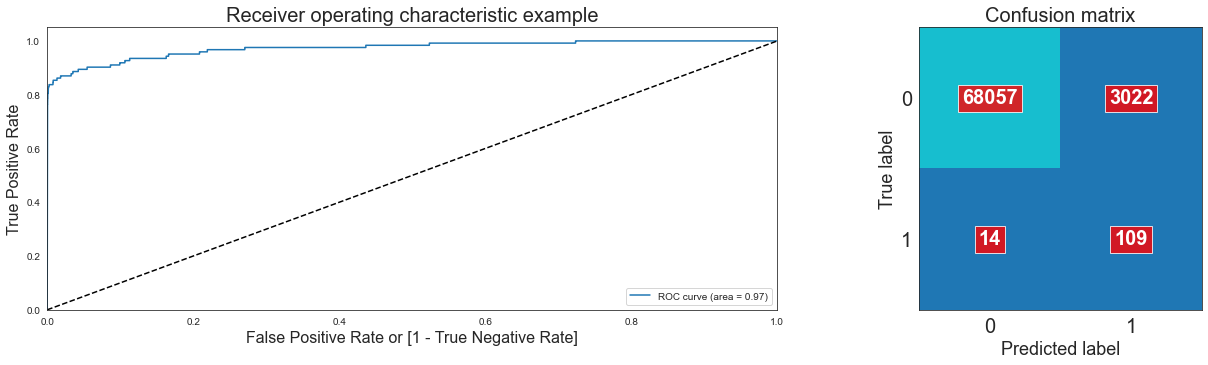

AUC 0.97, Recall 0.89, Precision 0.03, F1 0.07


In [104]:
auc_test, recall_test, precision_test, f1_test =logistic()
print (f"AUC {auc_test}, Recall {recall_test}, Precision {precision_test}, F1 {f1_test}")

This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.92  Threshold:0.75000


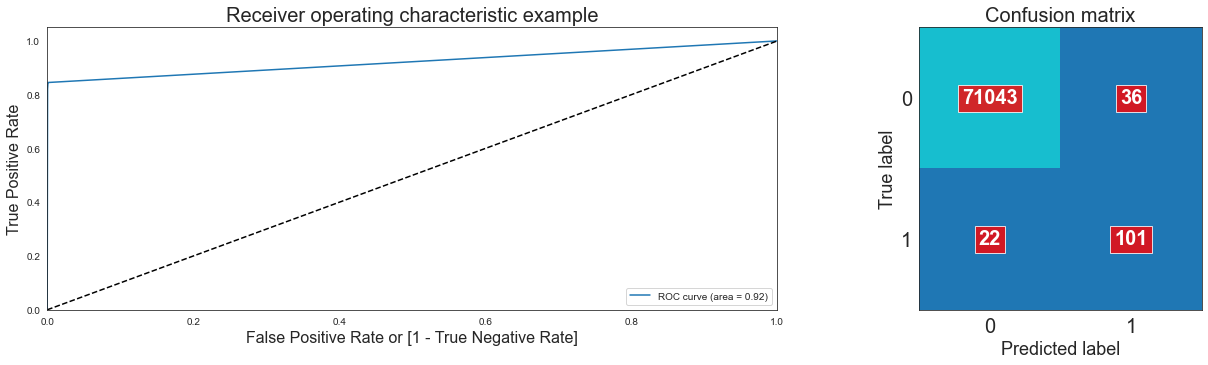

AUC 0.92, Recall 0.82, Precision 0.74, F1 0.78


In [105]:
auc_test, recall_test, precision_test, f1_test =knn()
print (f"AUC {auc_test}, Recall {recall_test}, Precision {precision_test}, F1 {f1_test}")

This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.98  Threshold:0.43605


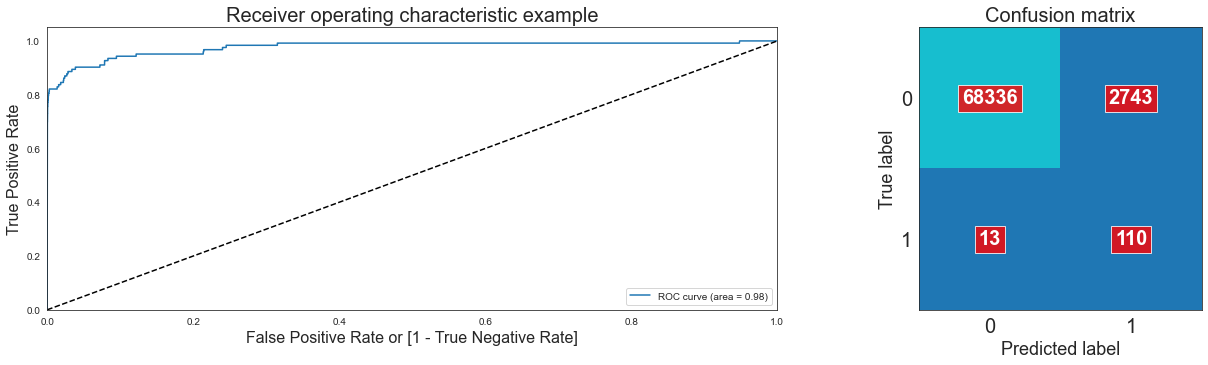

AUC 0.98, Recall 0.89, Precision 0.04, F1 0.07


In [106]:
auc_test, recall_test, precision_test, f1_test =rfc()
print (f"AUC {auc_test}, Recall {recall_test}, Precision {precision_test}, F1 {f1_test}")

This Model Result is for  AdaSyn  Data
ROC AUC Score on Test: 0.93  Threshold:0.05554


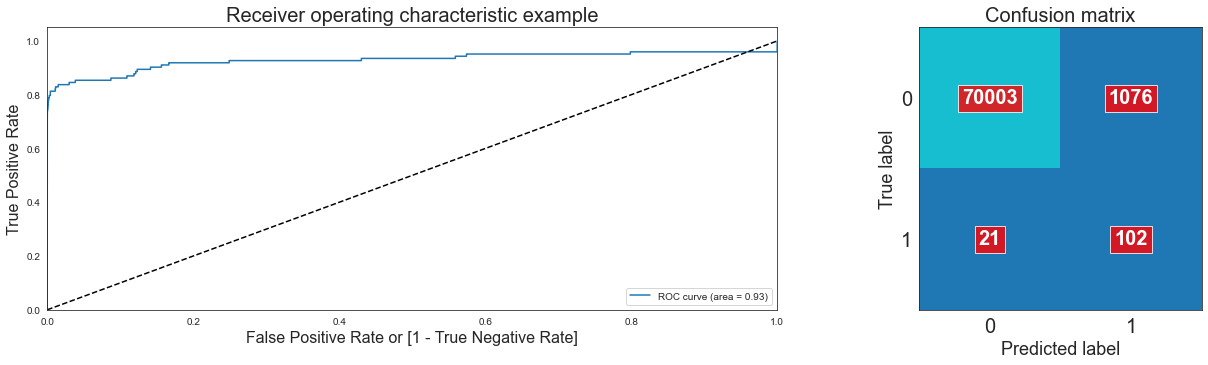

AUC 0.93, Recall 0.83, Precision 0.09, F1 0.16


In [108]:
auc_test, recall_test, precision_test, f1_test =lgbm()
print (f"AUC {auc_test}, Recall {recall_test}, Precision {precision_test}, F1 {f1_test}")

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [1]:
clf = KNeighborsClassifier(n_neighbors = 4, leaf_size=30, p=2)
clf.fit(X_train, y_train)
y_test_pred_knn = clf.predict_proba(X_test)

y_test_pred_knn = pd.DataFrame({'Class':y_test.values, 'Class_Prob':y_test_pred_knn[:,1:2].reshape(-1) })


knn_auc_test, knn_recall_test, knn_precision_test,knn_f1_test = \
                        draw_roc(y_test_pred_knn.Class, y_test_pred_knn.Class_Prob)


NameError: name 'KNeighborsClassifier' is not defined

In [113]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)

top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])
third_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-3])

print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1, X_train.columns[top_var_index])
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1, X_train.columns[second_top_var_index])
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1, X_train.columns[third_top_var_index])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index], 
            label='Actual Class-0 Examples', alpha=.5)
plt.scatter( X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples', alpha=.1)
plt.xlabel(X_train.columns[top_var_index], fontsize=14)
plt.ylabel(X_train.columns[second_top_var_index], fontsize=14)
plt.title("Top 2 Variables Relationship", fontsize=20)
plt.legend()

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

# <font color=blue> Secion 10: Financial Benefits of the Model </font>

In [ ]:
#Test Data: 71079 (normal) + 123 (fraud)
#KNN:      AUC 0.92, Recall 0.82, Precision 0.74, F1 0.78
#Logistic: AUC 0.97, Recall 0.89, Precision 0.03, F1 0.07
#RFC:      AUC 0.98, Recall 0.89, Precision 0.04, F1 0.07
#LGBM:     AUC 0.93, Recall 0.83, Precision 0.09, F1 0.16
    
#Total Fraud transactions in 2 days are 384. In one day 192 fraud transaction (average)
#Total normal transaction in 2 days are 284807. In one day 142,403 normal transations (average)
#Average fraud transaction is $122. In a 6 months FRAUD Tranactions of $122*6*30*192 = 42,16,320 i.e $ 4.2 million 
#can happen in the bank. 

#Next Six Month Approx Fraud Transactions: 34,560
#Next Six Month Approx Normal Transactions:51,265,260

#Recall score is 92% means 8% is False Negative.
#it means everyday 16 (8% of 192) fraud will be marked as normal transactions. 
#It also means 176 (92% of 192) fraud transactions can be caught using our model.

#i.e. out of 34560 fraud transactions our model can detect 31680 correctly in 6month. 
#And 2880 transaction will be False Negative. These are fraud transaction which our system fail to detect.

#Precision score is 97% means 3% is False Positive it means for every 100 fraud transactions identied by the system 
#3 are normal transaction. This can lead to customer dissatisfaction, because 3% customer feel that 
#their normal transaction was kept on hold.

#If bank call to the customer for all the transaction which are detected as fraud then only 3% cases will be 
#irritating call for the customer. Because he/she feel it is my genuine transaction.
#(176/.97)=> 181 calls every day=> 181 * 180 (days) =>  32580 calls (6 months)
#if Cost of each call is Rs 10 (assuming call centre in India) then cost of making 
#Then cost of making these call is Rs. 3,25,800. It can solve 92% fraud related problems
#For other normal transactions bank can call to the customer as per their policy based on random samplng and calling.
#In this they will be able to identify some of those 16 transactions which model couldn't detect.